In [2]:
source("/Users/wyx/Desktop/dissertation/wholecode.R")

In [7]:
library(xgboost)
library(pROC)
library(DescTools)
library(ModelMetrics)
library(rms)

In [4]:
# 设置随机种子以保证可重复性
set.seed(123)

# 数据生成模块
generate_non_shifted_data <- function(seed) {
  set.seed(seed)
  data <- generate_final_data(
    n = 9602, 
    target_mortality_rate = 0.2, 
    age_mean = 64.6, 
    age_sd = 12.5, 
    sex_prob = 0.309, 
    cpd_prob = 0.107, 
    pcs_prob = 0.282, 
    cps_prob = 0.241, 
    beta_age = 0.0285181, 
    beta_sex = 0.2196434, 
    beta_cpd = 0.1886564, 
    beta_pcs = 1.118599, 
    beta_cps = 1.086517
  )
  return(data)
}

# 循环200个随机种子，生成数据并计算性能指标
set.seed(123)  # 确保结果可重复
num_simulations <- 200
results_non_shifted <- data.frame(auc = numeric(num_simulations), o_e = numeric(num_simulations), c_slope = numeric(num_simulations), brier_score = numeric(num_simulations))

for (i in 1:num_simulations) {
  # 设置随机种子
  set.seed(i)
  
  data_non_shifted_xgb <- generate_non_shifted_data(i)

  # 确保 mortality 变量是因子类型
  data_non_shifted_xgb$mortality <- as.factor(data_non_shifted_xgb$mortality)
  data_val$mortality <- as.factor(data_val$mortality)

  # 转换数据格式
  dtrain <- xgb.DMatrix(data = as.matrix(data_non_shifted_xgb[, -6]), label = as.numeric(data_non_shifted_xgb$mortality) - 1)
  dval <- xgb.DMatrix(data = as.matrix(data_val[, -6]), label = as.numeric(data_val$mortality) - 1)

  # 设置参数
  params <- list(
    booster = "gbtree",
    objective = "binary:logistic",
    eta = 0.1,
    max_depth = 3,
    eval_metric = "auc"
  )

  # 训练模型
  xgb_model <- xgb.train(params, dtrain, nrounds = 50)

    
  # 预测
  predictions <- predict(xgb_model, dval)

  # 确保测试集的mortality变量是二进制数值类型
  test_mortality <- as.numeric(data_val$mortality) - 1

  # 计算 AUC
  auc <- roc(data_val$mortality, predictions)$auc
  print(paste("auc:", auc))

  # 绘制 ROC 曲线
  #plot.roc(roc_obj, main = paste("ROC Curve (AUC =", round(auc_value, 2), ")"), col = "blue")

  # 计算 O/E 比率
  observed <- sum(test_mortality)
  expected <- sum(predictions)
  oe_ratio <- observed / expected
  print(paste("O/E 比率:", oe_ratio))

  # 计算校准斜率 (C-slope)
  # 绘制校准曲线并提取斜率
  calibration <- val.prob(predictions, test_mortality, xlab="Predicted Probability", ylab="Observed Probability", pl = FALSE, smooth = FALSE)

  c_slope <- calibration["Slope"]

  print(paste("c_slope:", c_slope))

  # 计算 Brier 分数
  brier_score <- BrierScore(test_mortality, predictions)
  print(paste("Brier 分数:", brier_score))

  # 保存结果
  results_non_shifted[i, ] <- c(auc = auc, o_e = oe_ratio, c_slope = c_slope, brier_score = brier_score)

}
# 计算中位数、25%和75%的性能指标
median_metrics_non_shifted <- apply(results_non_shifted, 2, median)
quantile_25_metrics_non_shifted <- apply(results_non_shifted, 2, quantile, probs = 0.25)
quantile_75_metrics_non_shifted <- apply(results_non_shifted, 2, quantile, probs = 0.75)

# 将结果形成一个数据框
summary_metrics_non_shifted <- data.frame(
  metric = names(median_metrics_non_shifted),
  median = median_metrics_non_shifted,
  quantile_25 = quantile_25_metrics_non_shifted,
  quantile_75 = quantile_75_metrics_non_shifted
)

# 打印最终结果
summary_metrics_non_shifted



Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721933583436015"
[1] "O/E 比率: 0.960947981482402"
[1] "c_slope: 1.09751243526769"
[1] "Brier 分数: 0.143785175853859"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720223524687555"
[1] "O/E 比率: 1.00448085528209"
[1] "c_slope: 1.11443164828665"
[1] "Brier 分数: 0.144017661203891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718734872821686"
[1] "O/E 比率: 0.994145857245004"
[1] "c_slope: 1.08336627217453"
[1] "Brier 分数: 0.143993752207315"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722492601434607"
[1] "O/E 比率: 0.979925916565644"
[1] "c_slope: 1.15891556991722"
[1] "Brier 分数: 0.143329705323857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720196364526492"
[1] "O/E 比率: 1.00632604195596"
[1] "c_slope: 1.09463950220007"
[1] "Brier 分数: 0.143612139359195"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719168060200669"
[1] "O/E 比率: 0.999610439848143"
[1] "c_slope: 1.08690598512564"
[1] "Brier 分数: 0.144630065241046"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720279907806724"
[1] "O/E 比率: 0.978362583829655"
[1] "c_slope: 1.12731158002672"
[1] "Brier 分数: 0.143853158869669"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723525718953529"
[1] "O/E 比率: 1.00843279678657"
[1] "c_slope: 1.13791468642368"
[1] "Brier 分数: 0.143316148964839"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723143413901602"
[1] "O/E 比率: 1.01521143740944"
[1] "c_slope: 1.03475940222828"
[1] "Brier 分数: 0.143672468251877"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71584730076131"
[1] "O/E 比率: 0.994919615675281"
[1] "c_slope: 1.09684724936107"
[1] "Brier 分数: 0.144547990450113"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723316345053688"
[1] "O/E 比率: 1.00740917083521"
[1] "c_slope: 1.06151393174083"
[1] "Brier 分数: 0.143367589062062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720258592237282"
[1] "O/E 比率: 0.978828482897338"
[1] "c_slope: 1.08646965052983"
[1] "Brier 分数: 0.144302283227099"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721138375176025"
[1] "O/E 比率: 0.996731793228532"
[1] "c_slope: 1.08199768848275"
[1] "Brier 分数: 0.144047342919729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722640779022179"
[1] "O/E 比率: 1.01581514483746"
[1] "c_slope: 1.14995441941628"
[1] "Brier 分数: 0.144321053187828"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722485381644957"
[1] "O/E 比率: 0.985470166023118"
[1] "c_slope: 1.10109453114766"
[1] "Brier 分数: 0.143331296267867"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722853247117585"
[1] "O/E 比率: 1.01215509678592"
[1] "c_slope: 1.04811363460469"
[1] "Brier 分数: 0.14434949140412"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725906874339905"
[1] "O/E 比率: 1.00683043869968"
[1] "c_slope: 1.10448784679718"
[1] "Brier 分数: 0.14369855802679"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723887052235522"
[1] "O/E 比率: 0.994407490710628"
[1] "c_slope: 1.16029473808599"
[1] "Brier 分数: 0.143874939657952"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718033521827143"
[1] "O/E 比率: 0.988891905197309"
[1] "c_slope: 1.10652398231979"
[1] "Brier 分数: 0.144650603070637"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723415015512234"
[1] "O/E 比率: 0.95996877892418"
[1] "c_slope: 1.12970342826318"
[1] "Brier 分数: 0.14353814578234"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722073853634923"
[1] "O/E 比率: 0.967063483058561"
[1] "c_slope: 1.06877001519814"
[1] "Brier 分数: 0.143874878527531"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718461208414012"
[1] "O/E 比率: 0.989671892194579"
[1] "c_slope: 1.08954627135211"
[1] "Brier 分数: 0.143858615795396"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724681572896497"
[1] "O/E 比率: 0.959921439464137"
[1] "c_slope: 1.16818698942276"
[1] "Brier 分数: 0.143734763740763"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722786550013202"
[1] "O/E 比率: 1.03016541679592"
[1] "c_slope: 1.13839097439132"
[1] "Brier 分数: 0.144085080855076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719162559408555"
[1] "O/E 比率: 0.985207644620841"
[1] "c_slope: 1.09664424791"
[1] "Brier 分数: 0.1444310462302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724987554457842"
[1] "O/E 比率: 0.998673075932395"
[1] "c_slope: 1.11507231905005"
[1] "Brier 分数: 0.14329404461814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720159234179722"
[1] "O/E 比率: 1.04897421030411"
[1] "c_slope: 1.12398563342238"
[1] "Brier 分数: 0.144132544065207"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719728109597782"
[1] "O/E 比率: 0.99764765377175"
[1] "c_slope: 1.13888672206312"
[1] "Brier 分数: 0.144553630047362"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721210229273015"
[1] "O/E 比率: 0.970211169716858"
[1] "c_slope: 1.11278959600151"
[1] "Brier 分数: 0.143936380600155"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717743355043126"
[1] "O/E 比率: 1.00278382760013"
[1] "c_slope: 1.07955607133412"
[1] "Brier 分数: 0.144391789324468"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724519643328639"
[1] "O/E 比率: 0.994610063517022"
[1] "c_slope: 1.086986220179"
[1] "Brier 分数: 0.143457872769026"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725914781728569"
[1] "O/E 比率: 0.99752218675578"
[1] "c_slope: 1.07486304880795"
[1] "Brier 分数: 0.143012674726475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723243459558176"
[1] "O/E 比率: 0.985646294537938"
[1] "c_slope: 1.08599808551452"
[1] "Brier 分数: 0.143656061422612"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720493407300651"
[1] "O/E 比率: 0.989001399600814"
[1] "c_slope: 1.15241616118511"
[1] "Brier 分数: 0.144504058179531"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720711719987678"
[1] "O/E 比率: 1.02813440387878"
[1] "c_slope: 1.09513608463934"
[1] "Brier 分数: 0.144490667080656"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724421660469107"
[1] "O/E 比率: 0.995208591558492"
[1] "c_slope: 1.16717060152628"
[1] "Brier 分数: 0.144024980227952"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721184100510474"
[1] "O/E 比率: 0.984934368666089"
[1] "c_slope: 1.03059847924301"
[1] "Brier 分数: 0.143781883458813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720119353436895"
[1] "O/E 比率: 1.01926121560909"
[1] "c_slope: 1.11845886346088"
[1] "Brier 分数: 0.144479518098906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722189714068826"
[1] "O/E 比率: 0.99223342413799"
[1] "c_slope: 1.08747785469198"
[1] "Brier 分数: 0.143654319070303"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721716302147509"
[1] "O/E 比率: 1.00675134909255"
[1] "c_slope: 1.13685516908755"
[1] "Brier 分数: 0.144062686180028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723776692593733"
[1] "O/E 比率: 0.990698406527324"
[1] "c_slope: 1.06640555507591"
[1] "Brier 分数: 0.143644776653208"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724901260781552"
[1] "O/E 比率: 0.989257685631826"
[1] "c_slope: 1.09847923153775"
[1] "Brier 分数: 0.143251263994576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722142269736842"
[1] "O/E 比率: 0.997611611633036"
[1] "c_slope: 1.11457589033664"
[1] "Brier 分数: 0.144165870829459"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723740249845978"
[1] "O/E 比率: 0.993131051395352"
[1] "c_slope: 1.15086636082367"
[1] "Brier 分数: 0.144234338676749"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723621639016018"
[1] "O/E 比率: 1.02183600400243"
[1] "c_slope: 1.09107933502324"
[1] "Brier 分数: 0.143808939319371"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72761624548935"
[1] "O/E 比率: 0.949914544478435"
[1] "c_slope: 1.07618797677753"
[1] "Brier 分数: 0.143416403227649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722935415199789"
[1] "O/E 比率: 1.01425360435367"
[1] "c_slope: 1.13057261919887"
[1] "Brier 分数: 0.143836931611701"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719650067109664"
[1] "O/E 比率: 0.977949491444312"
[1] "c_slope: 1.05839053392771"
[1] "Brier 分数: 0.144380660535159"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720578325778912"
[1] "O/E 比率: 1.0038968087552"
[1] "c_slope: 1.12122903906664"
[1] "Brier 分数: 0.144500507349491"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722471629664672"
[1] "O/E 比率: 0.987429443140048"
[1] "c_slope: 1.0939290674786"
[1] "Brier 分数: 0.14399133982827"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721635165463827"
[1] "O/E 比率: 1.0418168400853"
[1] "c_slope: 1.10316323928265"
[1] "Brier 分数: 0.144415064004867"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72118925750308"
[1] "O/E 比率: 0.96703250777395"
[1] "c_slope: 1.14042732703747"
[1] "Brier 分数: 0.144323379495867"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725165298803028"
[1] "O/E 比率: 1.00467378677312"
[1] "c_slope: 1.07339881194517"
[1] "Brier 分数: 0.143296990342203"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723213892800563"
[1] "O/E 比率: 1.00900703799341"
[1] "c_slope: 1.06414378767905"
[1] "Brier 分数: 0.143883983450471"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722580957907939"
[1] "O/E 比率: 0.979624881481843"
[1] "c_slope: 1.07524462211879"
[1] "Brier 分数: 0.143967233959427"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722853247117585"
[1] "O/E 比率: 0.98712994034504"
[1] "c_slope: 1.15042980316292"
[1] "Brier 分数: 0.144309123870355"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7201774555536"
[1] "O/E 比率: 1.00429269199745"
[1] "c_slope: 1.06748144874313"
[1] "Brier 分数: 0.14417946162579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717239344965675"
[1] "O/E 比率: 0.998997009201887"
[1] "c_slope: 1.08368650576711"
[1] "Brier 分数: 0.145017959017894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719971863448337"
[1] "O/E 比率: 0.952179698521264"
[1] "c_slope: 1.07277531093536"
[1] "Brier 分数: 0.143965263666874"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72592303291674"
[1] "O/E 比率: 1.00986987406975"
[1] "c_slope: 1.11439766436121"
[1] "Brier 分数: 0.143620766273428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721642729052984"
[1] "O/E 比率: 1.00073217025764"
[1] "c_slope: 1.16785743794081"
[1] "Brier 分数: 0.144078549477774"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7253134763906"
[1] "O/E 比率: 0.993591532799054"
[1] "c_slope: 1.14165358378007"
[1] "Brier 分数: 0.143475533556268"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718891645396937"
[1] "O/E 比率: 0.948232531803633"
[1] "c_slope: 1.1167646007437"
[1] "Brier 分数: 0.144497981103958"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724159341445168"
[1] "O/E 比率: 0.998851018151483"
[1] "c_slope: 1.08749136289657"
[1] "Brier 分数: 0.143286324426468"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725114416475973"
[1] "O/E 比率: 0.973280834872291"
[1] "c_slope: 1.11870720445923"
[1] "Brier 分数: 0.14341315124209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718200952187115"
[1] "O/E 比率: 1.02037315596344"
[1] "c_slope: 1.08533678298177"
[1] "Brier 分数: 0.144227936832537"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724087143548671"
[1] "O/E 比率: 1.01916092548347"
[1] "c_slope: 1.19016419177065"
[1] "Brier 分数: 0.143816265964461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719777960526316"
[1] "O/E 比率: 0.981279200882158"
[1] "c_slope: 1.12607721408409"
[1] "Brier 分数: 0.144071883995104"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718277275677698"
[1] "O/E 比率: 0.965081661539311"
[1] "c_slope: 1.09124287290336"
[1] "Brier 分数: 0.144812226647405"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72145398312357"
[1] "O/E 比率: 0.987498567011879"
[1] "c_slope: 1.12575316328295"
[1] "Brier 分数: 0.144435983796611"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715880649313501"
[1] "O/E 比率: 0.99269881288047"
[1] "c_slope: 1.06461174384414"
[1] "Brier 分数: 0.144342986408686"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724167936432846"
[1] "O/E 比率: 1.00675735603591"
[1] "c_slope: 1.14503169004157"
[1] "Brier 分数: 0.143506049886099"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724084393152614"
[1] "O/E 比率: 0.985699462743626"
[1] "c_slope: 1.05844634079389"
[1] "Brier 分数: 0.143621715602823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722112702979229"
[1] "O/E 比率: 1.01604697931347"
[1] "c_slope: 1.05610517727382"
[1] "Brier 分数: 0.144219468692057"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722476099058264"
[1] "O/E 比率: 0.959918782300339"
[1] "c_slope: 1.11348177311163"
[1] "Brier 分数: 0.143594097788781"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721707363360324"
[1] "O/E 比率: 0.991649751610204"
[1] "c_slope: 1.10536708763645"
[1] "Brier 分数: 0.144086866866817"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721944241220736"
[1] "O/E 比率: 0.966432535999772"
[1] "c_slope: 1.12712577875939"
[1] "Brier 分数: 0.144173827868747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719008193429854"
[1] "O/E 比率: 1.00196805100392"
[1] "c_slope: 1.07715641925452"
[1] "Brier 分数: 0.144524901417916"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719862879004577"
[1] "O/E 比率: 0.990024813473887"
[1] "c_slope: 1.12390636735203"
[1] "Brier 分数: 0.144474634592548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72145638972012"
[1] "O/E 比率: 1.01134953677612"
[1] "c_slope: 1.11601602266953"
[1] "Brier 分数: 0.144188726987477"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719863910403098"
[1] "O/E 比率: 1.01392219181502"
[1] "c_slope: 1.11548387605122"
[1] "Brier 分数: 0.144469106651752"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724463604008977"
[1] "O/E 比率: 1.01097224039069"
[1] "c_slope: 1.09459686701652"
[1] "Brier 分数: 0.143501383477896"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723996036679282"
[1] "O/E 比率: 0.994802718497398"
[1] "c_slope: 1.09286249867296"
[1] "Brier 分数: 0.143486589869308"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72268134736402"
[1] "O/E 比率: 0.967426979513059"
[1] "c_slope: 1.11780831895412"
[1] "Brier 分数: 0.144129684545624"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723070184606583"
[1] "O/E 比率: 1.03393954249663"
[1] "c_slope: 1.08351419465854"
[1] "Brier 分数: 0.143542392578766"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723486869609224"
[1] "O/E 比率: 0.977665594342999"
[1] "c_slope: 1.06407787128855"
[1] "Brier 分数: 0.143809459260424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724357369961274"
[1] "O/E 比率: 0.972937426468545"
[1] "c_slope: 1.03592003405403"
[1] "Brier 分数: 0.143150973188001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724028010033445"
[1] "O/E 比率: 0.993762882572521"
[1] "c_slope: 1.07706528358985"
[1] "Brier 分数: 0.143608286891889"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723989160689139"
[1] "O/E 比率: 0.99559461041521"
[1] "c_slope: 1.13684986983796"
[1] "Brier 分数: 0.143713301876337"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723795601566626"
[1] "O/E 比率: 1.00880708699718"
[1] "c_slope: 1.12176888810977"
[1] "Brier 分数: 0.143051340125994"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719267418258229"
[1] "O/E 比率: 0.958317496891828"
[1] "c_slope: 1.12649877343829"
[1] "Brier 分数: 0.143933897907674"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722497070828199"
[1] "O/E 比率: 1.00176106488661"
[1] "c_slope: 1.06081502521516"
[1] "Brier 分数: 0.144270219536027"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719913073732617"
[1] "O/E 比率: 0.981864521001383"
[1] "c_slope: 1.1243378010786"
[1] "Brier 分数: 0.144425053783049"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723043712044534"
[1] "O/E 比率: 0.967888905661717"
[1] "c_slope: 1.173841476033"
[1] "Brier 分数: 0.144105958950734"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721582220339729"
[1] "O/E 比率: 0.986225169408557"
[1] "c_slope: 1.15776030477635"
[1] "Brier 分数: 0.144192311276364"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72021217930382"
[1] "O/E 比率: 1.03123998747739"
[1] "c_slope: 1.06040579980601"
[1] "Brier 分数: 0.143919151133554"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723077060596726"
[1] "O/E 比率: 1.06449360207881"
[1] "c_slope: 1.05915698593814"
[1] "Brier 分数: 0.144328531624077"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720500283290794"
[1] "O/E 比率: 0.969515488198114"
[1] "c_slope: 1.09802032303609"
[1] "Brier 分数: 0.144113201516815"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719029508999296"
[1] "O/E 比率: 0.982696193676267"
[1] "c_slope: 1.1306970724056"
[1] "Brier 分数: 0.143786079640044"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725945723684211"
[1] "O/E 比率: 0.978069127245175"
[1] "c_slope: 1.14487691048764"
[1] "Brier 分数: 0.142945377307045"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723216299397113"
[1] "O/E 比率: 1.02193099029318"
[1] "c_slope: 1.07107055906028"
[1] "Brier 分数: 0.143965203065809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720430491990847"
[1] "O/E 比率: 1.01370962338554"
[1] "c_slope: 1.06776456614223"
[1] "Brier 分数: 0.144575016630479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720432210988382"
[1] "O/E 比率: 0.977227106246472"
[1] "c_slope: 1.14129055948344"
[1] "Brier 分数: 0.144030200816157"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722413871347474"
[1] "O/E 比率: 1.03572316508889"
[1] "c_slope: 1.15291965971783"
[1] "Brier 分数: 0.144019531769161"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72446807340257"
[1] "O/E 比率: 1.01170866895835"
[1] "c_slope: 1.13923015324917"
[1] "Brier 分数: 0.143604190597559"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720754694926069"
[1] "O/E 比率: 0.97798887034744"
[1] "c_slope: 1.12705257709772"
[1] "Brier 分数: 0.14382721028484"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724050357001408"
[1] "O/E 比率: 0.987259357860888"
[1] "c_slope: 1.106237250206"
[1] "Brier 分数: 0.143622403026733"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72226706895793"
[1] "O/E 比率: 1.02809027702389"
[1] "c_slope: 1.14764864804974"
[1] "Brier 分数: 0.144447615296324"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717474160029044"
[1] "O/E 比率: 0.999841483209932"
[1] "c_slope: 1.15352295157253"
[1] "Brier 分数: 0.144476759879499"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720638146893153"
[1] "O/E 比率: 1.00172664944767"
[1] "c_slope: 1.06651790338134"
[1] "Brier 分数: 0.14382695023353"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720391642646541"
[1] "O/E 比率: 0.99634190900471"
[1] "c_slope: 1.12605637193491"
[1] "Brier 分数: 0.144066048099993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720445962968667"
[1] "O/E 比率: 1.00362740717824"
[1] "c_slope: 1.02529712573633"
[1] "Brier 分数: 0.14388323197884"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719361275523675"
[1] "O/E 比率: 1.0140650861307"
[1] "c_slope: 1.18969494879616"
[1] "Brier 分数: 0.14450411909183"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719248853084844"
[1] "O/E 比率: 0.993327540183734"
[1] "c_slope: 1.0429234453384"
[1] "Brier 分数: 0.144477444985755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725963945058088"
[1] "O/E 比率: 0.999276206272942"
[1] "c_slope: 1.17493955800805"
[1] "Brier 分数: 0.143281819226117"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720254466643197"
[1] "O/E 比率: 0.987681611583382"
[1] "c_slope: 1.2106343862961"
[1] "Brier 分数: 0.144360906852177"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720620269318782"
[1] "O/E 比率: 1.00306312789471"
[1] "c_slope: 1.14161848121121"
[1] "Brier 分数: 0.144086817786006"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724930827539166"
[1] "O/E 比率: 0.994687958293515"
[1] "c_slope: 1.08942778289441"
[1] "Brier 分数: 0.144004268383751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723130693319838"
[1] "O/E 比率: 0.982690687801832"
[1] "c_slope: 1.14092881341287"
[1] "Brier 分数: 0.143856843266781"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725808891480373"
[1] "O/E 比率: 1.022605880072"
[1] "c_slope: 1.10784981904252"
[1] "Brier 分数: 0.143622482432891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72263115263598"
[1] "O/E 比率: 1.02534045086893"
[1] "c_slope: 1.06491436742601"
[1] "Brier 分数: 0.144331298631696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718412045084492"
[1] "O/E 比率: 0.983481589737238"
[1] "c_slope: 1.05439843144866"
[1] "Brier 分数: 0.144166862750724"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718878924815173"
[1] "O/E 比率: 1.0107622856084"
[1] "c_slope: 1.0599874620611"
[1] "Brier 分数: 0.144550163707288"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718388666718007"
[1] "O/E 比率: 0.971845162030988"
[1] "c_slope: 1.06343698718116"
[1] "Brier 分数: 0.144187998326685"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725727067197676"
[1] "O/E 比率: 0.988959359215477"
[1] "c_slope: 1.07760270962672"
[1] "Brier 分数: 0.143518523613163"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719709544424397"
[1] "O/E 比率: 1.00781705460084"
[1] "c_slope: 1.1533766208012"
[1] "Brier 分数: 0.144072437931245"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71934511694684"
[1] "O/E 比率: 1.00513885595225"
[1] "c_slope: 1.0915149483576"
[1] "Brier 分数: 0.144498969083668"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723520218161415"
[1] "O/E 比率: 1.00406132152315"
[1] "c_slope: 1.05618083268141"
[1] "Brier 分数: 0.14363420808588"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721897140688259"
[1] "O/E 比率: 0.99367658994442"
[1] "c_slope: 1.15814277802475"
[1] "Brier 分数: 0.143752826687455"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7249517993091"
[1] "O/E 比率: 1.01192542779504"
[1] "c_slope: 1.16406347478361"
[1] "Brier 分数: 0.143391717511013"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722810272179194"
[1] "O/E 比率: 0.981684969922121"
[1] "c_slope: 1.14852246537984"
[1] "Brier 分数: 0.144063155166617"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72165510583524"
[1] "O/E 比率: 0.957447215385273"
[1] "c_slope: 1.11593388982036"
[1] "Brier 分数: 0.144220302627075"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718793662537405"
[1] "O/E 比率: 1.01110329247649"
[1] "c_slope: 1.10785722372257"
[1] "Brier 分数: 0.144857029699839"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722204153648125"
[1] "O/E 比率: 0.994014328233851"
[1] "c_slope: 1.12185316676401"
[1] "Brier 分数: 0.143081014004583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723232457973948"
[1] "O/E 比率: 0.979359844271873"
[1] "c_slope: 1.06701091003984"
[1] "Brier 分数: 0.143434492769684"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721971745181306"
[1] "O/E 比率: 1.01023821346646"
[1] "c_slope: 1.1288848463234"
[1] "Brier 分数: 0.143587495537866"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723305687268967"
[1] "O/E 比率: 1.02633707229376"
[1] "c_slope: 1.06602181160449"
[1] "Brier 分数: 0.143550490826634"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720339728920965"
[1] "O/E 比率: 0.973018109840783"
[1] "c_slope: 1.09233631733224"
[1] "Brier 分数: 0.143770722125758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721154189953353"
[1] "O/E 比率: 0.975609394323824"
[1] "c_slope: 1.09529644772142"
[1] "Brier 分数: 0.144090121621726"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723262024731561"
[1] "O/E 比率: 0.969434854752121"
[1] "c_slope: 1.14603213976343"
[1] "Brier 分数: 0.143987897244145"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718096780936455"
[1] "O/E 比率: 0.999578574243698"
[1] "c_slope: 1.04816051315604"
[1] "Brier 分数: 0.14452170348297"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717500288791586"
[1] "O/E 比率: 0.989301764517429"
[1] "c_slope: 1.10395402882372"
[1] "Brier 分数: 0.144306477371417"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723959593931526"
[1] "O/E 比率: 1.00107140997163"
[1] "c_slope: 1.08156504060988"
[1] "Brier 分数: 0.143677715520625"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718793318737898"
[1] "O/E 比率: 1.02165690024009"
[1] "c_slope: 1.10646111238832"
[1] "Brier 分数: 0.144437241145894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721902297680866"
[1] "O/E 比率: 1.05343651490962"
[1] "c_slope: 1.06825219146288"
[1] "Brier 分数: 0.144127657095071"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723859204475444"
[1] "O/E 比率: 1.02283568477788"
[1] "c_slope: 1.21119065695816"
[1] "Brier 分数: 0.144128318182076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723576601280584"
[1] "O/E 比率: 0.973503376465865"
[1] "c_slope: 1.08571562151008"
[1] "Brier 分数: 0.14372601157395"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725611206763774"
[1] "O/E 比率: 0.974776221808025"
[1] "c_slope: 1.08522639568133"
[1] "Brier 分数: 0.142979145298986"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725645586714487"
[1] "O/E 比率: 0.996942504475594"
[1] "c_slope: 1.06770961228512"
[1] "Brier 分数: 0.143590031336212"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722426248129731"
[1] "O/E 比率: 0.995231473070604"
[1] "c_slope: 1.10873567777676"
[1] "Brier 分数: 0.143666862598229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723221112590213"
[1] "O/E 比率: 0.989141979607312"
[1] "c_slope: 1.08429756405136"
[1] "Brier 分数: 0.143774094669443"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721935646233058"
[1] "O/E 比率: 1.02515508518713"
[1] "c_slope: 1.10189249379267"
[1] "Brier 分数: 0.144674952273644"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726559405804436"
[1] "O/E 比率: 0.974976980101934"
[1] "c_slope: 1.13495064772508"
[1] "Brier 分数: 0.143497809260172"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725990417620137"
[1] "O/E 比率: 1.01335037364839"
[1] "c_slope: 1.05297503566553"
[1] "Brier 分数: 0.143239374033553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719939202495159"
[1] "O/E 比率: 1.01722553209308"
[1] "c_slope: 1.08431444128173"
[1] "Brier 分数: 0.144456956991712"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720333196730329"
[1] "O/E 比率: 1.00997001018726"
[1] "c_slope: 1.12271409746329"
[1] "Brier 分数: 0.1450130800795"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716944708788065"
[1] "O/E 比率: 1.00125236622922"
[1] "c_slope: 1.04985109268519"
[1] "Brier 分数: 0.144782167255224"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720915593095406"
[1] "O/E 比率: 0.990829117633707"
[1] "c_slope: 1.06489155511141"
[1] "Brier 分数: 0.144124909287507"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722854278516106"
[1] "O/E 比率: 1.03401971030343"
[1] "c_slope: 1.10704632726926"
[1] "Brier 分数: 0.143970936459604"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726565250396057"
[1] "O/E 比率: 1.00312312185694"
[1] "c_slope: 1.14234511075637"
[1] "Brier 分数: 0.143664877596865"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722192464464883"
[1] "O/E 比率: 1.01078207097226"
[1] "c_slope: 1.1538160119509"
[1] "Brier 分数: 0.143951336483008"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717524354757085"
[1] "O/E 比率: 0.982002754608208"
[1] "c_slope: 1.018653066544"
[1] "Brier 分数: 0.14480012266216"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720093912273367"
[1] "O/E 比率: 0.985335723899403"
[1] "c_slope: 1.14518260427409"
[1] "Brier 分数: 0.143746184173315"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720525380654814"
[1] "O/E 比率: 1.01511577097906"
[1] "c_slope: 1.15813409019224"
[1] "Brier 分数: 0.143975462027361"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719511515908291"
[1] "O/E 比率: 1.03186726667267"
[1] "c_slope: 1.10577905122276"
[1] "Brier 分数: 0.144492467750137"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720541539231649"
[1] "O/E 比率: 0.96668869318384"
[1] "c_slope: 1.04880049161544"
[1] "Brier 分数: 0.144095732506963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72390286701285"
[1] "O/E 比率: 1.00890478024967"
[1] "c_slope: 1.05110221514072"
[1] "Brier 分数: 0.144023904722549"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72276282784721"
[1] "O/E 比率: 0.983718244373993"
[1] "c_slope: 1.09491173180029"
[1] "Brier 分数: 0.143625067837905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725564793830312"
[1] "O/E 比率: 1.00282378100511"
[1] "c_slope: 1.11079131827784"
[1] "Brier 分数: 0.143325894807813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722031566295547"
[1] "O/E 比率: 0.969691002822193"
[1] "c_slope: 1.10292716077717"
[1] "Brier 分数: 0.143831232378813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722173211692484"
[1] "O/E 比率: 1.02155952370904"
[1] "c_slope: 1.16359809054382"
[1] "Brier 分数: 0.144172902668257"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720199802521563"
[1] "O/E 比率: 1.05167681740688"
[1] "c_slope: 1.08115702370976"
[1] "Brier 分数: 0.144155556018149"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721024233739659"
[1] "O/E 比率: 0.983009273908437"
[1] "c_slope: 1.09670233086842"
[1] "Brier 分数: 0.143718519174498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725477468755501"
[1] "O/E 比率: 0.968424608835217"
[1] "c_slope: 1.10319988264557"
[1] "Brier 分数: 0.143336737220065"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724180313215103"
[1] "O/E 比率: 1.01383995158428"
[1] "c_slope: 1.15894360383529"
[1] "Brier 分数: 0.143810287411969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720993979383031"
[1] "O/E 比率: 0.948704436689078"
[1] "c_slope: 1.08613809949624"
[1] "Brier 分数: 0.144219910576272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72216530430382"
[1] "O/E 比率: 0.976656815933334"
[1] "c_slope: 1.08896830348668"
[1] "Brier 分数: 0.144172798151525"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720986415793874"
[1] "O/E 比率: 1.0157936471355"
[1] "c_slope: 1.00018924060448"
[1] "Brier 分数: 0.144414079633888"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721593909522971"
[1] "O/E 比率: 0.964435287002252"
[1] "c_slope: 1.14426987337838"
[1] "Brier 分数: 0.144116503641195"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721927051245379"
[1] "O/E 比率: 1.02102447811049"
[1] "c_slope: 1.14189808727885"
[1] "Brier 分数: 0.14369981482828"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724421660469108"
[1] "O/E 比率: 0.974508854240601"
[1] "c_slope: 1.04122275940772"
[1] "Brier 分数: 0.143289556493897"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724065484179722"
[1] "O/E 比率: 1.01443304526214"
[1] "c_slope: 1.16570173666632"
[1] "Brier 分数: 0.143416783068023"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724090237744235"
[1] "O/E 比率: 1.00938833989813"
[1] "c_slope: 1.11029578937266"
[1] "Brier 分数: 0.144162326859958"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723548409721"
[1] "O/E 比率: 1.01340735969537"
[1] "c_slope: 1.04791173080782"
[1] "Brier 分数: 0.143495275493831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724099520330928"
[1] "O/E 比率: 1.01230436800148"
[1] "c_slope: 1.13460215252596"
[1] "Brier 分数: 0.143533287022678"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719520454695476"
[1] "O/E 比率: 0.995130729413661"
[1] "c_slope: 1.1067578732677"
[1] "Brier 分数: 0.144248298856724"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723842358299595"
[1] "O/E 比率: 0.991428268650024"
[1] "c_slope: 1.09392347500962"
[1] "Brier 分数: 0.143695872618531"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724299611644077"
[1] "O/E 比率: 0.963643648152696"
[1] "c_slope: 1.08889832515911"
[1] "Brier 分数: 0.143589867895433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71916668500264"
[1] "O/E 比率: 1.0278508298909"
[1] "c_slope: 1.13805879641147"
[1] "Brier 分数: 0.144654826524023"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723285403098046"
[1] "O/E 比率: 0.975610886196515"
[1] "c_slope: 1.09586447520269"
[1] "Brier 分数: 0.144139948363166"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722501540221792"
[1] "O/E 比率: 1.01422651645784"
[1] "c_slope: 1.11845962863199"
[1] "Brier 分数: 0.144222798739864"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720218367694948"
[1] "O/E 比率: 0.9984797884169"
[1] "c_slope: 1.08194674624759"
[1] "Brier 分数: 0.143876391396327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723346255610808"
[1] "O/E 比率: 0.990025161318199"
[1] "c_slope: 1.06450284435142"
[1] "Brier 分数: 0.143848433854806"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724445038835592"
[1] "O/E 比率: 1.00797330265987"
[1] "c_slope: 1.1167026608737"
[1] "Brier 分数: 0.143812970198999"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725123699062665"
[1] "O/E 比率: 0.973495778421873"
[1] "c_slope: 1.09408959002522"
[1] "Brier 分数: 0.143470178313886"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7235387833348"
[1] "O/E 比率: 1.03433877404859"
[1] "c_slope: 1.0774196820942"
[1] "Brier 分数: 0.14389174063437"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721149376760253"
[1] "O/E 比率: 0.993380256882446"
[1] "c_slope: 1.15116331778897"
[1] "Brier 分数: 0.144120131925111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723883270440943"
[1] "O/E 比率: 0.98051695227853"
[1] "c_slope: 1.18321836271562"
[1] "Brier 分数: 0.143933172074571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722872843689491"
[1] "O/E 比率: 0.9789360444547"
[1] "c_slope: 1.08992351975013"
[1] "Brier 分数: 0.143989532704866"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722143644934871"
[1] "O/E 比率: 1.02067602932235"
[1] "c_slope: 1.09192296831639"
[1] "Brier 分数: 0.143918439431867"


,metric,median,quantile_25,quantile_75
,<chr>,<dbl>,<dbl>,<dbl>
auc,auc,0.7221815,0.7202576,0.7238073
o_e,o_e,0.9954130,0.9818196,1.0110050
c_slope,c_slope,1.1030452,1.0775570,1.1346893
brier_score,brier_score,0.1439732,0.1436421,0.1442378


# 1、Predictor-Outcome Association Shift

In [4]:
library(xgboost)
library(pROC)
library(DescTools)
library(ModelMetrics)
library(rms)

# 设置随机种子以保证可重复性
set.seed(123)

# 数据生成模块
# 数据生成偏移的data_shifted_age模块
generate_shifted_data_age_2_ml <- function(seed, beta_age_start, beta_age_end) {
  set.seed(seed)
  data <- generate_shifted_data_age(
    time_periods = 2,
    n = 9602,
    target_mortality_rate = 0.2,
    age_mean = 64.6,
    age_sd = 12.5,
    sex_prob = 0.309,
    cpd_prob = 0.107,
    pcs_prob = 0.282,
    cps_prob = 0.241, 
    beta_age_start = beta_age_start,
    beta_age_end = beta_age_end,
    beta_sex = 0.2196434,
    beta_cpd = 0.1886564,
    beta_pcs = 1.118599,
    beta_cps = 1.086517
  )
  return(data)
}

experiments_age <- list(
  list(name = "age β:0.0285,0.0285", beta_age_start = 0.0285181, beta_age_end = 0.0285181),
  list(name = "age β:0.0285,0.0378", beta_age_start = 0.0285181, beta_age_end = 0.0378427),
  list(name = "age β:0.0285,0.0502", beta_age_start = 0.0285181, beta_age_end = 0.0502162),
  list(name = "age β:0.0285,0.0666", beta_age_start = 0.0285181, beta_age_end = 0.0666354),
  list(name = "age β:0.0285,0.0884", beta_age_start = 0.0285181, beta_age_end = 0.0884233),
  list(name = "age β:0.0285,0.1173", beta_age_start = 0.0285181, beta_age_end = 0.1173351),
  list(name = "age β:0.0285,0.1557", beta_age_start = 0.0285181, beta_age_end = 0.1557003),
  list(name = "age β:0.0285,0.2066", beta_age_start = 0.0285181, beta_age_end = 0.2066098),
  list(name = "age β:0.0285,0.2742", beta_age_start = 0.0285181, beta_age_end = 0.2741652),
  list(name = "age β:0.0285,0.3638", beta_age_start = 0.0285181, beta_age_end = 0.3638093)
)

# 循环200个随机种子，生成数据并计算性能指标
set.seed(123)  # 确保结果可重复
num_simulations <- 200

results_shifted_age_2_ml <- data.frame()

for (exp in experiments_age) {
  results <- data.frame(auc = numeric(num_simulations), o_e = numeric(num_simulations), c_slope = numeric(num_simulations), brier_score = numeric(num_simulations))
  for (i in 1:num_simulations) {
    # 设置随机种子
    set.seed(i)

    # 修改：生成数据时传递 beta_age_start 和 beta_age_end 参数
    data_shifted_xgb <- generate_shifted_data_age_2_ml(i, exp$beta_age_start, exp$beta_age_end)

    # 确保 mortality 变量是因子类型
    data_shifted_xgb$mortality <- as.factor(data_shifted_xgb$mortality)
    data_val$mortality <- as.factor(data_val$mortality)

    # 转换数据格式
    # 修改：确保选择正确的数据列
    dtrain <- xgb.DMatrix(data = as.matrix(data_shifted_xgb[, -6]), label = as.numeric(data_shifted_xgb$mortality) - 1)
    dval <- xgb.DMatrix(data = as.matrix(data_val[, -6]), label = as.numeric(data_val$mortality) - 1)

    # 设置参数
    params <- list(
      booster = "gbtree",
      objective = "binary:logistic",
      eta = 0.1,
      max_depth = 3,
      eval_metric = "auc"
    )

    # 训练模型
    xgb_model <- xgb.train(params, dtrain, nrounds = 50)

    # 预测
    predictions <- predict(xgb_model, dval)

    # 确保测试集的mortality变量是二进制数值类型
    test_mortality <- as.numeric(data_val$mortality) - 1

    # 计算 AUC
    auc <- roc(data_val$mortality, predictions)$auc
    print(paste("auc:", auc))

    # 计算 O/E 比率
    observed <- sum(test_mortality)
    expected <- sum(predictions)
    oe_ratio <- observed / expected
    print(paste("O/E 比率:", oe_ratio))

    # 计算校准斜率 (C-slope)
    # 修改：确保 val.prob 函数正确使用并提取斜率
    calibration <- val.prob(predictions, test_mortality, xlab="Predicted Probability", ylab="Observed Probability", pl = FALSE, smooth = FALSE)
    c_slope <- calibration["Slope"]
    print(paste("c_slope:", c_slope))

    # 计算 Brier 分数
    brier_score <- BrierScore(test_mortality, predictions)
    print(paste("Brier 分数:", brier_score))

    # 保存结果
    results[i, ] <- c(auc = auc, o_e = oe_ratio, c_slope = c_slope, brier_score = brier_score)
  }

  # 计算中位数、25%和75%的性能指标
  median_metrics_shifted_age_2_ml <- apply(results, 2, median)
  quantile_25_metrics_shifted_age_2_ml <- apply(results, 2, quantile, probs = 0.25)
  quantile_75_metrics_shifted_age_2_ml <- apply(results, 2, quantile, probs = 0.75)

  # 将实验名称和结果添加到总的结果数据框
  summary_metrics_shifted_age_2_ml <- data.frame(
    experiment = exp$name,
    auc_median = median_metrics_shifted_age_2_ml['auc'],
    auc_25 = quantile_25_metrics_shifted_age_2_ml['auc'],
    auc_75 = quantile_75_metrics_shifted_age_2_ml['auc'],
    o_e_median = median_metrics_shifted_age_2_ml['o_e'],
    o_e_25 = quantile_25_metrics_shifted_age_2_ml['o_e'],
    o_e_75 = quantile_75_metrics_shifted_age_2_ml['o_e'],
    c_slope_median = median_metrics_shifted_age_2_ml['c_slope'],
    c_slope_25 = quantile_25_metrics_shifted_age_2_ml['c_slope'],
    c_slope_75 = quantile_75_metrics_shifted_age_2_ml['c_slope'],
    brier_score_median = median_metrics_shifted_age_2_ml['brier_score'],
    brier_score_25 = quantile_25_metrics_shifted_age_2_ml['brier_score'],
    brier_score_75 = quantile_75_metrics_shifted_age_2_ml['brier_score']
  )
  
  results_shifted_age_2_ml <- rbind(results_shifted_age_2_ml, summary_metrics_shifted_age_2_ml)
}

# 打印最终结果
results_shifted_age_2_ml


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721773029066186"
[1] "O/E 比率: 1.00492761969956"
[1] "c_slope: 1.08214770411894"
[1] "Brier 分数: 0.144193146413868"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723537064337265"
[1] "O/E 比率: 0.955001966760982"
[1] "c_slope: 1.19941220580017"
[1] "Brier 分数: 0.143980096355089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723517811564865"
[1] "O/E 比率: 0.988600208928995"
[1] "c_slope: 1.08122462022372"
[1] "Brier 分数: 0.143396795196087"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718153507855131"
[1] "O/E 比率: 1.00164799288804"
[1] "c_slope: 1.09493627589171"
[1] "Brier 分数: 0.144258225653696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720014150787713"
[1] "O/E 比率: 0.990912345614894"
[1] "c_slope: 1.10504295691046"
[1] "Brier 分数: 0.143862397757292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721534432208238"
[1] "O/E 比率: 0.980381851326794"
[1] "c_slope: 1.14469027901473"
[1] "Brier 分数: 0.144227573403214"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719648348112128"
[1] "O/E 比率: 1.01156058928414"
[1] "c_slope: 1.07812913234873"
[1] "Brier 分数: 0.144121861068161"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721309587330576"
[1] "O/E 比率: 1.013353877848"
[1] "c_slope: 1.16546988223026"
[1] "Brier 分数: 0.144503858186405"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720519192263686"
[1] "O/E 比率: 1.00380396563145"
[1] "c_slope: 1.08266387156942"
[1] "Brier 分数: 0.143922795971256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723186045040486"
[1] "O/E 比率: 0.961384802333983"
[1] "c_slope: 1.09138901561778"
[1] "Brier 分数: 0.143441053126001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722764203045238"
[1] "O/E 比率: 0.975505984934262"
[1] "c_slope: 1.15194171663635"
[1] "Brier 分数: 0.143565674468126"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723434268284633"
[1] "O/E 比率: 1.00002338347098"
[1] "c_slope: 1.08297112810434"
[1] "Brier 分数: 0.14376233763498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723621295216511"
[1] "O/E 比率: 0.963476042054943"
[1] "c_slope: 1.10251095762575"
[1] "Brier 分数: 0.143748661478479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725633897531245"
[1] "O/E 比率: 0.960293245989541"
[1] "c_slope: 1.12579976032525"
[1] "Brier 分数: 0.143565836560028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722663813589157"
[1] "O/E 比率: 0.992408386265836"
[1] "c_slope: 1.12549976028033"
[1] "Brier 分数: 0.143953623869618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724901260781553"
[1] "O/E 比率: 0.98253959437278"
[1] "c_slope: 1.11271174865818"
[1] "Brier 分数: 0.143456058719802"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718222611556064"
[1] "O/E 比率: 0.972111215569476"
[1] "c_slope: 1.08646702289099"
[1] "Brier 分数: 0.14480868564646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718867235631931"
[1] "O/E 比率: 0.990987687379142"
[1] "c_slope: 1.0885341247816"
[1] "Brier 分数: 0.144057998674571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724745519604823"
[1] "O/E 比率: 0.98525081316553"
[1] "c_slope: 1.10197665952435"
[1] "Brier 分数: 0.143919637951351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721977589772927"
[1] "O/E 比率: 1.00955321993512"
[1] "c_slope: 1.05632875400863"
[1] "Brier 分数: 0.143874405414578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723913180998064"
[1] "O/E 比率: 0.956587804879745"
[1] "c_slope: 1.10051123034114"
[1] "Brier 分数: 0.143999623480913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721604223508185"
[1] "O/E 比率: 1.02228212932954"
[1] "c_slope: 1.10644411438837"
[1] "Brier 分数: 0.143798301650612"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722296635715543"
[1] "O/E 比率: 1.00741433498967"
[1] "c_slope: 1.0857379651699"
[1] "Brier 分数: 0.144227347424541"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719624282146629"
[1] "O/E 比率: 0.992331424048872"
[1] "c_slope: 1.07162392463457"
[1] "Brier 分数: 0.14442149970526"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724156934848618"
[1] "O/E 比率: 0.959244298177372"
[1] "c_slope: 1.16468474061115"
[1] "Brier 分数: 0.143503153158902"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722217218029396"
[1] "O/E 比率: 0.974062476438774"
[1] "c_slope: 1.10558388222966"
[1] "Brier 分数: 0.143733954307426"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72652777624978"
[1] "O/E 比率: 0.948332262681202"
[1] "c_slope: 1.18464430915877"
[1] "Brier 分数: 0.143146221351797"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721514148037317"
[1] "O/E 比率: 1.00651409833317"
[1] "c_slope: 1.11592326297214"
[1] "Brier 分数: 0.144268976712476"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718718714244851"
[1] "O/E 比率: 0.986485190547384"
[1] "c_slope: 1.04714626208707"
[1] "Brier 分数: 0.144818000000561"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719457539385671"
[1] "O/E 比率: 1.00627567031853"
[1] "c_slope: 1.07485945615222"
[1] "Brier 分数: 0.144509686816446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723380291762014"
[1] "O/E 比率: 0.979328921746256"
[1] "c_slope: 1.13750133996741"
[1] "Brier 分数: 0.143370121369158"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722061476852667"
[1] "O/E 比率: 0.99093894726061"
[1] "c_slope: 1.09037980843788"
[1] "Brier 分数: 0.143984266768799"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724335710592325"
[1] "O/E 比率: 1.00222333435687"
[1] "c_slope: 1.16592972837149"
[1] "Brier 分数: 0.143717971144744"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724468761001584"
[1] "O/E 比率: 1.02367389625555"
[1] "c_slope: 1.0839218170054"
[1] "Brier 分数: 0.143664779967634"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721550246985566"
[1] "O/E 比率: 1.00998790239816"
[1] "c_slope: 1.10051574732354"
[1] "Brier 分数: 0.143406783751875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720305348970252"
[1] "O/E 比率: 0.978532846593878"
[1] "c_slope: 1.12384210269821"
[1] "Brier 分数: 0.144094934153727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719419033840873"
[1] "O/E 比率: 1.03674577821105"
[1] "c_slope: 1.14236914460482"
[1] "Brier 分数: 0.144900043242548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724380060728745"
[1] "O/E 比率: 0.972210700260228"
[1] "c_slope: 1.13756868092105"
[1] "Brier 分数: 0.143891547505863"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723468304435839"
[1] "O/E 比率: 0.982927147535179"
[1] "c_slope: 1.18853754198297"
[1] "Brier 分数: 0.143988741966043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721669201615033"
[1] "O/E 比率: 1.00988965174407"
[1] "c_slope: 1.09406582947784"
[1] "Brier 分数: 0.143979356230844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71953076868069"
[1] "O/E 比率: 1.01729952225077"
[1] "c_slope: 1.08573921299724"
[1] "Brier 分数: 0.144730412945924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720299160579123"
[1] "O/E 比率: 1.01138910560137"
[1] "c_slope: 1.03042402206373"
[1] "Brier 分数: 0.144023425676649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721501771255061"
[1] "O/E 比率: 1.00160504983675"
[1] "c_slope: 1.09948284011625"
[1] "Brier 分数: 0.143937404869003"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723565599696356"
[1] "O/E 比率: 1.00666514052442"
[1] "c_slope: 1.09080739396335"
[1] "Brier 分数: 0.143730306611837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72121091687203"
[1] "O/E 比率: 1.02483408757357"
[1] "c_slope: 1.09660168123487"
[1] "Brier 分数: 0.144272641465091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721580501342193"
[1] "O/E 比率: 0.988844873352793"
[1] "c_slope: 1.10156960696854"
[1] "Brier 分数: 0.14398102194156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718611792598134"
[1] "O/E 比率: 0.986224493186296"
[1] "c_slope: 1.05093638019653"
[1] "Brier 分数: 0.144997199617433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721488019274776"
[1] "O/E 比率: 0.961168824217245"
[1] "c_slope: 1.12714126929008"
[1] "Brier 分数: 0.143606187345784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722761108849674"
[1] "O/E 比率: 0.983298375105411"
[1] "c_slope: 1.12782919988439"
[1] "Brier 分数: 0.143872276838606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718509684144517"
[1] "O/E 比率: 0.990792222827176"
[1] "c_slope: 1.11536243474758"
[1] "Brier 分数: 0.144995925808882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720939659060905"
[1] "O/E 比率: 1.02433550733258"
[1] "c_slope: 1.09485439512072"
[1] "Brier 分数: 0.144384199505344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720328039737722"
[1] "O/E 比率: 0.989619673513951"
[1] "c_slope: 1.09277588602432"
[1] "Brier 分数: 0.144081498689691"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71853203111248"
[1] "O/E 比率: 1.03443269117005"
[1] "c_slope: 1.16055633480838"
[1] "Brier 分数: 0.144871913265688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720825173825031"
[1] "O/E 比率: 0.954103875351946"
[1] "c_slope: 1.09999988495478"
[1] "Brier 分数: 0.143931517815111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721681922196796"
[1] "O/E 比率: 0.984049519281821"
[1] "c_slope: 1.16604992002793"
[1] "Brier 分数: 0.143815202762256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723565255896849"
[1] "O/E 比率: 0.982226013820414"
[1] "c_slope: 1.11117886979068"
[1] "Brier 分数: 0.143690670288751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720846145594966"
[1] "O/E 比率: 1.00423153571727"
[1] "c_slope: 1.12897735149329"
[1] "Brier 分数: 0.143864348043825"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721081648257349"
[1] "O/E 比率: 1.03208969092499"
[1] "c_slope: 1.1020153841334"
[1] "Brier 分数: 0.144250924527425"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723308093865517"
[1] "O/E 比率: 0.995894180355195"
[1] "c_slope: 0.999320708645806"
[1] "Brier 分数: 0.14402354839294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723802133757261"
[1] "O/E 比率: 0.969203324128175"
[1] "c_slope: 1.21463813206208"
[1] "Brier 分数: 0.14406641565702"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720696592809364"
[1] "O/E 比率: 1.01858315058124"
[1] "c_slope: 1.16945595561088"
[1] "Brier 分数: 0.143855300954661"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722455814887344"
[1] "O/E 比率: 0.99809777816261"
[1] "c_slope: 1.107123707382"
[1] "Brier 分数: 0.143951358191568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724391749911987"
[1] "O/E 比率: 0.985660817585286"
[1] "c_slope: 1.15766812095294"
[1] "Brier 分数: 0.144159462485089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722325858673649"
[1] "O/E 比率: 0.990553624593658"
[1] "c_slope: 1.16414429716115"
[1] "Brier 分数: 0.14352528028399"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723727529264214"
[1] "O/E 比率: 1.01216745784637"
[1] "c_slope: 1.09597739714325"
[1] "Brier 分数: 0.144042603768689"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718064807582292"
[1] "O/E 比率: 1.01778598447807"
[1] "c_slope: 1.10005998399"
[1] "Brier 分数: 0.144730795729179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718859328243267"
[1] "O/E 比率: 0.978495712775133"
[1] "c_slope: 1.04907594590262"
[1] "Brier 分数: 0.144231928800968"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718187887805844"
[1] "O/E 比率: 0.968970158474719"
[1] "c_slope: 1.11462393648917"
[1] "Brier 分数: 0.144468690117076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721733492122866"
[1] "O/E 比率: 0.978190885634165"
[1] "c_slope: 1.11598708743079"
[1] "Brier 分数: 0.143803422240481"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719298016414364"
[1] "O/E 比率: 1.04905447736107"
[1] "c_slope: 1.10073182956141"
[1] "Brier 分数: 0.144633366073178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71920622194596"
[1] "O/E 比率: 0.958204588033341"
[1] "c_slope: 1.16975918002564"
[1] "Brier 分数: 0.144176151239989"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720595859553776"
[1] "O/E 比率: 0.958535939397503"
[1] "c_slope: 1.10110890024731"
[1] "Brier 分数: 0.143767920152287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724364933550431"
[1] "O/E 比率: 0.998272961469656"
[1] "c_slope: 1.18035282711998"
[1] "Brier 分数: 0.143583885800241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716860477908819"
[1] "O/E 比率: 0.989906764755968"
[1] "c_slope: 1.09178152553424"
[1] "Brier 分数: 0.145020936385575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720041310948777"
[1] "O/E 比率: 0.987549690803267"
[1] "c_slope: 1.18379981552287"
[1] "Brier 分数: 0.144790032858102"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72124564062225"
[1] "O/E 比率: 0.979374201935071"
[1] "c_slope: 1.12261319804662"
[1] "Brier 分数: 0.144054646119511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722138487942264"
[1] "O/E 比率: 0.99663421574182"
[1] "c_slope: 1.05628028335611"
[1] "Brier 分数: 0.143530874083994"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720377203067242"
[1] "O/E 比率: 0.990289023009322"
[1] "c_slope: 1.20877064132035"
[1] "Brier 分数: 0.144193678552244"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724860348640204"
[1] "O/E 比率: 0.959389510318655"
[1] "c_slope: 1.13362959498926"
[1] "Brier 分数: 0.143687182458367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720546696224256"
[1] "O/E 比率: 0.995823392549264"
[1] "c_slope: 1.15361068703137"
[1] "Brier 分数: 0.144156826778291"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721675390006161"
[1] "O/E 比率: 1.00942472262035"
[1] "c_slope: 1.17364791999059"
[1] "Brier 分数: 0.144034495628454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723937246963563"
[1] "O/E 比率: 0.990917049815677"
[1] "c_slope: 1.10653901023427"
[1] "Brier 分数: 0.143527451680596"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718982064667312"
[1] "O/E 比率: 0.974487911776267"
[1] "c_slope: 1.09671298921964"
[1] "Brier 分数: 0.144092839690553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723077404396233"
[1] "O/E 比率: 0.986229042921932"
[1] "c_slope: 1.12846452224686"
[1] "Brier 分数: 0.143599620533002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719323113778384"
[1] "O/E 比率: 1.03884842575409"
[1] "c_slope: 1.08845109236919"
[1] "Brier 分数: 0.144500668446982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721005668566274"
[1] "O/E 比率: 0.962725275196765"
[1] "c_slope: 1.10087292311565"
[1] "Brier 分数: 0.143727412486695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72582608145573"
[1] "O/E 比率: 0.989350972819394"
[1] "c_slope: 1.13714792043763"
[1] "Brier 分数: 0.143220411283444"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722895534456962"
[1] "O/E 比率: 1.00778013580143"
[1] "c_slope: 1.0549529841819"
[1] "Brier 分数: 0.143938021119769"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722144676333392"
[1] "O/E 比率: 0.994007300531325"
[1] "c_slope: 1.07946258825901"
[1] "Brier 分数: 0.143339317032178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722610524665552"
[1] "O/E 比率: 0.970912501184328"
[1] "c_slope: 1.08630005240076"
[1] "Brier 分数: 0.143713188384928"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718087154550255"
[1] "O/E 比率: 1.01638910708231"
[1] "c_slope: 1.14444733111388"
[1] "Brier 分数: 0.144102830935112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721074772267207"
[1] "O/E 比率: 0.982853095401988"
[1] "c_slope: 1.07461244123166"
[1] "Brier 分数: 0.143355460932685"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721036610521915"
[1] "O/E 比率: 0.932958966241939"
[1] "c_slope: 1.04361712279634"
[1] "Brier 分数: 0.144106050471184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724282077869213"
[1] "O/E 比率: 0.979514318572097"
[1] "c_slope: 1.16305674789727"
[1] "Brier 分数: 0.144025245352535"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722773829431438"
[1] "O/E 比率: 1.01473745948778"
[1] "c_slope: 1.12910320745513"
[1] "Brier 分数: 0.144094237297559"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72162760187467"
[1] "O/E 比率: 0.971257654492892"
[1] "c_slope: 1.09097382936058"
[1] "Brier 分数: 0.143902635524666"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718958686300827"
[1] "O/E 比率: 0.978200778399548"
[1] "c_slope: 1.12873960955137"
[1] "Brier 分数: 0.144335693979414"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721368720845802"
[1] "O/E 比率: 0.982324780439324"
[1] "c_slope: 1.10118518025411"
[1] "Brier 分数: 0.143656194692276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722333078463299"
[1] "O/E 比率: 0.987818077544008"
[1] "c_slope: 1.03542280259615"
[1] "Brier 分数: 0.143371053780181"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722596085086252"
[1] "O/E 比率: 1.0045462446404"
[1] "c_slope: 1.14641057922167"
[1] "Brier 分数: 0.143757178284627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723643985983982"
[1] "O/E 比率: 0.96891649551108"
[1] "c_slope: 1.09405485395822"
[1] "Brier 分数: 0.143936647675887"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724979647069178"
[1] "O/E 比率: 0.991372280696553"
[1] "c_slope: 1.10556114987954"
[1] "Brier 分数: 0.143348850791388"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722399087968667"
[1] "O/E 比率: 1.00540832484557"
[1] "c_slope: 1.07943897431315"
[1] "Brier 分数: 0.143983505422646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724779211956522"
[1] "O/E 比率: 0.971688917681534"
[1] "c_slope: 1.12484319642271"
[1] "Brier 分数: 0.143471617644424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72467882250044"
[1] "O/E 比率: 0.994476753906321"
[1] "c_slope: 1.09326893881404"
[1] "Brier 分数: 0.143668781779312"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721971401381799"
[1] "O/E 比率: 0.99598707285921"
[1] "c_slope: 1.13579432994929"
[1] "Brier 分数: 0.144110918500129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721381097628058"
[1] "O/E 比率: 1.01531594019636"
[1] "c_slope: 1.10918397061346"
[1] "Brier 分数: 0.143919090708821"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722711945520155"
[1] "O/E 比率: 1.00235323325075"
[1] "c_slope: 1.13528319653561"
[1] "Brier 分数: 0.143984866270889"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723212173803028"
[1] "O/E 比率: 1.00550345883036"
[1] "c_slope: 1.07575614430566"
[1] "Brier 分数: 0.143957210857818"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722469223068122"
[1] "O/E 比率: 1.02005891754708"
[1] "c_slope: 1.0700524262123"
[1] "Brier 分数: 0.143620374744086"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720359669292378"
[1] "O/E 比率: 0.964234872216952"
[1] "c_slope: 1.0802167137517"
[1] "Brier 分数: 0.143924627448354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725144327033093"
[1] "O/E 比率: 0.982603249417746"
[1] "c_slope: 1.09669757076942"
[1] "Brier 分数: 0.143256145791944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717997422878895"
[1] "O/E 比率: 0.978148586504307"
[1] "c_slope: 1.12259127505801"
[1] "Brier 分数: 0.144592367658967"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725603986974124"
[1] "O/E 比率: 0.9849631765005"
[1] "c_slope: 1.10897637834797"
[1] "Brier 分数: 0.14292710363982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723206673010914"
[1] "O/E 比率: 0.954972408959757"
[1] "c_slope: 1.1444175782772"
[1] "Brier 分数: 0.144259697956428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71484134340345"
[1] "O/E 比率: 1.03736290445294"
[1] "c_slope: 1.05255583780441"
[1] "Brier 分数: 0.144879901027266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720291596989967"
[1] "O/E 比率: 0.998961717300628"
[1] "c_slope: 1.21663520116738"
[1] "Brier 分数: 0.144445319781116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723245178555712"
[1] "O/E 比率: 0.980400185007192"
[1] "c_slope: 1.0457506503564"
[1] "Brier 分数: 0.143745812122019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718350161173209"
[1] "O/E 比率: 0.972621220196228"
[1] "c_slope: 1.10192021917053"
[1] "Brier 分数: 0.144257857987129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722814053973772"
[1] "O/E 比率: 0.991854862759129"
[1] "c_slope: 1.08449159280899"
[1] "Brier 分数: 0.143904659511432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72336757118025"
[1] "O/E 比率: 0.949763417604259"
[1] "c_slope: 1.0515452562262"
[1] "Brier 分数: 0.143784974914463"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727656126232177"
[1] "O/E 比率: 0.973289711534573"
[1] "c_slope: 1.10039592435388"
[1] "Brier 分数: 0.142911434470922"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720734754554656"
[1] "O/E 比率: 1.00764157212113"
[1] "c_slope: 1.09325900554912"
[1] "Brier 分数: 0.144628792522251"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725048406970604"
[1] "O/E 比率: 1.01627552825784"
[1] "c_slope: 1.04322139589086"
[1] "Brier 分数: 0.142685670865327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722995236314029"
[1] "O/E 比率: 1.00643555744629"
[1] "c_slope: 1.18244905083601"
[1] "Brier 分数: 0.143556040070978"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.729541178929766"
[1] "O/E 比率: 0.992561501966409"
[1] "c_slope: 1.08881634099527"
[1] "Brier 分数: 0.142542094640726"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722890377464355"
[1] "O/E 比率: 1.01547943430027"
[1] "c_slope: 1.10542536202159"
[1] "Brier 分数: 0.143774405081597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721087149049463"
[1] "O/E 比率: 1.0100751049759"
[1] "c_slope: 1.10170005432264"
[1] "Brier 分数: 0.144577748171385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721575344349586"
[1] "O/E 比率: 0.969101598181039"
[1] "c_slope: 1.15972070491577"
[1] "Brier 分数: 0.14400134783729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722237502200317"
[1] "O/E 比率: 1.00289028647603"
[1] "c_slope: 1.07621274639486"
[1] "Brier 分数: 0.143559034209054"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720016557384263"
[1] "O/E 比率: 0.984855536193567"
[1] "c_slope: 1.1305696132123"
[1] "Brier 分数: 0.144168446235981"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723380979361028"
[1] "O/E 比率: 1.02318779484819"
[1] "c_slope: 1.02363762559788"
[1] "Brier 分数: 0.143964556844885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72115453375286"
[1] "O/E 比率: 1.00154318680492"
[1] "c_slope: 1.06878933102484"
[1] "Brier 分数: 0.14407275237302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722912036833304"
[1] "O/E 比率: 0.991337140189741"
[1] "c_slope: 1.13325479352469"
[1] "Brier 分数: 0.144000491239306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724168967831368"
[1] "O/E 比率: 0.977587732724393"
[1] "c_slope: 1.07025025737526"
[1] "Brier 分数: 0.143388659380034"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720328383537229"
[1] "O/E 比率: 0.971915066012508"
[1] "c_slope: 1.09011841553975"
[1] "Brier 分数: 0.144124611422515"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723910774401514"
[1] "O/E 比率: 0.944190051447242"
[1] "c_slope: 1.06799731023777"
[1] "Brier 分数: 0.143981589138327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721993748349762"
[1] "O/E 比率: 1.01044075896397"
[1] "c_slope: 1.11485912712844"
[1] "Brier 分数: 0.143751232449143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720558729207006"
[1] "O/E 比率: 0.94816288545251"
[1] "c_slope: 1.08854126649024"
[1] "Brier 分数: 0.144122906191288"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721725584734202"
[1] "O/E 比率: 1.02540704367809"
[1] "c_slope: 1.18678456183623"
[1] "Brier 分数: 0.144452905842308"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721817379202605"
[1] "O/E 比率: 0.989057360113105"
[1] "c_slope: 1.14871530916814"
[1] "Brier 分数: 0.144059781179901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720616143724696"
[1] "O/E 比率: 1.00714019084503"
[1] "c_slope: 1.08970369017101"
[1] "Brier 分数: 0.144355438952175"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722562048935047"
[1] "O/E 比率: 1.04037378688287"
[1] "c_slope: 1.12411296859687"
[1] "Brier 分数: 0.143781815536379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722598147883295"
[1] "O/E 比率: 0.979243851772451"
[1] "c_slope: 1.07075699944265"
[1] "Brier 分数: 0.144079394723077"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719506702715191"
[1] "O/E 比率: 1.01786073915512"
[1] "c_slope: 1.10084011591777"
[1] "Brier 分数: 0.144417392114734"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723361726588629"
[1] "O/E 比率: 0.996527458589742"
[1] "c_slope: 1.10963260323917"
[1] "Brier 分数: 0.144061049063116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725505316515578"
[1] "O/E 比率: 0.941497928946967"
[1] "c_slope: 1.10853853685473"
[1] "Brier 分数: 0.143963219772121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721874106121281"
[1] "O/E 比率: 0.976340445525105"
[1] "c_slope: 1.10452885683486"
[1] "Brier 分数: 0.143641071026351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719644910117057"
[1] "O/E 比率: 0.956098432004158"
[1] "c_slope: 1.05299666099676"
[1] "Brier 分数: 0.144105682857348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723686273323359"
[1] "O/E 比率: 1.00621105782593"
[1] "c_slope: 1.12556048505355"
[1] "Brier 分数: 0.143774465112225"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720672870643373"
[1] "O/E 比率: 0.971449235208305"
[1] "c_slope: 1.1461186243591"
[1] "Brier 分数: 0.144334250300196"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721537182604295"
[1] "O/E 比率: 0.978200369356852"
[1] "c_slope: 1.04851331923822"
[1] "Brier 分数: 0.143997795488005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724661976324591"
[1] "O/E 比率: 0.98443797183442"
[1] "c_slope: 1.16314134137389"
[1] "Brier 分数: 0.143401327257327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722010594525612"
[1] "O/E 比率: 0.978569162040726"
[1] "c_slope: 1.12608380918978"
[1] "Brier 分数: 0.14426881166179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719436911415244"
[1] "O/E 比率: 0.98433587014656"
[1] "c_slope: 1.11154128114508"
[1] "Brier 分数: 0.144332701758602"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720733379356627"
[1] "O/E 比率: 1.00179850790632"
[1] "c_slope: 1.09737140218739"
[1] "Brier 分数: 0.144317090092462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718802601324591"
[1] "O/E 比率: 0.999570324941368"
[1] "c_slope: 1.04288155621"
[1] "Brier 分数: 0.144237691674618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71977383493223"
[1] "O/E 比率: 0.985898107355456"
[1] "c_slope: 1.06995791916777"
[1] "Brier 分数: 0.144396713022508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725106165287801"
[1] "O/E 比率: 1.00293000629746"
[1] "c_slope: 1.15294995452"
[1] "Brier 分数: 0.143348391851212"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722717446312269"
[1] "O/E 比率: 0.950047061663972"
[1] "c_slope: 1.07431308152847"
[1] "Brier 分数: 0.143699895415695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722910317835768"
[1] "O/E 比率: 0.979330762271672"
[1] "c_slope: 1.16416905675234"
[1] "Brier 分数: 0.143934595561912"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720930376474212"
[1] "O/E 比率: 1.042780865231"
[1] "c_slope: 1.05291210174"
[1] "Brier 分数: 0.144354305039894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722196933858476"
[1] "O/E 比率: 1.00537090481105"
[1] "c_slope: 1.07077706219606"
[1] "Brier 分数: 0.143570023386428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721010825558881"
[1] "O/E 比率: 0.99870956180206"
[1] "c_slope: 1.04615584697433"
[1] "Brier 分数: 0.144380046232771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720537757437071"
[1] "O/E 比率: 1.03538325608416"
[1] "c_slope: 1.0560155767652"
[1] "Brier 分数: 0.144095831209163"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723041649247492"
[1] "O/E 比率: 0.991369706367484"
[1] "c_slope: 1.10510747551465"
[1] "Brier 分数: 0.14360156831229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721006012365781"
[1] "O/E 比率: 0.971535019180367"
[1] "c_slope: 1.12615730632483"
[1] "Brier 分数: 0.144241787053388"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717774296998768"
[1] "O/E 比率: 0.977667806407679"
[1] "c_slope: 1.06159895272242"
[1] "Brier 分数: 0.14444689365713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720443900171625"
[1] "O/E 比率: 1.01860887537113"
[1] "c_slope: 1.11340090698949"
[1] "Brier 分数: 0.144430965521599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717869529462243"
[1] "O/E 比率: 0.963837094918434"
[1] "c_slope: 1.04570880741827"
[1] "Brier 分数: 0.144672737273597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720381672460834"
[1] "O/E 比率: 0.978377506628061"
[1] "c_slope: 1.09390026583093"
[1] "Brier 分数: 0.143681664991348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72475789638708"
[1] "O/E 比率: 1.00201599180568"
[1] "c_slope: 1.092405623595"
[1] "Brier 分数: 0.1435962876894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719896571356275"
[1] "O/E 比率: 1.02117212610147"
[1] "c_slope: 1.12455322327685"
[1] "Brier 分数: 0.143806773332373"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72250532201637"
[1] "O/E 比率: 0.974845580623561"
[1] "c_slope: 1.09840232643209"
[1] "Brier 分数: 0.143894238863389"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718770284170921"
[1] "O/E 比率: 0.98740434308774"
[1] "c_slope: 1.06940511303426"
[1] "Brier 分数: 0.144229470871464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725141920436543"
[1] "O/E 比率: 1.01047657376472"
[1] "c_slope: 1.13458275475007"
[1] "Brier 分数: 0.143445567286844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723025834470164"
[1] "O/E 比率: 0.959972583035435"
[1] "c_slope: 1.01226652311779"
[1] "Brier 分数: 0.14404455383963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718041773015314"
[1] "O/E 比率: 0.990904255181074"
[1] "c_slope: 1.04338759724815"
[1] "Brier 分数: 0.144478504122447"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719634252332336"
[1] "O/E 比率: 0.959966045763711"
[1] "c_slope: 1.04816494582394"
[1] "Brier 分数: 0.143988500516579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721985840961098"
[1] "O/E 比率: 1.0089233323162"
[1] "c_slope: 1.1365570569235"
[1] "Brier 分数: 0.143442060252095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721864135935575"
[1] "O/E 比率: 1.00036464392706"
[1] "c_slope: 1.10726721852382"
[1] "Brier 分数: 0.143805446813243"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721058269890864"
[1] "O/E 比率: 0.976084379242245"
[1] "c_slope: 1.06084036697351"
[1] "Brier 分数: 0.144948157877002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720818297834888"
[1] "O/E 比率: 0.973951827647851"
[1] "c_slope: 1.02338560836167"
[1] "Brier 分数: 0.144268076275049"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718321969613624"
[1] "O/E 比率: 1.01340497357716"
[1] "c_slope: 1.10851266108382"
[1] "Brier 分数: 0.144757223741286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722772110433902"
[1] "O/E 比率: 0.996947936388393"
[1] "c_slope: 1.16194430228583"
[1] "Brier 分数: 0.143763829452823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721198540089773"
[1] "O/E 比率: 0.993113556802863"
[1] "c_slope: 1.11798925159433"
[1] "Brier 分数: 0.143969457618607"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719247134087309"
[1] "O/E 比率: 1.01590788780827"
[1] "c_slope: 1.13345363124571"
[1] "Brier 分数: 0.144125927958647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717425684298539"
[1] "O/E 比率: 0.976156959995133"
[1] "c_slope: 1.09768390344549"
[1] "Brier 分数: 0.144355419376209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721913643064601"
[1] "O/E 比率: 1.00724197384611"
[1] "c_slope: 1.08801458769391"
[1] "Brier 分数: 0.14436352392505"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726492021101039"
[1] "O/E 比率: 0.975142109396675"
[1] "c_slope: 1.1280486195173"
[1] "Brier 分数: 0.143318735273368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720845457995951"
[1] "O/E 比率: 0.953513945704109"
[1] "c_slope: 1.09845846891248"
[1] "Brier 分数: 0.143835402456649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719821623063721"
[1] "O/E 比率: 0.990133330095391"
[1] "c_slope: 1.10456443550338"
[1] "Brier 分数: 0.144880542488507"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722483318847914"
[1] "O/E 比率: 0.998962619536995"
[1] "c_slope: 1.0449769583481"
[1] "Brier 分数: 0.143545656070483"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720305348970252"
[1] "O/E 比率: 1.03322075940075"
[1] "c_slope: 1.05840862145653"
[1] "Brier 分数: 0.145036840600082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722324827275128"
[1] "O/E 比率: 0.947355890639735"
[1] "c_slope: 1.10896808465092"
[1] "Brier 分数: 0.143695394208359"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720704156398521"
[1] "O/E 比率: 0.970991880559601"
[1] "c_slope: 1.13362381615528"
[1] "Brier 分数: 0.143929638133367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721495239064425"
[1] "O/E 比率: 0.968857772808893"
[1] "c_slope: 1.13625953280612"
[1] "Brier 分数: 0.144167235801179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720676652437951"
[1] "O/E 比率: 0.991265357787895"
[1] "c_slope: 1.1163465963253"
[1] "Brier 分数: 0.144505337170297"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720595515754269"
[1] "O/E 比率: 0.994898399860778"
[1] "c_slope: 1.1097448474767"
[1] "Brier 分数: 0.144181782605494"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726459016348354"
[1] "O/E 比率: 1.00847927603788"
[1] "c_slope: 1.18765965136696"
[1] "Brier 分数: 0.143678547917066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720284720999824"
[1] "O/E 比率: 1.01134584862437"
[1] "c_slope: 1.06520142375957"
[1] "Brier 分数: 0.144480948527814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725465435772751"
[1] "O/E 比率: 0.965039505273595"
[1] "c_slope: 1.13263750599369"
[1] "Brier 分数: 0.143230792574241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720889808132371"
[1] "O/E 比率: 0.984296858979303"
[1] "c_slope: 1.05178433619664"
[1] "Brier 分数: 0.143457035225954"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72077257250044"
[1] "O/E 比率: 0.997025659232742"
[1] "c_slope: 1.06802479738039"
[1] "Brier 分数: 0.143838364889355"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719143650435663"
[1] "O/E 比率: 0.994932790913676"
[1] "c_slope: 1.06426902450478"
[1] "Brier 分数: 0.143744926620774"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724280702671185"
[1] "O/E 比率: 0.980488817822299"
[1] "c_slope: 1.14536156380525"
[1] "Brier 分数: 0.143587776685146"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720027558968491"
[1] "O/E 比率: 1.00292337234676"
[1] "c_slope: 1.06003606886422"
[1] "Brier 分数: 0.144146507409422"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721239452231121"
[1] "O/E 比率: 1.02826889179986"
[1] "c_slope: 1.13956248789123"
[1] "Brier 分数: 0.143678109541091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720993635583524"
[1] "O/E 比率: 0.975746152807188"
[1] "c_slope: 1.07077581952297"
[1] "Brier 分数: 0.143606777863973"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723047493839113"
[1] "O/E 比率: 0.962026674346818"
[1] "c_slope: 1.13021206450192"
[1] "Brier 分数: 0.143704750347955"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7240885187467"
[1] "O/E 比率: 0.970640571969371"
[1] "c_slope: 1.11620591372506"
[1] "Brier 分数: 0.143374542781006"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722619463452737"
[1] "O/E 比率: 0.989131028971862"
[1] "c_slope: 1.04472507418744"
[1] "Brier 分数: 0.144043260903804"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722841557934343"
[1] "O/E 比率: 0.966481547111874"
[1] "c_slope: 1.09723644444311"
[1] "Brier 分数: 0.14353842563731"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72268856715367"
[1] "O/E 比率: 0.984640732772958"
[1] "c_slope: 1.10594648877451"
[1] "Brier 分数: 0.143827421063994"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723010019692836"
[1] "O/E 比率: 0.989808388818862"
[1] "c_slope: 1.10215650403623"
[1] "Brier 分数: 0.143642157705427"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726472080729625"
[1] "O/E 比率: 0.967956420696849"
[1] "c_slope: 1.10866873790893"
[1] "Brier 分数: 0.143082755091058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721276582577891"
[1] "O/E 比率: 0.96484919017903"
[1] "c_slope: 1.0735574083808"
[1] "Brier 分数: 0.144079052498625"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719793087704629"
[1] "O/E 比率: 0.975316819726876"
[1] "c_slope: 1.0559985701198"
[1] "Brier 分数: 0.14390494221909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725699907036613"
[1] "O/E 比率: 0.987092390097724"
[1] "c_slope: 1.06385393952335"
[1] "Brier 分数: 0.144026991391511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720559073006513"
[1] "O/E 比率: 1.00968316170592"
[1] "c_slope: 1.07074664047218"
[1] "Brier 分数: 0.144141876922603"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720973695212111"
[1] "O/E 比率: 0.974365061806384"
[1] "c_slope: 1.07614809710908"
[1] "Brier 分数: 0.143980112402171"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719867692197676"
[1] "O/E 比率: 0.97142671482018"
[1] "c_slope: 1.10553248523139"
[1] "Brier 分数: 0.1439607098689"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723502340587045"
[1] "O/E 比率: 0.990278034451978"
[1] "c_slope: 1.11940068214822"
[1] "Brier 分数: 0.143361014464509"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720513003872558"
[1] "O/E 比率: 0.983638645817481"
[1] "c_slope: 1.04325782505407"
[1] "Brier 分数: 0.143952426080441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721786437246964"
[1] "O/E 比率: 1.00672323196152"
[1] "c_slope: 1.08088537910356"
[1] "Brier 分数: 0.143830351518142"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721838007173033"
[1] "O/E 比率: 0.959010070922967"
[1] "c_slope: 1.13274274923821"
[1] "Brier 分数: 0.144222843358274"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724648568143813"
[1] "O/E 比率: 0.994130258327841"
[1] "c_slope: 1.07187902832124"
[1] "Brier 分数: 0.143280777957377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720438743179018"
[1] "O/E 比率: 1.01288390041528"
[1] "c_slope: 1.07435606145662"
[1] "Brier 分数: 0.144315220533733"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720107664253652"
[1] "O/E 比率: 0.990273400751701"
[1] "c_slope: 1.03338409195355"
[1] "Brier 分数: 0.144284334918875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718577068847914"
[1] "O/E 比率: 0.97163733044614"
[1] "c_slope: 1.01481306192033"
[1] "Brier 分数: 0.144652424554618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721012200756909"
[1] "O/E 比率: 0.981542045855422"
[1] "c_slope: 1.08339940487749"
[1] "Brier 分数: 0.143853501891404"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723790444574019"
[1] "O/E 比率: 1.00076242528168"
[1] "c_slope: 1.10756072378111"
[1] "Brier 分数: 0.143646211753259"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720841332401866"
[1] "O/E 比率: 1.02585749668533"
[1] "c_slope: 1.12809139222881"
[1] "Brier 分数: 0.144252335620225"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721640666255941"
[1] "O/E 比率: 0.999311554137439"
[1] "c_slope: 1.04756219614025"
[1] "Brier 分数: 0.143619780562888"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720251372447632"
[1] "O/E 比率: 0.99251326121968"
[1] "c_slope: 1.08590702938041"
[1] "Brier 分数: 0.143493582925756"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720722721571906"
[1] "O/E 比率: 0.996016905772475"
[1] "c_slope: 1.14208394016331"
[1] "Brier 分数: 0.144022177760744"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719930607507481"
[1] "O/E 比率: 1.00177779104783"
[1] "c_slope: 1.11359082437934"
[1] "Brier 分数: 0.14444429862227"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721655793434255"
[1] "O/E 比率: 0.976693081824573"
[1] "c_slope: 1.11647833463177"
[1] "Brier 分数: 0.14416118628869"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725054595361732"
[1] "O/E 比率: 0.980802653272834"
[1] "c_slope: 1.17466994794738"
[1] "Brier 分数: 0.143746848913689"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723923494983278"
[1] "O/E 比率: 1.00515965981792"
[1] "c_slope: 1.0020766902924"
[1] "Brier 分数: 0.143463033552544"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721397256204893"
[1] "O/E 比率: 1.01919518322279"
[1] "c_slope: 1.06893355597027"
[1] "Brier 分数: 0.144416961514933"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720048186938919"
[1] "O/E 比率: 1.02010750236816"
[1] "c_slope: 1.05465500120611"
[1] "Brier 分数: 0.143804866058015"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719723640204189"
[1] "O/E 比率: 0.992379012822764"
[1] "c_slope: 1.09030711858839"
[1] "Brier 分数: 0.144224450575233"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724313363624362"
[1] "O/E 比率: 1.00929061661271"
[1] "c_slope: 1.09916809412797"
[1] "Brier 分数: 0.143529243094055"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720468309936631"
[1] "O/E 比率: 1.00595341223128"
[1] "c_slope: 1.11457277719677"
[1] "Brier 分数: 0.143868402724344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725020559210526"
[1] "O/E 比率: 0.990762033032227"
[1] "c_slope: 1.10310787194258"
[1] "Brier 分数: 0.143225898845613"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720656712066538"
[1] "O/E 比率: 1.00919120241657"
[1] "c_slope: 1.10993574614158"
[1] "Brier 分数: 0.144465351194855"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720845457995951"
[1] "O/E 比率: 1.00082291215138"
[1] "c_slope: 1.08654934446871"
[1] "Brier 分数: 0.144090061438981"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724117397905298"
[1] "O/E 比率: 0.982648915708104"
[1] "c_slope: 1.07552846339803"
[1] "Brier 分数: 0.143678994636461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720814859839817"
[1] "O/E 比率: 0.989274802311056"
[1] "c_slope: 1.05106760922063"
[1] "Brier 分数: 0.143992024411485"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720086692483718"
[1] "O/E 比率: 1.01298430331363"
[1] "c_slope: 1.06090435027674"
[1] "Brier 分数: 0.143748899119371"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722657281398521"
[1] "O/E 比率: 1.00428437800778"
[1] "c_slope: 1.12583315453885"
[1] "Brier 分数: 0.143552176239183"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719928544710438"
[1] "O/E 比率: 1.00666434560257"
[1] "c_slope: 1.0723412320037"
[1] "Brier 分数: 0.144145859670087"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720792169072346"
[1] "O/E 比率: 1.01869671968243"
[1] "c_slope: 1.05012897328803"
[1] "Brier 分数: 0.143998602598549"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722252285579123"
[1] "O/E 比率: 0.981543057463146"
[1] "c_slope: 1.09947530628722"
[1] "Brier 分数: 0.143657238905862"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722320701681042"
[1] "O/E 比率: 0.975684891066465"
[1] "c_slope: 1.12159394293192"
[1] "Brier 分数: 0.143190577543828"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72397231451329"
[1] "O/E 比率: 0.978984888357729"
[1] "c_slope: 1.13665048391863"
[1] "Brier 分数: 0.143297645849453"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719529393482662"
[1] "O/E 比率: 1.0285074169599"
[1] "c_slope: 1.0046269662002"
[1] "Brier 分数: 0.14456241701115"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720803514456082"
[1] "O/E 比率: 1.01390711815424"
[1] "c_slope: 1.02423481602307"
[1] "Brier 分数: 0.143908362079058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724661632525084"
[1] "O/E 比率: 0.969211027333847"
[1] "c_slope: 1.15445067823485"
[1] "Brier 分数: 0.143757279257568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721033860125858"
[1] "O/E 比率: 1.02645576507732"
[1] "c_slope: 1.10404636288412"
[1] "Brier 分数: 0.144499653504457"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72076535271079"
[1] "O/E 比率: 0.999292430890563"
[1] "c_slope: 1.12148263757344"
[1] "Brier 分数: 0.14407894541011"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71985772201197"
[1] "O/E 比率: 0.991549239308935"
[1] "c_slope: 1.13159743934874"
[1] "Brier 分数: 0.144018009645818"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720965787823447"
[1] "O/E 比率: 0.990804677165584"
[1] "c_slope: 1.11828086762441"
[1] "Brier 分数: 0.143348031737297"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72148630027724"
[1] "O/E 比率: 1.00781902379637"
[1] "c_slope: 1.08292554391449"
[1] "Brier 分数: 0.143949255175421"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720344885913572"
[1] "O/E 比率: 1.00097982222368"
[1] "c_slope: 1.05878783149222"
[1] "Brier 分数: 0.144112762708262"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719644222518043"
[1] "O/E 比率: 0.995355848984576"
[1] "c_slope: 1.06438567266055"
[1] "Brier 分数: 0.144098305208351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723318751650238"
[1] "O/E 比率: 0.969515803355977"
[1] "c_slope: 1.12406127406304"
[1] "Brier 分数: 0.14364353389554"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721975526975885"
[1] "O/E 比率: 0.964538199019274"
[1] "c_slope: 1.08782206721844"
[1] "Brier 分数: 0.143533832830378"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723287809694596"
[1] "O/E 比率: 1.03281669145166"
[1] "c_slope: 1.08332373267238"
[1] "Brier 分数: 0.144008489697614"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721874106121281"
[1] "O/E 比率: 0.977212657267902"
[1] "c_slope: 1.16923660036059"
[1] "Brier 分数: 0.144197938919058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723559067505721"
[1] "O/E 比率: 0.958449227148803"
[1] "c_slope: 1.09581200964005"
[1] "Brier 分数: 0.143295072294113"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72059173395969"
[1] "O/E 比率: 0.984092977824626"
[1] "c_slope: 1.0520671841873"
[1] "Brier 分数: 0.144630503218419"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719996273213343"
[1] "O/E 比率: 0.994179272930436"
[1] "c_slope: 1.01810127577616"
[1] "Brier 分数: 0.144232249327936"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718877205817638"
[1] "O/E 比率: 0.970945485000571"
[1] "c_slope: 1.10859610668003"
[1] "Brier 分数: 0.144474507204335"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723727185464707"
[1] "O/E 比率: 0.985566823027738"
[1] "c_slope: 1.09585487904103"
[1] "Brier 分数: 0.143505185165925"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722433124119873"
[1] "O/E 比率: 1.02960872588885"
[1] "c_slope: 1.06499957389684"
[1] "Brier 分数: 0.143725041267166"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719392561278824"
[1] "O/E 比率: 0.991657412283071"
[1] "c_slope: 1.14646341582615"
[1] "Brier 分数: 0.144273400514398"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720653961670481"
[1] "O/E 比率: 0.93760570570077"
[1] "c_slope: 1.12574801454086"
[1] "Brier 分数: 0.143904279231755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717876405452385"
[1] "O/E 比率: 0.991593236994116"
[1] "c_slope: 1.06599792654649"
[1] "Brier 分数: 0.144432905961743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723084624185883"
[1] "O/E 比率: 0.995132674452823"
[1] "c_slope: 1.04670730289322"
[1] "Brier 分数: 0.143612096565"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724185814007217"
[1] "O/E 比率: 0.992881204898978"
[1] "c_slope: 1.08729191945642"
[1] "Brier 分数: 0.143235126752831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722166679501848"
[1] "O/E 比率: 0.98785357598088"
[1] "c_slope: 1.10890661378522"
[1] "Brier 分数: 0.143450810402582"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722318638883999"
[1] "O/E 比率: 0.997876578323763"
[1] "c_slope: 1.1118356803381"
[1] "Brier 分数: 0.143844623665705"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71975595735786"
[1] "O/E 比率: 0.992285816315616"
[1] "c_slope: 1.02289963226574"
[1] "Brier 分数: 0.144038022721994"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724119804501848"
[1] "O/E 比率: 0.990157067241308"
[1] "c_slope: 1.16227334052307"
[1] "Brier 分数: 0.143358391677961"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72192223805228"
[1] "O/E 比率: 0.985224289991227"
[1] "c_slope: 1.0438171306593"
[1] "Brier 分数: 0.143346836087974"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720235213870797"
[1] "O/E 比率: 0.974906330890543"
[1] "c_slope: 1.04296228513223"
[1] "Brier 分数: 0.143968155122587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719711951020947"
[1] "O/E 比率: 0.955339657401923"
[1] "c_slope: 1.00743227826999"
[1] "Brier 分数: 0.143680166405963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723272682516282"
[1] "O/E 比率: 1.00643935150818"
[1] "c_slope: 1.06994754898998"
[1] "Brier 分数: 0.143453407416282"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722378803797747"
[1] "O/E 比率: 1.02234441079861"
[1] "c_slope: 1.13939084283206"
[1] "Brier 分数: 0.143660548252562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721972776579828"
[1] "O/E 比率: 0.979537666561657"
[1] "c_slope: 1.03998624529715"
[1] "Brier 分数: 0.143219317278675"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722228219613624"
[1] "O/E 比率: 0.982897267513236"
[1] "c_slope: 1.07140659821688"
[1] "Brier 分数: 0.144006832935613"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723323564843337"
[1] "O/E 比率: 0.970025830455248"
[1] "c_slope: 1.13212891120729"
[1] "Brier 分数: 0.143815401407332"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71845777041894"
[1] "O/E 比率: 1.00873120409373"
[1] "c_slope: 1.08081486512708"
[1] "Brier 分数: 0.144436231556758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718215047966907"
[1] "O/E 比率: 0.96521328145166"
[1] "c_slope: 1.06513738467625"
[1] "Brier 分数: 0.144405967240413"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72291134923429"
[1] "O/E 比率: 0.949102475255373"
[1] "c_slope: 1.05991150142725"
[1] "Brier 分数: 0.143939419146905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721746212704629"
[1] "O/E 比率: 0.984023673199166"
[1] "c_slope: 1.07788199785967"
[1] "Brier 分数: 0.143403002979136"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721710457555888"
[1] "O/E 比率: 0.998245014810986"
[1] "c_slope: 1.05207616625777"
[1] "Brier 分数: 0.143370377201375"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723793538769583"
[1] "O/E 比率: 1.00701492489756"
[1] "c_slope: 1.0897850827545"
[1] "Brier 分数: 0.14379859914394"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721559185772751"
[1] "O/E 比率: 0.997877094278197"
[1] "c_slope: 1.02437597002441"
[1] "Brier 分数: 0.143637835378194"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723814510539518"
[1] "O/E 比率: 0.987431285085775"
[1] "c_slope: 1.0873786268037"
[1] "Brier 分数: 0.143763946547972"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722330671866749"
[1] "O/E 比率: 1.00438995877451"
[1] "c_slope: 1.03982530131991"
[1] "Brier 分数: 0.144128653845037"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727084731451329"
[1] "O/E 比率: 1.00958803077698"
[1] "c_slope: 1.05945278183078"
[1] "Brier 分数: 0.143695309025469"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721676765204189"
[1] "O/E 比率: 1.02026747630871"
[1] "c_slope: 1.06470837181428"
[1] "Brier 分数: 0.144251357136022"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721770966269143"
[1] "O/E 比率: 1.00007497320322"
[1] "c_slope: 1.09075313398236"
[1] "Brier 分数: 0.143962977919984"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723024459272135"
[1] "O/E 比率: 0.976132468875537"
[1] "c_slope: 1.14461284537452"
[1] "Brier 分数: 0.143937219572248"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721543714794931"
[1] "O/E 比率: 0.995418051398684"
[1] "c_slope: 1.06959976069562"
[1] "Brier 分数: 0.14407038021668"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720923156684563"
[1] "O/E 比率: 1.00934920315568"
[1] "c_slope: 1.05578079235448"
[1] "Brier 分数: 0.143851669548032"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722482975048407"
[1] "O/E 比率: 1.02847219731675"
[1] "c_slope: 1.07433862011153"
[1] "Brier 分数: 0.143847527252866"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723502684386552"
[1] "O/E 比率: 0.961849258819815"
[1] "c_slope: 1.06515670390196"
[1] "Brier 分数: 0.143280784749935"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724080611358036"
[1] "O/E 比率: 1.00255698952807"
[1] "c_slope: 1.00972757448042"
[1] "Brier 分数: 0.143755947203087"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722242315393417"
[1] "O/E 比率: 0.995547916812652"
[1] "c_slope: 1.06640379519611"
[1] "Brier 分数: 0.143944919210064"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724218131160887"
[1] "O/E 比率: 1.01012654312616"
[1] "c_slope: 1.09137730445666"
[1] "Brier 分数: 0.143285620946157"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720088411481253"
[1] "O/E 比率: 1.02999200694923"
[1] "c_slope: 1.06812634114673"
[1] "Brier 分数: 0.144589295548299"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722307637299771"
[1] "O/E 比率: 1.03121384386044"
[1] "c_slope: 1.06334840845102"
[1] "Brier 分数: 0.14420524932441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723433924485126"
[1] "O/E 比率: 0.984181463048152"
[1] "c_slope: 1.05676246736467"
[1] "Brier 分数: 0.143433365902633"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720520567461715"
[1] "O/E 比率: 0.963578871297842"
[1] "c_slope: 0.994467612561469"
[1] "Brier 分数: 0.144017273214682"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722373303005633"
[1] "O/E 比率: 0.993534811089426"
[1] "c_slope: 1.08173019527346"
[1] "Brier 分数: 0.143715887856198"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722288040727865"
[1] "O/E 比率: 1.03015297229637"
[1] "c_slope: 1.08199199983409"
[1] "Brier 分数: 0.143827855004971"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723168511265622"
[1] "O/E 比率: 0.948277774188189"
[1] "c_slope: 1.04775617874296"
[1] "Brier 分数: 0.143382027266558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725193490362612"
[1] "O/E 比率: 0.971658368355746"
[1] "c_slope: 1.08620593169241"
[1] "Brier 分数: 0.143589854678118"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71942178423693"
[1] "O/E 比率: 1.01873046129874"
[1] "c_slope: 1.02015852419611"
[1] "Brier 分数: 0.144670421000571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721568124559937"
[1] "O/E 比率: 0.982152100819598"
[1] "c_slope: 1.06575756927692"
[1] "Brier 分数: 0.143655254892219"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722128861556064"
[1] "O/E 比率: 0.993781913521375"
[1] "c_slope: 1.15838521819853"
[1] "Brier 分数: 0.143474049508083"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723691086516458"
[1] "O/E 比率: 1.00197152798044"
[1] "c_slope: 1.0729826048968"
[1] "Brier 分数: 0.143757135749835"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722091387409787"
[1] "O/E 比率: 1.02399249875073"
[1] "c_slope: 1.08715019954997"
[1] "Brier 分数: 0.143705455690312"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717406775325647"
[1] "O/E 比率: 1.00631075762169"
[1] "c_slope: 1.09393326315549"
[1] "Brier 分数: 0.145215834252096"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719133336450449"
[1] "O/E 比率: 0.971042427840801"
[1] "c_slope: 1.09353603050816"
[1] "Brier 分数: 0.14390453350221"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725606393570674"
[1] "O/E 比率: 1.01371583388026"
[1] "c_slope: 1.08172696619839"
[1] "Brier 分数: 0.143082704707953"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721528587616617"
[1] "O/E 比率: 0.968496621296471"
[1] "c_slope: 1.07745059538361"
[1] "Brier 分数: 0.143438833697249"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721269018988734"
[1] "O/E 比率: 1.03418116667485"
[1] "c_slope: 1.05408098374104"
[1] "Brier 分数: 0.14389774453528"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723144445300123"
[1] "O/E 比率: 1.00134065685545"
[1] "c_slope: 1.02388621700179"
[1] "Brier 分数: 0.143400934884543"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718431297856891"
[1] "O/E 比率: 0.982467029460529"
[1] "c_slope: 1.03689977561234"
[1] "Brier 分数: 0.143942065652701"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721375940635452"
[1] "O/E 比率: 0.998792933628235"
[1] "c_slope: 1.02538423217588"
[1] "Brier 分数: 0.143500185887125"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720927969877662"
[1] "O/E 比率: 1.01206021574857"
[1] "c_slope: 1.07218954530443"
[1] "Brier 分数: 0.14392804146465"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723271994917268"
[1] "O/E 比率: 0.993676361664403"
[1] "c_slope: 1.0631490511021"
[1] "Brier 分数: 0.143240294219677"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720564573798627"
[1] "O/E 比率: 1.00220716733475"
[1] "c_slope: 1.06748656224232"
[1] "Brier 分数: 0.143775513478329"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723188107837529"
[1] "O/E 比率: 0.98110436409653"
[1] "c_slope: 1.11181544732826"
[1] "Brier 分数: 0.143498753460036"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720330446334272"
[1] "O/E 比率: 0.998189258164441"
[1] "c_slope: 1.0834997794732"
[1] "Brier 分数: 0.145020927633652"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720966131622954"
[1] "O/E 比率: 0.995248565781007"
[1] "c_slope: 1.07187567191467"
[1] "Brier 分数: 0.14369266700087"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724346368377046"
[1] "O/E 比率: 1.00921678104353"
[1] "c_slope: 1.15489365998082"
[1] "Brier 分数: 0.143747962534067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716372282608696"
[1] "O/E 比率: 1.0240632052014"
[1] "c_slope: 1.07280268461251"
[1] "Brier 分数: 0.144461358866989"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723596541651998"
[1] "O/E 比率: 1.01048313976545"
[1] "c_slope: 1.10182679573602"
[1] "Brier 分数: 0.143871095508633"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715989633757261"
[1] "O/E 比率: 1.02933656192358"
[1] "c_slope: 1.05010028779532"
[1] "Brier 分数: 0.144739407363385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721021483343601"
[1] "O/E 比率: 1.00758338486358"
[1] "c_slope: 1.06558903549457"
[1] "Brier 分数: 0.144182369413727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721250110015842"
[1] "O/E 比率: 0.975357184722639"
[1] "c_slope: 1.1052667515809"
[1] "Brier 分数: 0.14403497939459"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724500046756733"
[1] "O/E 比率: 1.01303843551594"
[1] "c_slope: 1.05540137660994"
[1] "Brier 分数: 0.143685831634705"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719785180315966"
[1] "O/E 比率: 0.975620436802213"
[1] "c_slope: 1.03075225880023"
[1] "Brier 分数: 0.144408691430261"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724310957027812"
[1] "O/E 比率: 0.974931921647356"
[1] "c_slope: 1.12236553249533"
[1] "Brier 分数: 0.143592085516798"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71995948666608"
[1] "O/E 比率: 1.01457342978296"
[1] "c_slope: 1.09639521489802"
[1] "Brier 分数: 0.143868990947091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724179969415596"
[1] "O/E 比率: 0.978706848353416"
[1] "c_slope: 1.0652459261484"
[1] "Brier 分数: 0.143057432064189"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721906079475444"
[1] "O/E 比率: 0.976680291712936"
[1] "c_slope: 1.10088451991891"
[1] "Brier 分数: 0.14372356371547"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722313481891392"
[1] "O/E 比率: 0.991253089725973"
[1] "c_slope: 1.06317767255808"
[1] "Brier 分数: 0.143267723620425"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725314163989614"
[1] "O/E 比率: 1.00830080168494"
[1] "c_slope: 1.08777401048805"
[1] "Brier 分数: 0.143298921824824"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721067896277064"
[1] "O/E 比率: 1.01424345411835"
[1] "c_slope: 1.08755487700709"
[1] "Brier 分数: 0.144061874162508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721504865450625"
[1] "O/E 比率: 0.981893887647122"
[1] "c_slope: 1.07081221071076"
[1] "Brier 分数: 0.143997060567142"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720853709184123"
[1] "O/E 比率: 0.948370284820043"
[1] "c_slope: 1.06629128155997"
[1] "Brier 分数: 0.144563395313189"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725409740252596"
[1] "O/E 比率: 0.973118922932742"
[1] "c_slope: 1.09947221287405"
[1] "Brier 分数: 0.143844519420093"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724993399049463"
[1] "O/E 比率: 0.97959244363001"
[1] "c_slope: 1.06596212716143"
[1] "Brier 分数: 0.143453768976673"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716890732265446"
[1] "O/E 比率: 0.959377645343985"
[1] "c_slope: 1.13211721907534"
[1] "Brier 分数: 0.144176207429323"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717110076350995"
[1] "O/E 比率: 1.03771036668321"
[1] "c_slope: 1.03113193203876"
[1] "Brier 分数: 0.144860065322167"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722907223640204"
[1] "O/E 比率: 1.02508038521088"
[1] "c_slope: 1.08437977783291"
[1] "Brier 分数: 0.143101114210311"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72241559034501"
[1] "O/E 比率: 0.982593341913969"
[1] "c_slope: 0.972771903927764"
[1] "Brier 分数: 0.144300167338343"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722793082203837"
[1] "O/E 比率: 1.00498014997963"
[1] "c_slope: 1.03986550908871"
[1] "Brier 分数: 0.144083093686168"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722984234729801"
[1] "O/E 比率: 0.985201927688018"
[1] "c_slope: 1.09105063610058"
[1] "Brier 分数: 0.143297273735732"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721858291343954"
[1] "O/E 比率: 0.969183400532914"
[1] "c_slope: 1.07382502574017"
[1] "Brier 分数: 0.144353397627692"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718915367562929"
[1] "O/E 比率: 0.969247756243358"
[1] "c_slope: 1.04334961573296"
[1] "Brier 分数: 0.14522823240004"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722053569464003"
[1] "O/E 比率: 0.999098082256416"
[1] "c_slope: 1.02794010287735"
[1] "Brier 分数: 0.144142178478148"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717886031838585"
[1] "O/E 比率: 0.965953611497091"
[1] "c_slope: 1.02385835392601"
[1] "Brier 分数: 0.144526412506616"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724346024577539"
[1] "O/E 比率: 0.955470810027644"
[1] "c_slope: 1.10042747155985"
[1] "Brier 分数: 0.143367896459683"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725480219151558"
[1] "O/E 比率: 0.999609543469654"
[1] "c_slope: 1.05479966175328"
[1] "Brier 分数: 0.143368249461847"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71905770055888"
[1] "O/E 比率: 1.01053013185123"
[1] "c_slope: 1.07618473421393"
[1] "Brier 分数: 0.143751569656639"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724635503762542"
[1] "O/E 比率: 1.00077987449355"
[1] "c_slope: 1.04455288534498"
[1] "Brier 分数: 0.143436627951847"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726582440371414"
[1] "O/E 比率: 0.986480327100542"
[1] "c_slope: 1.06509927558912"
[1] "Brier 分数: 0.143182968137053"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717847526293786"
[1] "O/E 比率: 0.974024948751689"
[1] "c_slope: 1.10813426216071"
[1] "Brier 分数: 0.144565860591278"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722731542092061"
[1] "O/E 比率: 0.964172902396108"
[1] "c_slope: 1.02122372357931"
[1] "Brier 分数: 0.144162146490562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721218480461186"
[1] "O/E 比率: 0.979806721987712"
[1] "c_slope: 1.05910817713143"
[1] "Brier 分数: 0.143980678718845"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720062970317726"
[1] "O/E 比率: 0.946103697119522"
[1] "c_slope: 1.01948002852331"
[1] "Brier 分数: 0.14410866171704"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720879837946664"
[1] "O/E 比率: 0.989997088622405"
[1] "c_slope: 1.03589197210358"
[1] "Brier 分数: 0.143963865728193"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723345224212287"
[1] "O/E 比率: 0.97603712426759"
[1] "c_slope: 1.07523191370584"
[1] "Brier 分数: 0.143500670112697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72056422999912"
[1] "O/E 比率: 0.964254669526856"
[1] "c_slope: 1.07325113432412"
[1] "Brier 分数: 0.144278524986847"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722808553181658"
[1] "O/E 比率: 0.969670449175591"
[1] "c_slope: 1.01640106001414"
[1] "Brier 分数: 0.143935338596648"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718618668588277"
[1] "O/E 比率: 0.964397229040127"
[1] "c_slope: 1.09967148955915"
[1] "Brier 分数: 0.144415185462278"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724042793412251"
[1] "O/E 比率: 0.999278188083958"
[1] "c_slope: 1.07433122681724"
[1] "Brier 分数: 0.143351415414479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720691779616265"
[1] "O/E 比率: 0.982145642048617"
[1] "c_slope: 1.06749850476369"
[1] "Brier 分数: 0.143969203483976"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720514379070586"
[1] "O/E 比率: 1.02632573712457"
[1] "c_slope: 1.07827024170036"
[1] "Brier 分数: 0.144273023705905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716137811344834"
[1] "O/E 比率: 0.970861877097618"
[1] "c_slope: 1.06054125141227"
[1] "Brier 分数: 0.144710880920283"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726058833722056"
[1] "O/E 比率: 1.04188709400699"
[1] "c_slope: 1.13472356085499"
[1] "Brier 分数: 0.143896832003375"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724731767624538"
[1] "O/E 比率: 0.951664149892251"
[1] "c_slope: 1.08555383470316"
[1] "Brier 分数: 0.143339918067636"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721480111886112"
[1] "O/E 比率: 0.97165477225743"
[1] "c_slope: 1.03170120287889"
[1] "Brier 分数: 0.143649816247761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720430491990847"
[1] "O/E 比率: 0.997733978630038"
[1] "c_slope: 1.05609748451693"
[1] "Brier 分数: 0.1440889260465"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725006463430734"
[1] "O/E 比率: 1.00508156678772"
[1] "c_slope: 1.03939074770966"
[1] "Brier 分数: 0.143383058064495"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72276523444376"
[1] "O/E 比率: 1.02478518077036"
[1] "c_slope: 1.02966547199784"
[1] "Brier 分数: 0.144100251604036"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723669770947016"
[1] "O/E 比率: 0.935971661103462"
[1] "c_slope: 1.05606481160424"
[1] "Brier 分数: 0.143796695038264"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7201582027812"
[1] "O/E 比率: 0.968560475204004"
[1] "c_slope: 1.07454675399243"
[1] "Brier 分数: 0.144675581552136"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72596016326351"
[1] "O/E 比率: 1.00297406729564"
[1] "c_slope: 1.09699020923019"
[1] "Brier 分数: 0.143736683450615"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720741974344306"
[1] "O/E 比率: 0.996819784248314"
[1] "c_slope: 1.05800275148549"
[1] "Brier 分数: 0.144255926732156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726595160953177"
[1] "O/E 比率: 0.976733372028233"
[1] "c_slope: 1.14950706089026"
[1] "Brier 分数: 0.143197037209787"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721058613690371"
[1] "O/E 比率: 1.00408419369012"
[1] "c_slope: 1.04973448717689"
[1] "Brier 分数: 0.144484401141621"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719009568627882"
[1] "O/E 比率: 0.986232981067568"
[1] "c_slope: 1.04629685476073"
[1] "Brier 分数: 0.144292203539968"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725034311190812"
[1] "O/E 比率: 0.940613020522755"
[1] "c_slope: 1.1021577773711"
[1] "Brier 分数: 0.143396478189492"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723279558506425"
[1] "O/E 比率: 1.00151285240108"
[1] "c_slope: 1.02821683218238"
[1] "Brier 分数: 0.143230963426848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717668406750572"
[1] "O/E 比率: 0.988524244377818"
[1] "c_slope: 1.04179312107082"
[1] "Brier 分数: 0.144308808309461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723325971439887"
[1] "O/E 比率: 0.989968610866581"
[1] "c_slope: 1.03890405153595"
[1] "Brier 分数: 0.143836002468306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722278758141172"
[1] "O/E 比率: 0.993515682494676"
[1] "c_slope: 1.05535099377353"
[1] "Brier 分数: 0.144089597062295"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720985040595846"
[1] "O/E 比率: 0.993541911903832"
[1] "c_slope: 1.04456519419967"
[1] "Brier 分数: 0.143810845802855"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724613844393593"
[1] "O/E 比率: 0.984434932105463"
[1] "c_slope: 1.12219895273979"
[1] "Brier 分数: 0.143406867279575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721519992628939"
[1] "O/E 比率: 1.02041706695008"
[1] "c_slope: 1.04218825007378"
[1] "Brier 分数: 0.143739768249909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722326202473156"
[1] "O/E 比率: 0.952620895967003"
[1] "c_slope: 1.03132676989365"
[1] "Brier 分数: 0.143549453307846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722629089838937"
[1] "O/E 比率: 0.999959644462077"
[1] "c_slope: 1.06848515386296"
[1] "Brier 分数: 0.143727133929969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721195102094702"
[1] "O/E 比率: 1.00433078273334"
[1] "c_slope: 0.939573999485278"
[1] "Brier 分数: 0.144335854680953"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719317269186763"
[1] "O/E 比率: 0.987816598014557"
[1] "c_slope: 1.01823131738703"
[1] "Brier 分数: 0.144125818106623"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721214354867101"
[1] "O/E 比率: 1.01121064039345"
[1] "c_slope: 1.01408950825703"
[1] "Brier 分数: 0.144367210782101"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722294916718007"
[1] "O/E 比率: 1.01007618055971"
[1] "c_slope: 1.04744751526452"
[1] "Brier 分数: 0.14392602136918"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724097457533885"
[1] "O/E 比率: 0.97808927803252"
[1] "c_slope: 1.07267536321607"
[1] "Brier 分数: 0.143240976058635"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719686853656927"
[1] "O/E 比率: 0.961810064924464"
[1] "c_slope: 1.03165404073113"
[1] "Brier 分数: 0.14462480462562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719200721153846"
[1] "O/E 比率: 0.975148776359293"
[1] "c_slope: 1.00792524396999"
[1] "Brier 分数: 0.144064856416998"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722501196422285"
[1] "O/E 比率: 0.992994624042929"
[1] "c_slope: 1.06649140696132"
[1] "Brier 分数: 0.143981579511659"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716501551223376"
[1] "O/E 比率: 1.02013252111178"
[1] "c_slope: 0.950515721304886"
[1] "Brier 分数: 0.144833980116008"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719832280848442"
[1] "O/E 比率: 0.944357199621283"
[1] "c_slope: 0.98529634769292"
[1] "Brier 分数: 0.144462220455273"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723347974608344"
[1] "O/E 比率: 1.02533657065655"
[1] "c_slope: 1.0292446105241"
[1] "Brier 分数: 0.143500508641811"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721305117936983"
[1] "O/E 比率: 0.969366000586326"
[1] "c_slope: 1.03316979698488"
[1] "Brier 分数: 0.143861194906594"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720017932582292"
[1] "O/E 比率: 0.983968618795647"
[1] "c_slope: 0.977270595214149"
[1] "Brier 分数: 0.14385314461958"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720533631842985"
[1] "O/E 比率: 0.99827039763759"
[1] "c_slope: 0.999140418233013"
[1] "Brier 分数: 0.143709360455909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721030422130787"
[1] "O/E 比率: 0.965322440250107"
[1] "c_slope: 1.03822996349276"
[1] "Brier 分数: 0.144159474291561"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721027327935223"
[1] "O/E 比率: 0.98273659475013"
[1] "c_slope: 1.04117049540363"
[1] "Brier 分数: 0.143693685706823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719972207247844"
[1] "O/E 比率: 1.00175626527892"
[1] "c_slope: 1.02113690882104"
[1] "Brier 分数: 0.144654650024402"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719833312246964"
[1] "O/E 比率: 0.987278979545958"
[1] "c_slope: 1.03600929321303"
[1] "Brier 分数: 0.14432653514574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723384761155606"
[1] "O/E 比率: 1.01458715191551"
[1] "c_slope: 1.01688515081798"
[1] "Brier 分数: 0.144051190152696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720323914143637"
[1] "O/E 比率: 0.986354603718525"
[1] "c_slope: 1.03328479647519"
[1] "Brier 分数: 0.143782843997861"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719686509857419"
[1] "O/E 比率: 0.971482247696513"
[1] "c_slope: 1.00163208336098"
[1] "Brier 分数: 0.144252364171221"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722195558660447"
[1] "O/E 比率: 1.04566386264215"
[1] "c_slope: 1.09922311647355"
[1] "Brier 分数: 0.14412018131232"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720336290925893"
[1] "O/E 比率: 0.985918944125993"
[1] "c_slope: 1.00326821808916"
[1] "Brier 分数: 0.143986241993922"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718070652173913"
[1] "O/E 比率: 1.00710986856608"
[1] "c_slope: 1.06454361997185"
[1] "Brier 分数: 0.143783771892327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720308443165816"
[1] "O/E 比率: 1.0053268061843"
[1] "c_slope: 1.05991562142219"
[1] "Brier 分数: 0.143781958636499"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721898515886288"
[1] "O/E 比率: 1.00010882024827"
[1] "c_slope: 1.09235880016121"
[1] "Brier 分数: 0.143841646193774"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721946647817286"
[1] "O/E 比率: 0.981275098968321"
[1] "c_slope: 1.07217593337396"
[1] "Brier 分数: 0.144280029940814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721434042752156"
[1] "O/E 比率: 0.969535654135669"
[1] "c_slope: 1.05343151580868"
[1] "Brier 分数: 0.14428236987191"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718963499493927"
[1] "O/E 比率: 0.998868014505769"
[1] "c_slope: 1.00055289599306"
[1] "Brier 分数: 0.143587407723386"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719246446488294"
[1] "O/E 比率: 1.03144034426578"
[1] "c_slope: 1.05072305403869"
[1] "Brier 分数: 0.14436662239534"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720610299133075"
[1] "O/E 比率: 1.02137382228156"
[1] "c_slope: 1.012281858836"
[1] "Brier 分数: 0.144074096575773"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722075572632459"
[1] "O/E 比率: 0.995258423069204"
[1] "c_slope: 1.004383530698"
[1] "Brier 分数: 0.143714885578333"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722592647091181"
[1] "O/E 比率: 1.01726273621344"
[1] "c_slope: 1.05646680752494"
[1] "Brier 分数: 0.143483278807525"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716879730681218"
[1] "O/E 比率: 0.993186892351482"
[1] "c_slope: 1.05321614050488"
[1] "Brier 分数: 0.144018247135778"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722640435222672"
[1] "O/E 比率: 1.00326685807871"
[1] "c_slope: 1.00924955301425"
[1] "Brier 分数: 0.144000289829657"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714671850246436"
[1] "O/E 比率: 0.995344285963832"
[1] "c_slope: 0.989023302348418"
[1] "Brier 分数: 0.145251444790232"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720136887211759"
[1] "O/E 比率: 1.00640360099177"
[1] "c_slope: 1.04873819048292"
[1] "Brier 分数: 0.144081947511808"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719888320168104"
[1] "O/E 比率: 0.971965100340525"
[1] "c_slope: 1.05191406178211"
[1] "Brier 分数: 0.144033882719879"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71966966368157"
[1] "O/E 比率: 0.979087484204627"
[1] "c_slope: 1.02224215160443"
[1] "Brier 分数: 0.144328688794806"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72020255291762"
[1] "O/E 比率: 0.996965385663178"
[1] "c_slope: 1.0150972473744"
[1] "Brier 分数: 0.143945507055131"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720138606209294"
[1] "O/E 比率: 1.00916514539609"
[1] "c_slope: 1.04405449395156"
[1] "Brier 分数: 0.143610792864106"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717851995687379"
[1] "O/E 比率: 1.00727805274313"
[1] "c_slope: 1.02285672012179"
[1] "Brier 分数: 0.144243046766508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7187403736138"
[1] "O/E 比率: 0.990995210127688"
[1] "c_slope: 0.993197302585603"
[1] "Brier 分数: 0.144270423784672"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725644899115473"
[1] "O/E 比率: 0.973512496284381"
[1] "c_slope: 1.060113296751"
[1] "Brier 分数: 0.143191462851387"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723110409148917"
[1] "O/E 比率: 0.935319156837574"
[1] "c_slope: 1.01208758310717"
[1] "Brier 分数: 0.143684555542605"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720023433374406"
[1] "O/E 比率: 0.982218350079146"
[1] "c_slope: 1.0390867227733"
[1] "Brier 分数: 0.144008307548227"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720605485939975"
[1] "O/E 比率: 0.997912203220837"
[1] "c_slope: 0.975761379176915"
[1] "Brier 分数: 0.144208765982598"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721631383669248"
[1] "O/E 比率: 1.00037005778372"
[1] "c_slope: 0.949510333657299"
[1] "Brier 分数: 0.143947998835438"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722776923627002"
[1] "O/E 比率: 0.998757419915908"
[1] "c_slope: 1.09197946473342"
[1] "Brier 分数: 0.143816216687451"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718439549045062"
[1] "O/E 比率: 1.01506248903406"
[1] "c_slope: 0.985791034726641"
[1] "Brier 分数: 0.144187623885391"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721146970163704"
[1] "O/E 比率: 0.998416251651049"
[1] "c_slope: 1.05010313981601"
[1] "Brier 分数: 0.143840603869103"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720766384109312"
[1] "O/E 比率: 0.976800629222987"
[1] "c_slope: 1.07803297676909"
[1] "Brier 分数: 0.143928389641638"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720495470097694"
[1] "O/E 比率: 0.985136652458785"
[1] "c_slope: 1.0581963931697"
[1] "Brier 分数: 0.14337949081043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724382123525788"
[1] "O/E 比率: 1.03576260775686"
[1] "c_slope: 1.03020635293267"
[1] "Brier 分数: 0.143507501616059"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724463604008977"
[1] "O/E 比率: 0.993678465579718"
[1] "c_slope: 1.01893299488878"
[1] "Brier 分数: 0.143643096849974"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720140669006337"
[1] "O/E 比率: 1.00790950804366"
[1] "c_slope: 1.01167860251843"
[1] "Brier 分数: 0.143974698874718"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720871242958986"
[1] "O/E 比率: 0.97742296265863"
[1] "c_slope: 1.08718863119705"
[1] "Brier 分数: 0.144361111429768"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723143757701109"
[1] "O/E 比率: 0.994132916617969"
[1] "c_slope: 1.04591054613671"
[1] "Brier 分数: 0.1435614473174"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717750918632283"
[1] "O/E 比率: 0.99405186543597"
[1] "c_slope: 1.04020554577938"
[1] "Brier 分数: 0.144487252105341"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722343048649005"
[1] "O/E 比率: 0.993643869944994"
[1] "c_slope: 1.09073448843496"
[1] "Brier 分数: 0.143574554016521"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723462803643725"
[1] "O/E 比率: 0.957712305862762"
[1] "c_slope: 1.02835561984221"
[1] "Brier 分数: 0.14402244842605"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720288158994895"
[1] "O/E 比率: 1.00279743908574"
[1] "c_slope: 1.06652318992358"
[1] "Brier 分数: 0.143940997112872"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71661603645925"
[1] "O/E 比率: 0.996992956542848"
[1] "c_slope: 1.012879701515"
[1] "Brier 分数: 0.145043887230677"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713791035909171"
[1] "O/E 比率: 0.993741429078242"
[1] "c_slope: 1.07938300016184"
[1] "Brier 分数: 0.144417919253124"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72055219701637"
[1] "O/E 比率: 0.969117816695395"
[1] "c_slope: 1.02305432209318"
[1] "Brier 分数: 0.143731785158088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722250910381095"
[1] "O/E 比率: 1.01130518065532"
[1] "c_slope: 1.00296671200559"
[1] "Brier 分数: 0.143663295362494"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717923162185355"
[1] "O/E 比率: 1.01085934035512"
[1] "c_slope: 1.01396044774319"
[1] "Brier 分数: 0.144289488255606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721066521079035"
[1] "O/E 比率: 0.929757137571388"
[1] "c_slope: 1.07724552462154"
[1] "Brier 分数: 0.144105126013078"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720875024753564"
[1] "O/E 比率: 0.971288841359076"
[1] "c_slope: 1.01965268517991"
[1] "Brier 分数: 0.143648402686298"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722040505082732"
[1] "O/E 比率: 0.994216343283609"
[1] "c_slope: 0.991282092777194"
[1] "Brier 分数: 0.144143523678345"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721312337726633"
[1] "O/E 比率: 1.01542493148526"
[1] "c_slope: 1.01321203559408"
[1] "Brier 分数: 0.143612320605038"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722953636573667"
[1] "O/E 比率: 0.97952217209165"
[1] "c_slope: 0.983377549430067"
[1] "Brier 分数: 0.143635793160606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72556857562489"
[1] "O/E 比率: 0.979623127985504"
[1] "c_slope: 1.03654877136069"
[1] "Brier 分数: 0.143673339779597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71629389632107"
[1] "O/E 比率: 1.00950202701825"
[1] "c_slope: 0.980600260957099"
[1] "Brier 分数: 0.144459763093627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721570874955994"
[1] "O/E 比率: 0.980169586985676"
[1] "c_slope: 1.04703816334419"
[1] "Brier 分数: 0.143511515266389"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722772110433902"
[1] "O/E 比率: 1.00868553088846"
[1] "c_slope: 1.00731081340931"
[1] "Brier 分数: 0.143757059421772"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722442406706566"
[1] "O/E 比率: 0.990534729208985"
[1] "c_slope: 1.01002315372492"
[1] "Brier 分数: 0.143871792198403"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720537413637564"
[1] "O/E 比率: 0.951797911568437"
[1] "c_slope: 0.974740552364306"
[1] "Brier 分数: 0.144085735400367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723051963232705"
[1] "O/E 比率: 0.983912594256486"
[1] "c_slope: 1.02923512370803"
[1] "Brier 分数: 0.14351756242109"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722101701395001"
[1] "O/E 比率: 1.00745361463292"
[1] "c_slope: 1.06272815816894"
[1] "Brier 分数: 0.144054461555619"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723450426861468"
[1] "O/E 比率: 0.968600744954364"
[1] "c_slope: 1.00113822864147"
[1] "Brier 分数: 0.143155396380692"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723205985411899"
[1] "O/E 比率: 0.958012092679413"
[1] "c_slope: 0.989861146474866"
[1] "Brier 分数: 0.143700340743093"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722398056570146"
[1] "O/E 比率: 1.00550295122054"
[1] "c_slope: 1.04162479022676"
[1] "Brier 分数: 0.144054084362282"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718034209426157"
[1] "O/E 比率: 1.02487544608463"
[1] "c_slope: 1.05142479432218"
[1] "Brier 分数: 0.144882301110769"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720875368553072"
[1] "O/E 比率: 0.960904311396691"
[1] "c_slope: 1.0601645731435"
[1] "Brier 分数: 0.143913588344382"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72013791861028"
[1] "O/E 比率: 0.948280690644867"
[1] "c_slope: 1.00928389307397"
[1] "Brier 分数: 0.144630677226041"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719482980549199"
[1] "O/E 比率: 0.993451124430456"
[1] "c_slope: 0.979928501707859"
[1] "Brier 分数: 0.144303554733402"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719388091885231"
[1] "O/E 比率: 0.980942891050825"
[1] "c_slope: 1.00314208513705"
[1] "Brier 分数: 0.144006802432568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722592990890688"
[1] "O/E 比率: 1.00056324090571"
[1] "c_slope: 1.06012876056162"
[1] "Brier 分数: 0.143893645765514"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721723865736666"
[1] "O/E 比率: 0.993561022356133"
[1] "c_slope: 0.950707327608384"
[1] "Brier 分数: 0.144163364791815"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719846032828727"
[1] "O/E 比率: 1.00517018181928"
[1] "c_slope: 1.00853886754422"
[1] "Brier 分数: 0.144261008074176"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72323348937247"
[1] "O/E 比率: 1.01076454890753"
[1] "c_slope: 1.05090072756539"
[1] "Brier 分数: 0.143657318882855"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724224663351523"
[1] "O/E 比率: 0.965113128865428"
[1] "c_slope: 1.06861630942027"
[1] "Brier 分数: 0.143788206372653"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721122904198205"
[1] "O/E 比率: 1.00989870815427"
[1] "c_slope: 1.02914163276443"
[1] "Brier 分数: 0.144345265493668"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718116721307868"
[1] "O/E 比率: 0.970058411034938"
[1] "c_slope: 1.01920104503775"
[1] "Brier 分数: 0.144548485019778"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71877750396057"
[1] "O/E 比率: 0.985050571540665"
[1] "c_slope: 1.06630159753903"
[1] "Brier 分数: 0.144705797896138"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71810090653054"
[1] "O/E 比率: 0.975881089190442"
[1] "c_slope: 0.999361679145994"
[1] "Brier 分数: 0.144102454268669"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717493412801443"
[1] "O/E 比率: 1.0244372496213"
[1] "c_slope: 0.99750560550001"
[1] "Brier 分数: 0.14417862138416"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719420065239395"
[1] "O/E 比率: 0.984471045278034"
[1] "c_slope: 0.951602568954214"
[1] "Brier 分数: 0.144754692851139"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719814059474564"
[1] "O/E 比率: 0.971271462316567"
[1] "c_slope: 0.996898482180472"
[1] "Brier 分数: 0.144422412612923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720944128454498"
[1] "O/E 比率: 1.00571695311902"
[1] "c_slope: 0.975737198983387"
[1] "Brier 分数: 0.144440602783966"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722281852336736"
[1] "O/E 比率: 1.0097361822775"
[1] "c_slope: 1.07144551213241"
[1] "Brier 分数: 0.14413861687971"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723192577231121"
[1] "O/E 比率: 1.01038841982598"
[1] "c_slope: 1.03658464046869"
[1] "Brier 分数: 0.143409832042669"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719774178731737"
[1] "O/E 比率: 1.00856063786765"
[1] "c_slope: 1.05180000671109"
[1] "Brier 分数: 0.144698096560681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718324376210174"
[1] "O/E 比率: 1.0143794098425"
[1] "c_slope: 0.969222110545204"
[1] "Brier 分数: 0.144330562056589"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719940577693188"
[1] "O/E 比率: 0.978820666127269"
[1] "c_slope: 1.05178287364768"
[1] "Brier 分数: 0.144189230565194"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722968076152966"
[1] "O/E 比率: 0.969689456274419"
[1] "c_slope: 0.987275574487727"
[1] "Brier 分数: 0.143618682651673"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719085892118465"
[1] "O/E 比率: 0.988551307072859"
[1] "c_slope: 0.996875688536258"
[1] "Brier 分数: 0.144317569119342"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719793431504137"
[1] "O/E 比率: 1.01308242359715"
[1] "c_slope: 1.00928485991521"
[1] "Brier 分数: 0.143885520781967"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719475416960042"
[1] "O/E 比率: 1.0127984485372"
[1] "c_slope: 1.05112867618059"
[1] "Brier 分数: 0.143538520730946"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725333072962507"
[1] "O/E 比率: 0.973295551560529"
[1] "c_slope: 1.00817144681936"
[1] "Brier 分数: 0.143497859182681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717784267184475"
[1] "O/E 比率: 1.01736391378804"
[1] "c_slope: 1.01453671948841"
[1] "Brier 分数: 0.144577430024371"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719095862304172"
[1] "O/E 比率: 1.00358580053177"
[1] "c_slope: 0.944529081140969"
[1] "Brier 分数: 0.144128467615412"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722582676905474"
[1] "O/E 比率: 1.00905663943707"
[1] "c_slope: 1.08152219975027"
[1] "Brier 分数: 0.143678795950386"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723587602864812"
[1] "O/E 比率: 0.967767866950078"
[1] "c_slope: 0.983503616052924"
[1] "Brier 分数: 0.143737899000049"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725623927345538"
[1] "O/E 比率: 1.00497228180071"
[1] "c_slope: 1.03250294809043"
[1] "Brier 分数: 0.1435516604096"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719651786107199"
[1] "O/E 比率: 1.00773016133454"
[1] "c_slope: 1.00219879609426"
[1] "Brier 分数: 0.144384440763171"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720009681394121"
[1] "O/E 比率: 0.961868822709051"
[1] "c_slope: 1.08543857864706"
[1] "Brier 分数: 0.144050367360727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720982290199789"
[1] "O/E 比率: 1.04289646576589"
[1] "c_slope: 1.05600109024477"
[1] "Brier 分数: 0.143527088942235"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719237851500616"
[1] "O/E 比率: 0.953031078642012"
[1] "c_slope: 1.02223304676839"
[1] "Brier 分数: 0.144104676610714"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719120615868685"
[1] "O/E 比率: 1.02565000333407"
[1] "c_slope: 0.956648854320293"
[1] "Brier 分数: 0.144100600504121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723026865868685"
[1] "O/E 比率: 0.984676549033612"
[1] "c_slope: 1.02355393127336"
[1] "Brier 分数: 0.143707364632728"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715668181218095"
[1] "O/E 比率: 0.997411642700708"
[1] "c_slope: 1.00147319568655"
[1] "Brier 分数: 0.145103006551953"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721641697654462"
[1] "O/E 比率: 0.971113347338516"
[1] "c_slope: 1.0034239909645"
[1] "Brier 分数: 0.143757238023982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721622101082556"
[1] "O/E 比率: 0.973517969827695"
[1] "c_slope: 1.06374411269253"
[1] "Brier 分数: 0.144075965972951"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724316457819926"
[1] "O/E 比率: 0.984168353337713"
[1] "c_slope: 1.01433181014122"
[1] "Brier 分数: 0.143467139681701"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721774748063721"
[1] "O/E 比率: 0.975023097453284"
[1] "c_slope: 1.00368251548788"
[1] "Brier 分数: 0.143883762075836"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722424529132195"
[1] "O/E 比率: 0.976083043441333"
[1] "c_slope: 1.03162293499235"
[1] "Brier 分数: 0.143557880211485"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720332852930822"
[1] "O/E 比率: 0.991435474963425"
[1] "c_slope: 1.03700419264066"
[1] "Brier 分数: 0.145034210170532"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718601134813413"
[1] "O/E 比率: 0.992255521242638"
[1] "c_slope: 0.998392396110361"
[1] "Brier 分数: 0.144130789905571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722517698798627"
[1] "O/E 比率: 1.00242656898571"
[1] "c_slope: 1.04872852776772"
[1] "Brier 分数: 0.143390855809485"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72007328430294"
[1] "O/E 比率: 1.00374789657924"
[1] "c_slope: 1.01225802970922"
[1] "Brier 分数: 0.14367569775787"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724592872623658"
[1] "O/E 比率: 1.01443524867948"
[1] "c_slope: 1.04133149581731"
[1] "Brier 分数: 0.14389277563548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717167834668192"
[1] "O/E 比率: 1.03450318908523"
[1] "c_slope: 0.99561929057727"
[1] "Brier 分数: 0.144527692939376"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721066521079035"
[1] "O/E 比率: 0.990744688154776"
[1] "c_slope: 1.04529174901243"
[1] "Brier 分数: 0.144051878320704"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721420978370885"
[1] "O/E 比率: 0.949479151629678"
[1] "c_slope: 1.04827299210582"
[1] "Brier 分数: 0.144340557123976"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722714695916212"
[1] "O/E 比率: 0.989479448943522"
[1] "c_slope: 1.0248874807156"
[1] "Brier 分数: 0.143560462105085"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718422015270199"
[1] "O/E 比率: 0.977265979022329"
[1] "c_slope: 1.00451692520475"
[1] "Brier 分数: 0.144169456140302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720809015248196"
[1] "O/E 比率: 0.965529364433509"
[1] "c_slope: 1.03848131674675"
[1] "Brier 分数: 0.143946532092098"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720586576967083"
[1] "O/E 比率: 1.01078760706136"
[1] "c_slope: 1.00545465364303"
[1] "Brier 分数: 0.144004009369852"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719399781068474"
[1] "O/E 比率: 0.931683577748657"
[1] "c_slope: 0.953283824192222"
[1] "Brier 分数: 0.144816993728214"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720731316559585"
[1] "O/E 比率: 0.983994362621888"
[1] "c_slope: 1.06525012970724"
[1] "Brier 分数: 0.143508335042085"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721890952297131"
[1] "O/E 比率: 0.967715276354318"
[1] "c_slope: 1.0284005021145"
[1] "Brier 分数: 0.143822106543879"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722780361622074"
[1] "O/E 比率: 0.990740726314516"
[1] "c_slope: 0.992165415476887"
[1] "Brier 分数: 0.143727179966073"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717001435706742"
[1] "O/E 比率: 1.04854625823141"
[1] "c_slope: 1.00435201263019"
[1] "Brier 分数: 0.144703150421326"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721460515314205"
[1] "O/E 比率: 0.976514563454432"
[1] "c_slope: 1.06961867958725"
[1] "Brier 分数: 0.143805665878811"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72020255291762"
[1] "O/E 比率: 0.977478603941671"
[1] "c_slope: 0.981909632467458"
[1] "Brier 分数: 0.144424486745493"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722725353700933"
[1] "O/E 比率: 1.00583524759313"
[1] "c_slope: 1.00339911424927"
[1] "Brier 分数: 0.143962821921878"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72103248492783"
[1] "O/E 比率: 0.972610040573978"
[1] "c_slope: 1.01493925409805"
[1] "Brier 分数: 0.143842879407079"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716960867364901"
[1] "O/E 比率: 0.95722575149258"
[1] "c_slope: 1.08850970476564"
[1] "Brier 分数: 0.144145236859999"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719209659941031"
[1] "O/E 比率: 1.02134010920527"
[1] "c_slope: 1.01701027504788"
[1] "Brier 分数: 0.144424552378377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717959261133603"
[1] "O/E 比率: 1.01516115924965"
[1] "c_slope: 0.975790009823415"
[1] "Brier 分数: 0.144148049988143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721382472826087"
[1] "O/E 比率: 0.990036080664618"
[1] "c_slope: 0.973795679309429"
[1] "Brier 分数: 0.143452647938397"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717910441603591"
[1] "O/E 比率: 1.01341795561809"
[1] "c_slope: 1.02527223399468"
[1] "Brier 分数: 0.144564723324285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723899085218271"
[1] "O/E 比率: 0.960310512730971"
[1] "c_slope: 1.06555723963732"
[1] "Brier 分数: 0.143132774384983"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721287240362612"
[1] "O/E 比率: 0.97965854348986"
[1] "c_slope: 1.04108044284849"
[1] "Brier 分数: 0.144005835921885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719297672614857"
[1] "O/E 比率: 1.01701874705409"
[1] "c_slope: 1.01149281901535"
[1] "Brier 分数: 0.144410008058457"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721480799485126"
[1] "O/E 比率: 1.00141189192203"
[1] "c_slope: 1.00280162655178"
[1] "Brier 分数: 0.144399593752487"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717819678533709"
[1] "O/E 比率: 0.967689097248392"
[1] "c_slope: 0.99039438534232"
[1] "Brier 分数: 0.144481912805317"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72326821312269"
[1] "O/E 比率: 0.961154886597193"
[1] "c_slope: 1.01571280966048"
[1] "Brier 分数: 0.143613449539104"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725826425255237"
[1] "O/E 比率: 1.00798828013566"
[1] "c_slope: 1.02997650889527"
[1] "Brier 分数: 0.143408885833996"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720719283576835"
[1] "O/E 比率: 1.0198531269463"
[1] "c_slope: 1.04491251803696"
[1] "Brier 分数: 0.143731386929576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721080273059321"
[1] "O/E 比率: 0.97531071955949"
[1] "c_slope: 1.02961279033807"
[1] "Brier 分数: 0.143953669544652"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715792636639676"
[1] "O/E 比率: 1.01827656989188"
[1] "c_slope: 0.929450021864263"
[1] "Brier 分数: 0.144886772542368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719107551487414"
[1] "O/E 比率: 0.964813546943207"
[1] "c_slope: 1.03417512554969"
[1] "Brier 分数: 0.144131655588076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72241559034501"
[1] "O/E 比率: 0.970239877161043"
[1] "c_slope: 1.00924244974544"
[1] "Brier 分数: 0.143958018632435"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717650529176201"
[1] "O/E 比率: 0.974007874563733"
[1] "c_slope: 0.979745270599972"
[1] "Brier 分数: 0.144661859915904"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721777498459778"
[1] "O/E 比率: 0.99390085093397"
[1] "c_slope: 1.04436056831823"
[1] "Brier 分数: 0.143793564380765"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721802595823799"
[1] "O/E 比率: 1.03161482806944"
[1] "c_slope: 0.983218808948519"
[1] "Brier 分数: 0.143832490744985"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724788838342721"
[1] "O/E 比率: 0.973684702673848"
[1] "c_slope: 1.01935507071938"
[1] "Brier 分数: 0.143365200988805"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720189144736842"
[1] "O/E 比率: 0.995462523428231"
[1] "c_slope: 1.05427309810531"
[1] "Brier 分数: 0.14436643521708"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719869411195212"
[1] "O/E 比率: 0.976800622856553"
[1] "c_slope: 0.941084033069903"
[1] "Brier 分数: 0.143903011436"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715068251078155"
[1] "O/E 比率: 0.965767797769935"
[1] "c_slope: 1.0224425197871"
[1] "Brier 分数: 0.145370298412653"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725041874779968"
[1] "O/E 比率: 0.991639227102606"
[1] "c_slope: 1.09638745594565"
[1] "Brier 分数: 0.143276979992407"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724489045172505"
[1] "O/E 比率: 1.03143645377229"
[1] "c_slope: 1.02036960448882"
[1] "Brier 分数: 0.143800958686781"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717591051861468"
[1] "O/E 比率: 1.01275480346215"
[1] "c_slope: 1.0076275051702"
[1] "Brier 分数: 0.144692490153114"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721549215587045"
[1] "O/E 比率: 0.967886533946117"
[1] "c_slope: 1.04728029242342"
[1] "Brier 分数: 0.144049864235111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718545095493751"
[1] "O/E 比率: 1.02223867151355"
[1] "c_slope: 1.03179814851068"
[1] "Brier 分数: 0.144431686908645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722248847584052"
[1] "O/E 比率: 0.982315281617"
[1] "c_slope: 1.01431630193024"
[1] "Brier 分数: 0.143501575576484"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722187651271783"
[1] "O/E 比率: 0.958203542456015"
[1] "c_slope: 1.0258001624487"
[1] "Brier 分数: 0.143796821082549"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720687997821686"
[1] "O/E 比率: 0.986651078917116"
[1] "c_slope: 1.05674297105714"
[1] "Brier 分数: 0.143981068845662"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722705069530012"
[1] "O/E 比率: 1.00724087422844"
[1] "c_slope: 1.01473151945574"
[1] "Brier 分数: 0.14372897714895"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722597804083788"
[1] "O/E 比率: 1.02676254546072"
[1] "c_slope: 0.996974788756914"
[1] "Brier 分数: 0.144018068862134"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721845226962683"
[1] "O/E 比率: 0.950022782676464"
[1] "c_slope: 1.0220056642322"
[1] "Brier 分数: 0.14389838078222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71973911118201"
[1] "O/E 比率: 0.981617325676622"
[1] "c_slope: 1.00986859369491"
[1] "Brier 分数: 0.144143623117683"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722785862414188"
[1] "O/E 比率: 0.988471148862569"
[1] "c_slope: 1.06558237929378"
[1] "Brier 分数: 0.144083317727177"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717700036305228"
[1] "O/E 比率: 0.999675841036275"
[1] "c_slope: 0.993393661595589"
[1] "Brier 分数: 0.144728763545344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723378228964971"
[1] "O/E 比率: 0.977772673175652"
[1] "c_slope: 1.06074103810939"
[1] "Brier 分数: 0.143733034085843"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720428429193804"
[1] "O/E 比率: 0.987807875669738"
[1] "c_slope: 1.07447863923586"
[1] "Brier 分数: 0.144565381549417"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718792631138884"
[1] "O/E 比率: 1.02353203873391"
[1] "c_slope: 0.962169243092236"
[1] "Brier 分数: 0.144642699267608"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720966475422461"
[1] "O/E 比率: 0.975174462526561"
[1] "c_slope: 1.01720382511565"
[1] "Brier 分数: 0.144027981475806"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719050824568738"
[1] "O/E 比率: 0.97955135775139"
[1] "c_slope: 0.940412928342172"
[1] "Brier 分数: 0.144384849570827"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717989171690724"
[1] "O/E 比率: 0.993949003864824"
[1] "c_slope: 0.949370173825335"
[1] "Brier 分数: 0.14406194614343"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717252753146453"
[1] "O/E 比率: 0.973670614277818"
[1] "c_slope: 0.932401009733487"
[1] "Brier 分数: 0.144677788619972"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719636315129379"
[1] "O/E 比率: 0.983355791186996"
[1] "c_slope: 0.97845125888461"
[1] "Brier 分数: 0.144385590282243"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714795618069002"
[1] "O/E 比率: 0.996813288830953"
[1] "c_slope: 0.954821216254134"
[1] "Brier 分数: 0.14509672383595"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720772228700933"
[1] "O/E 比率: 1.00124721110688"
[1] "c_slope: 1.08358843874171"
[1] "Brier 分数: 0.144432084408857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717254128344482"
[1] "O/E 比率: 0.996925235593281"
[1] "c_slope: 0.965933757450049"
[1] "Brier 分数: 0.14422878765503"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7155622909699"
[1] "O/E 比率: 0.948321570827788"
[1] "c_slope: 0.944411275981281"
[1] "Brier 分数: 0.14502173018755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718367007349058"
[1] "O/E 比率: 0.970130906545121"
[1] "c_slope: 0.939649106674314"
[1] "Brier 分数: 0.144569448750578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717465565041366"
[1] "O/E 比率: 0.985222612608717"
[1] "c_slope: 0.859431766269556"
[1] "Brier 分数: 0.145526004532958"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719933357903538"
[1] "O/E 比率: 0.968352728144388"
[1] "c_slope: 0.973682873134254"
[1] "Brier 分数: 0.144122958810598"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718708744059145"
[1] "O/E 比率: 0.997763121432272"
[1] "c_slope: 0.942723429387053"
[1] "Brier 分数: 0.144626465442732"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717506820982221"
[1] "O/E 比率: 0.987945845333141"
[1] "c_slope: 0.957239817673245"
[1] "Brier 分数: 0.144537322676385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72202400270639"
[1] "O/E 比率: 0.987414960910632"
[1] "c_slope: 0.972563750315715"
[1] "Brier 分数: 0.143636840169871"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725978728436895"
[1] "O/E 比率: 0.977722317871514"
[1] "c_slope: 1.00621790408534"
[1] "Brier 分数: 0.143496089304969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717485161613272"
[1] "O/E 比率: 0.994808252920474"
[1] "c_slope: 0.923626175053301"
[1] "Brier 分数: 0.144454774220846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716458576284985"
[1] "O/E 比率: 0.974630199062174"
[1] "c_slope: 1.01250995844102"
[1] "Brier 分数: 0.144621150154913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720157171382679"
[1] "O/E 比率: 1.00219861968035"
[1] "c_slope: 0.964058542117743"
[1] "Brier 分数: 0.143909482638734"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714833779814293"
[1] "O/E 比率: 0.962076750929843"
[1] "c_slope: 0.906168533941923"
[1] "Brier 分数: 0.145317041683906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720452151359796"
[1] "O/E 比率: 1.00696244417752"
[1] "c_slope: 0.977879366891596"
[1] "Brier 分数: 0.144511905690767"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719757332555888"
[1] "O/E 比率: 0.965172304074295"
[1] "c_slope: 0.977836767901898"
[1] "Brier 分数: 0.144419063912464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719813715675057"
[1] "O/E 比率: 1.00745292218234"
[1] "c_slope: 0.92965240827541"
[1] "Brier 分数: 0.144717283937618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714049916938039"
[1] "O/E 比率: 1.00207319509459"
[1] "c_slope: 0.911079898708779"
[1] "Brier 分数: 0.14489408750272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718269368289034"
[1] "O/E 比率: 0.942106375300155"
[1] "c_slope: 0.991124208270996"
[1] "Brier 分数: 0.144486307667113"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722301448908643"
[1] "O/E 比率: 0.997480405193018"
[1] "c_slope: 0.957253167432063"
[1] "Brier 分数: 0.143958575410254"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717213903802148"
[1] "O/E 比率: 1.02425037732171"
[1] "c_slope: 0.929414024557883"
[1] "Brier 分数: 0.145238905986905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712210245775392"
[1] "O/E 比率: 0.970951150030582"
[1] "c_slope: 0.90119763737473"
[1] "Brier 分数: 0.14635295025171"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718303060640732"
[1] "O/E 比率: 0.988347468226384"
[1] "c_slope: 0.988160646298572"
[1] "Brier 分数: 0.144475067817667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719705418830312"
[1] "O/E 比率: 0.990030411087904"
[1] "c_slope: 0.93217023816668"
[1] "Brier 分数: 0.144564137553947"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718384197324415"
[1] "O/E 比率: 0.985039151924665"
[1] "c_slope: 0.901640847691195"
[1] "Brier 分数: 0.144657199616538"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71861591819222"
[1] "O/E 比率: 1.04459751973115"
[1] "c_slope: 1.0014732721465"
[1] "Brier 分数: 0.144811885548807"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719520454695476"
[1] "O/E 比率: 1.01630033763194"
[1] "c_slope: 0.928900225927334"
[1] "Brier 分数: 0.144551812596434"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714198094525612"
[1] "O/E 比率: 1.02440276062112"
[1] "c_slope: 0.955000052302648"
[1] "Brier 分数: 0.144452123378883"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716131966753212"
[1] "O/E 比率: 0.978970322148621"
[1] "c_slope: 0.991307647451173"
[1] "Brier 分数: 0.144385141000591"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718591508427214"
[1] "O/E 比率: 1.0007500870939"
[1] "c_slope: 0.966714543406605"
[1] "Brier 分数: 0.144635826967831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71843989284457"
[1] "O/E 比率: 0.960926238347071"
[1] "c_slope: 0.974860571626653"
[1] "Brier 分数: 0.144789840848527"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720740599146277"
[1] "O/E 比率: 0.980657121814311"
[1] "c_slope: 0.971566639197184"
[1] "Brier 分数: 0.14432887295137"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718339847187995"
[1] "O/E 比率: 1.00715606532483"
[1] "c_slope: 0.923437243338249"
[1] "Brier 分数: 0.144279464278741"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721377659632987"
[1] "O/E 比率: 0.990086933986427"
[1] "c_slope: 0.966161662078839"
[1] "Brier 分数: 0.144582488460208"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721012888355923"
[1] "O/E 比率: 1.04520642220676"
[1] "c_slope: 0.942207856413787"
[1] "Brier 分数: 0.144066294772395"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715199926289386"
[1] "O/E 比率: 0.951003035703952"
[1] "c_slope: 0.901165102781852"
[1] "Brier 分数: 0.145211797365465"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719150182626298"
[1] "O/E 比率: 1.01112661605606"
[1] "c_slope: 0.999129664715291"
[1] "Brier 分数: 0.1444844625074"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715006367166872"
[1] "O/E 比率: 0.970482333631016"
[1] "c_slope: 0.959082848550695"
[1] "Brier 分数: 0.144946740547377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722730854493047"
[1] "O/E 比率: 0.989912417407936"
[1] "c_slope: 0.940458391830177"
[1] "Brier 分数: 0.144087971886323"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71352527889016"
[1] "O/E 比率: 0.976906299264784"
[1] "c_slope: 0.899737692280434"
[1] "Brier 分数: 0.145582486091414"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712788172746876"
[1] "O/E 比率: 1.01332008737653"
[1] "c_slope: 0.905621539999797"
[1] "Brier 分数: 0.145247256085396"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721742774709558"
[1] "O/E 比率: 0.98515407367815"
[1] "c_slope: 0.93576607704557"
[1] "Brier 分数: 0.144073489882751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717347641810421"
[1] "O/E 比率: 0.96980718377538"
[1] "c_slope: 0.893221478935155"
[1] "Brier 分数: 0.145494872105325"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719514953903362"
[1] "O/E 比率: 0.986074109732954"
[1] "c_slope: 0.965039015532821"
[1] "Brier 分数: 0.144320871461932"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719265699260694"
[1] "O/E 比率: 0.982659462890834"
[1] "c_slope: 0.978615990566225"
[1] "Brier 分数: 0.144421521216514"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718763408180778"
[1] "O/E 比率: 1.0204261234981"
[1] "c_slope: 0.989192676441943"
[1] "Brier 分数: 0.14464734574287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715263529198205"
[1] "O/E 比率: 0.972907174177688"
[1] "c_slope: 0.901251902353218"
[1] "Brier 分数: 0.14486379677293"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719761801949481"
[1] "O/E 比率: 0.974662717493464"
[1] "c_slope: 0.985487555345703"
[1] "Brier 分数: 0.14436309964574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716542807164232"
[1] "O/E 比率: 0.982325445985402"
[1] "c_slope: 0.946611010987433"
[1] "Brier 分数: 0.144875028894751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718793662537405"
[1] "O/E 比率: 0.986286271552939"
[1] "c_slope: 0.954514954072758"
[1] "Brier 分数: 0.144221896167621"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718030083832072"
[1] "O/E 比率: 1.00896045052193"
[1] "c_slope: 0.926223422280675"
[1] "Brier 分数: 0.144915010231064"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710446898103327"
[1] "O/E 比率: 0.998871272284036"
[1] "c_slope: 0.867616493923328"
[1] "Brier 分数: 0.145928986509691"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719721921206654"
[1] "O/E 比率: 0.969584682578033"
[1] "c_slope: 0.973956466310144"
[1] "Brier 分数: 0.14420972869346"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711010729295019"
[1] "O/E 比率: 0.992093646532578"
[1] "c_slope: 0.941941488839251"
[1] "Brier 分数: 0.14559594338242"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71874759340345"
[1] "O/E 比率: 0.984829012071187"
[1] "c_slope: 1.01487175683739"
[1] "Brier 分数: 0.144699013587294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717393367144869"
[1] "O/E 比率: 0.988185304080423"
[1] "c_slope: 1.00085517654342"
[1] "Brier 分数: 0.144823342509199"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720750225532477"
[1] "O/E 比率: 0.99099076607925"
[1] "c_slope: 1.02762120929409"
[1] "Brier 分数: 0.143556973512839"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718563316867629"
[1] "O/E 比率: 0.990752731573364"
[1] "c_slope: 0.929578747263261"
[1] "Brier 分数: 0.14487246418425"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718995129048583"
[1] "O/E 比率: 1.04339049376063"
[1] "c_slope: 0.955652433106312"
[1] "Brier 分数: 0.144553957896156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718933932736314"
[1] "O/E 比率: 1.0099254211065"
[1] "c_slope: 0.964920882219376"
[1] "Brier 分数: 0.143970722071186"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716799969195564"
[1] "O/E 比率: 0.974185657294797"
[1] "c_slope: 0.937623921073847"
[1] "Brier 分数: 0.144936855821349"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717756419424397"
[1] "O/E 比率: 0.976582591032275"
[1] "c_slope: 0.941162381558726"
[1] "Brier 分数: 0.144595675127993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715869303929766"
[1] "O/E 比率: 1.0239794041586"
[1] "c_slope: 0.997204425369279"
[1] "Brier 分数: 0.145092693215502"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71941456444728"
[1] "O/E 比率: 0.982525952696148"
[1] "c_slope: 1.01572027528144"
[1] "Brier 分数: 0.144310683060766"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722778298825031"
[1] "O/E 比率: 0.970139949255609"
[1] "c_slope: 0.978581923729843"
[1] "Brier 分数: 0.14407247703789"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713813382877134"
[1] "O/E 比率: 0.964216495858713"
[1] "c_slope: 0.924270506359081"
[1] "Brier 分数: 0.144865526508223"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714490667906179"
[1] "O/E 比率: 0.988111709007368"
[1] "c_slope: 0.934594556615628"
[1] "Brier 分数: 0.14583272233689"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712833898081324"
[1] "O/E 比率: 0.974780233850833"
[1] "c_slope: 0.996517505442893"
[1] "Brier 分数: 0.145079917164542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714448036767295"
[1] "O/E 比率: 0.978244583617782"
[1] "c_slope: 0.96829885992146"
[1] "Brier 分数: 0.144480274128864"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720254466643197"
[1] "O/E 比率: 1.01327901347044"
[1] "c_slope: 0.976619397481277"
[1] "Brier 分数: 0.143972967972924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713105499691956"
[1] "O/E 比率: 1.02072649789693"
[1] "c_slope: 0.957436754477385"
[1] "Brier 分数: 0.145422157522532"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718570880456786"
[1] "O/E 比率: 0.966152032065332"
[1] "c_slope: 0.97634170303619"
[1] "Brier 分数: 0.144420961015901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71405576152966"
[1] "O/E 比率: 0.976971300818664"
[1] "c_slope: 0.924189160407717"
[1] "Brier 分数: 0.14530399831809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720206678511706"
[1] "O/E 比率: 1.00695112167552"
[1] "c_slope: 0.965067081484003"
[1] "Brier 分数: 0.143765192659515"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71778357958546"
[1] "O/E 比率: 0.979242744910906"
[1] "c_slope: 0.942492632977243"
[1] "Brier 分数: 0.144305369715964"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718372851940679"
[1] "O/E 比率: 0.992669645218384"
[1] "c_slope: 0.933274872393158"
[1] "Brier 分数: 0.144552950040622"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720433242386904"
[1] "O/E 比率: 0.978853807720278"
[1] "c_slope: 0.967511429648813"
[1] "Brier 分数: 0.144334149255582"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718635170964619"
[1] "O/E 比率: 1.00554265709994"
[1] "c_slope: 0.973598880872285"
[1] "Brier 分数: 0.144385639128556"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714996396981165"
[1] "O/E 比率: 0.982572319037208"
[1] "c_slope: 0.902932929637274"
[1] "Brier 分数: 0.145246858019221"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717575580883647"
[1] "O/E 比率: 1.00025171322865"
[1] "c_slope: 0.92727934390778"
[1] "Brier 分数: 0.144420311447211"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719971519648829"
[1] "O/E 比率: 0.968379265722331"
[1] "c_slope: 0.959118928080137"
[1] "Brier 分数: 0.14411595789478"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721682953595318"
[1] "O/E 比率: 0.93664173729625"
[1] "c_slope: 0.941496106446411"
[1] "Brier 分数: 0.144040667450893"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7215856583348"
[1] "O/E 比率: 0.9749834781882"
[1] "c_slope: 0.975364359266244"
[1] "Brier 分数: 0.143861643891033"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71777876639236"
[1] "O/E 比率: 0.989943644594181"
[1] "c_slope: 0.937350747971191"
[1] "Brier 分数: 0.145291554190278"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719642503520507"
[1] "O/E 比率: 0.970162578357916"
[1] "c_slope: 0.936526218868521"
[1] "Brier 分数: 0.144355100621397"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718525842721352"
[1] "O/E 比率: 0.962356314763192"
[1] "c_slope: 0.921897407905616"
[1] "Brier 分数: 0.144730079282275"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721744149907587"
[1] "O/E 比率: 0.98255763358745"
[1] "c_slope: 0.940270844593231"
[1] "Brier 分数: 0.144447496912028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718223642954585"
[1] "O/E 比率: 1.00538509340134"
[1] "c_slope: 0.996225614077067"
[1] "Brier 分数: 0.144206547161006"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714577992980989"
[1] "O/E 比率: 0.963151896180231"
[1] "c_slope: 0.960498232757234"
[1] "Brier 分数: 0.144586649647882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715628988074283"
[1] "O/E 比率: 1.01265167253321"
[1] "c_slope: 0.933678562066835"
[1] "Brier 分数: 0.144761840575536"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718156602050695"
[1] "O/E 比率: 0.994086924790348"
[1] "c_slope: 0.950002902203919"
[1] "Brier 分数: 0.144344891097858"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717120734135716"
[1] "O/E 比率: 0.992122045746636"
[1] "c_slope: 0.961339499565991"
[1] "Brier 分数: 0.143997405314644"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719903103546911"
[1] "O/E 比率: 1.00406861403676"
[1] "c_slope: 0.970007982141323"
[1] "Brier 分数: 0.144206294817024"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720080160293082"
[1] "O/E 比率: 0.9969248252585"
[1] "c_slope: 0.911849896716479"
[1] "Brier 分数: 0.144389189101098"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716022638509945"
[1] "O/E 比率: 1.00697023451512"
[1] "c_slope: 0.928810372337585"
[1] "Brier 分数: 0.14498596422375"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721641353854955"
[1] "O/E 比率: 1.04305754078776"
[1] "c_slope: 1.01581086438683"
[1] "Brier 分数: 0.144342067443417"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721439199744763"
[1] "O/E 比率: 1.01808396618711"
[1] "c_slope: 0.941189058429971"
[1] "Brier 分数: 0.144376612889366"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720372733673649"
[1] "O/E 比率: 0.981606098832668"
[1] "c_slope: 0.961182442272346"
[1] "Brier 分数: 0.14430553953484"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712682626298187"
[1] "O/E 比率: 0.978577918063728"
[1] "c_slope: 0.948070043392169"
[1] "Brier 分数: 0.145186755166298"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718006017866573"
[1] "O/E 比率: 0.958562301365037"
[1] "c_slope: 0.943358889748831"
[1] "Brier 分数: 0.144885912379806"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719100675497272"
[1] "O/E 比率: 0.974826497019061"
[1] "c_slope: 0.919254925189573"
[1] "Brier 分数: 0.144537526073365"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715176547922901"
[1] "O/E 比率: 0.980170041884761"
[1] "c_slope: 0.936898794238854"
[1] "Brier 分数: 0.145090645755248"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712071350774512"
[1] "O/E 比率: 0.997717161981151"
[1] "c_slope: 0.873259050525709"
[1] "Brier 分数: 0.145820748985713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719939890094174"
[1] "O/E 比率: 0.949664710963344"
[1] "c_slope: 0.950405078216984"
[1] "Brier 分数: 0.144750510161734"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715623143482662"
[1] "O/E 比率: 0.996506498184881"
[1] "c_slope: 0.941110623617599"
[1] "Brier 分数: 0.14502551053044"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718760313985214"
[1] "O/E 比率: 0.994396463989271"
[1] "c_slope: 0.960143008165839"
[1] "Brier 分数: 0.145083271724311"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715764788879599"
[1] "O/E 比率: 1.0304272088526"
[1] "c_slope: 0.93106940790373"
[1] "Brier 分数: 0.144350507629675"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713159132415068"
[1] "O/E 比率: 1.00531778196011"
[1] "c_slope: 0.899350773969958"
[1] "Brier 分数: 0.145823547701393"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718157977248724"
[1] "O/E 比率: 1.02846622389009"
[1] "c_slope: 0.974255381318674"
[1] "Brier 分数: 0.144883602389321"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721918456257701"
[1] "O/E 比率: 0.987396189066182"
[1] "c_slope: 1.00181329989335"
[1] "Brier 分数: 0.144292109386626"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719014038021475"
[1] "O/E 比率: 0.974854041776805"
[1] "c_slope: 0.893220395926925"
[1] "Brier 分数: 0.144951931776437"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721001542972188"
[1] "O/E 比率: 0.979962783157051"
[1] "c_slope: 0.941229932261835"
[1] "Brier 分数: 0.144662542990642"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718030427631579"
[1] "O/E 比率: 1.00955866519817"
[1] "c_slope: 0.94243173107553"
[1] "Brier 分数: 0.144265242845068"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718295153252068"
[1] "O/E 比率: 0.978176581082588"
[1] "c_slope: 0.927796110052384"
[1] "Brier 分数: 0.144538840507682"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723955812136948"
[1] "O/E 比率: 0.988006268552533"
[1] "c_slope: 0.979551001196711"
[1] "Brier 分数: 0.143805930282966"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715257684606583"
[1] "O/E 比率: 1.01214224094928"
[1] "c_slope: 0.893722488681929"
[1] "Brier 分数: 0.145486300365171"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72023246347474"
[1] "O/E 比率: 1.02864665916632"
[1] "c_slope: 0.922378893218191"
[1] "Brier 分数: 0.143485892449992"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719084860719944"
[1] "O/E 比率: 0.991105591075975"
[1] "c_slope: 1.00883353352467"
[1] "Brier 分数: 0.144063076995273"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720019995379335"
[1] "O/E 比率: 0.979797499318559"
[1] "c_slope: 0.946323715564737"
[1] "Brier 分数: 0.144271577879176"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71815006986006"
[1] "O/E 比率: 1.00454750464259"
[1] "c_slope: 0.935387737902509"
[1] "Brier 分数: 0.144615624191352"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715847644560817"
[1] "O/E 比率: 1.01293018641409"
[1] "c_slope: 0.931895553507284"
[1] "Brier 分数: 0.145269055369924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715786792048055"
[1] "O/E 比率: 0.960017960132755"
[1] "c_slope: 0.953553727499585"
[1] "Brier 分数: 0.14510391122878"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718572943253829"
[1] "O/E 比率: 1.00948546761129"
[1] "c_slope: 0.92559860469468"
[1] "Brier 分数: 0.144160603134522"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72025171624714"
[1] "O/E 比率: 0.971546035072474"
[1] "c_slope: 0.976220650606653"
[1] "Brier 分数: 0.143949245364496"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715197175893329"
[1] "O/E 比率: 1.03115328963585"
[1] "c_slope: 0.938428830798749"
[1] "Brier 分数: 0.144586444484799"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72009597507041"
[1] "O/E 比率: 0.987300926395189"
[1] "c_slope: 0.977593282336818"
[1] "Brier 分数: 0.144177079918964"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715795043236226"
[1] "O/E 比率: 0.953679014420059"
[1] "c_slope: 0.930825087376476"
[1] "Brier 分数: 0.145558100451271"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719538676069354"
[1] "O/E 比率: 0.984810916919254"
[1] "c_slope: 0.949840271322012"
[1] "Brier 分数: 0.144422386279711"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718971063083084"
[1] "O/E 比率: 0.979932315426782"
[1] "c_slope: 0.980674756238564"
[1] "Brier 分数: 0.144436512757162"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721470829299419"
[1] "O/E 比率: 0.981569079244456"
[1] "c_slope: 0.95122112688938"
[1] "Brier 分数: 0.14387980768784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721043142712551"
[1] "O/E 比率: 0.994748982117886"
[1] "c_slope: 0.961217576920656"
[1] "Brier 分数: 0.14475448796088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719338928555712"
[1] "O/E 比率: 0.964354658441062"
[1] "c_slope: 0.980931918675514"
[1] "Brier 分数: 0.144391130038592"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716938864196444"
[1] "O/E 比率: 1.0404692213627"
[1] "c_slope: 0.948090157881194"
[1] "Brier 分数: 0.145252475408183"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718793318737898"
[1] "O/E 比率: 0.948268434887106"
[1] "c_slope: 0.972392814752326"
[1] "Brier 分数: 0.144786849836754"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722086574216687"
[1] "O/E 比率: 0.99566644269515"
[1] "c_slope: 0.980380742048898"
[1] "Brier 分数: 0.143712337128459"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711418131710966"
[1] "O/E 比率: 1.05444893241496"
[1] "c_slope: 0.967576486652593"
[1] "Brier 分数: 0.145211432960025"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717229030980461"
[1] "O/E 比率: 1.00971800950152"
[1] "c_slope: 0.940023030355565"
[1] "Brier 分数: 0.144786743860795"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712281412273367"
[1] "O/E 比率: 1.02381508394852"
[1] "c_slope: 0.887170814521313"
[1] "Brier 分数: 0.146053517684935"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719603997975709"
[1] "O/E 比率: 1.00705689394549"
[1] "c_slope: 1.00616635384135"
[1] "Brier 分数: 0.144660192667189"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719933701703045"
[1] "O/E 比率: 0.947434649590568"
[1] "c_slope: 0.988598109734498"
[1] "Brier 分数: 0.144666868610038"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721066177279528"
[1] "O/E 比率: 0.983528779487272"
[1] "c_slope: 0.956176856662762"
[1] "Brier 分数: 0.144558396830026"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716784498217743"
[1] "O/E 比率: 0.965802835396113"
[1] "c_slope: 0.937415754721002"
[1] "Brier 分数: 0.144953408229089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720690060618729"
[1] "O/E 比率: 0.982064492804208"
[1] "c_slope: 1.01422402279122"
[1] "Brier 分数: 0.143843971276547"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7169849333304"
[1] "O/E 比率: 1.00239742915476"
[1] "c_slope: 0.954695217566583"
[1] "Brier 分数: 0.145078393502758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723012770088893"
[1] "O/E 比率: 0.955887769000271"
[1] "c_slope: 0.960288836109795"
[1] "Brier 分数: 0.143882448833492"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716322087880655"
[1] "O/E 比率: 0.974858661061188"
[1] "c_slope: 0.965219187505115"
[1] "Brier 分数: 0.144654601679052"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719152589222848"
[1] "O/E 比率: 0.970597150019607"
[1] "c_slope: 0.955798834725518"
[1] "Brier 分数: 0.144190626927303"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72067562103943"
[1] "O/E 比率: 0.975258751913031"
[1] "c_slope: 0.97554758386031"
[1] "Brier 分数: 0.143715120547068"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714186749141876"
[1] "O/E 比率: 1.01061488518431"
[1] "c_slope: 0.937403907823032"
[1] "Brier 分数: 0.145106826463891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718646172548847"
[1] "O/E 比率: 0.974579383193893"
[1] "c_slope: 0.978440654468232"
[1] "Brier 分数: 0.144296302225464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716370907410667"
[1] "O/E 比率: 0.958910979704074"
[1] "c_slope: 0.971142486815363"
[1] "Brier 分数: 0.145002806215773"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719335146761134"
[1] "O/E 比率: 1.00588475129163"
[1] "c_slope: 0.925059883846086"
[1] "Brier 分数: 0.144615320797534"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719622219349586"
[1] "O/E 比率: 0.94810320007434"
[1] "c_slope: 0.951982049186667"
[1] "Brier 分数: 0.144293226031987"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717470034434959"
[1] "O/E 比率: 0.973229570312525"
[1] "c_slope: 0.957816208338968"
[1] "Brier 分数: 0.143988334314354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716001666740011"
[1] "O/E 比率: 1.01993632825779"
[1] "c_slope: 0.952202066141585"
[1] "Brier 分数: 0.144507108996875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717174023059321"
[1] "O/E 比率: 0.991656039160524"
[1] "c_slope: 0.931479050617599"
[1] "Brier 分数: 0.144199292360963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721822192395705"
[1] "O/E 比率: 0.998984322548926"
[1] "c_slope: 0.883131276423244"
[1] "Brier 分数: 0.144431884299192"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716004417136068"
[1] "O/E 比率: 1.02219558285774"
[1] "c_slope: 0.927847788058866"
[1] "Brier 分数: 0.144921004328184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718023207841929"
[1] "O/E 比率: 0.982374858425811"
[1] "c_slope: 0.951276064076386"
[1] "Brier 分数: 0.144615523949618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721207822676465"
[1] "O/E 比率: 0.963675038517683"
[1] "c_slope: 1.00607091884951"
[1] "Brier 分数: 0.143895705054547"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710750473068122"
[1] "O/E 比率: 1.01037455924042"
[1] "c_slope: 0.899827156368443"
[1] "Brier 分数: 0.146120198093491"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716238200800915"
[1] "O/E 比率: 1.00044943514847"
[1] "c_slope: 1.00556875282765"
[1] "Brier 分数: 0.144884696279277"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716426602930822"
[1] "O/E 比率: 1.00567846659447"
[1] "c_slope: 0.914734786059003"
[1] "Brier 分数: 0.144686952122123"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718444018438655"
[1] "O/E 比率: 0.961305211889965"
[1] "c_slope: 0.906282189221092"
[1] "Brier 分数: 0.145170449505801"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721452951725048"
[1] "O/E 比率: 0.987170606836468"
[1] "c_slope: 1.00987162254564"
[1] "Brier 分数: 0.143662238877579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717227311982926"
[1] "O/E 比率: 0.993693610256525"
[1] "c_slope: 0.992539762609387"
[1] "Brier 分数: 0.144315417955474"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715517597033973"
[1] "O/E 比率: 1.00797291994603"
[1] "c_slope: 0.93800833293634"
[1] "Brier 分数: 0.14533128747205"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716992840719064"
[1] "O/E 比率: 1.0005086233525"
[1] "c_slope: 0.914943355717323"
[1] "Brier 分数: 0.144461388382123"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716968774753564"
[1] "O/E 比率: 1.00040069786821"
[1] "c_slope: 0.945348062795006"
[1] "Brier 分数: 0.144672968375457"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721170348530188"
[1] "O/E 比率: 0.983910313104928"
[1] "c_slope: 0.939172587941597"
[1] "Brier 分数: 0.14438363257361"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718097812334976"
[1] "O/E 比率: 0.977864966639856"
[1] "c_slope: 0.918779695736599"
[1] "Brier 分数: 0.144441822462057"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71991513652966"
[1] "O/E 比率: 0.969796053234302"
[1] "c_slope: 0.961540088603298"
[1] "Brier 分数: 0.144089606543759"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7173177312533"
[1] "O/E 比率: 0.99883254511773"
[1] "c_slope: 0.957657261241442"
[1] "Brier 分数: 0.144619743835441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714441848376166"
[1] "O/E 比率: 0.990531085022287"
[1] "c_slope: 0.961314847981936"
[1] "Brier 分数: 0.144434247607374"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721288959360148"
[1] "O/E 比率: 0.973173477025206"
[1] "c_slope: 0.96570863364243"
[1] "Brier 分数: 0.144217403088336"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715824953793346"
[1] "O/E 比率: 0.977459360408679"
[1] "c_slope: 0.907043799531838"
[1] "Brier 分数: 0.145066433966904"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71153261694684"
[1] "O/E 比率: 0.998378484997178"
[1] "c_slope: 0.901380430740982"
[1] "Brier 分数: 0.145970122300817"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722091387409787"
[1] "O/E 比率: 0.983589727799167"
[1] "c_slope: 0.978192689590977"
[1] "Brier 分数: 0.144160433546745"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722939884593381"
[1] "O/E 比率: 1.04279906454135"
[1] "c_slope: 0.974766711858158"
[1] "Brier 分数: 0.143961087185039"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714155807186235"
[1] "O/E 比率: 1.01797362846831"
[1] "c_slope: 0.952051224713369"
[1] "Brier 分数: 0.145052808437249"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716099649599542"
[1] "O/E 比率: 0.980260460998039"
[1] "c_slope: 0.974638071136418"
[1] "Brier 分数: 0.145076241737819"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721404475994543"
[1] "O/E 比率: 1.01798902234992"
[1] "c_slope: 0.958182882905636"
[1] "Brier 分数: 0.144342888964227"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719115802675585"
[1] "O/E 比率: 0.975504335879736"
[1] "c_slope: 0.90995089005494"
[1] "Brier 分数: 0.14445277073415"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718836637475797"
[1] "O/E 比率: 0.963228454463404"
[1] "c_slope: 0.943588780345242"
[1] "Brier 分数: 0.144384334858886"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713090716313149"
[1] "O/E 比率: 0.974424258593817"
[1] "c_slope: 0.912210209300555"
[1] "Brier 分数: 0.145525372177817"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721183756710966"
[1] "O/E 比率: 0.99826688209686"
[1] "c_slope: 0.948950167681145"
[1] "Brier 分数: 0.144857842606339"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716445511903714"
[1] "O/E 比率: 1.02279088783945"
[1] "c_slope: 0.932547979139813"
[1] "Brier 分数: 0.145094529344142"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718513809738602"
[1] "O/E 比率: 0.947061077426839"
[1] "c_slope: 0.967885687749195"
[1] "Brier 分数: 0.144127484271911"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718879612414188"
[1] "O/E 比率: 0.993590254722533"
[1] "c_slope: 0.90246740039658"
[1] "Brier 分数: 0.145286530700412"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724133900281641"
[1] "O/E 比率: 0.997635646945046"
[1] "c_slope: 1.00692082752343"
[1] "Brier 分数: 0.144237071208094"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718876518218624"
[1] "O/E 比率: 1.01544243336088"
[1] "c_slope: 0.973279567314912"
[1] "Brier 分数: 0.144412501445157"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722295948116529"
[1] "O/E 比率: 0.986264258305845"
[1] "c_slope: 1.02818650972991"
[1] "Brier 分数: 0.143620530917609"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715842143768703"
[1] "O/E 比率: 1.00556380250474"
[1] "c_slope: 0.942357187373857"
[1] "Brier 分数: 0.145114829532231"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715370794644429"
[1] "O/E 比率: 1.0037517287254"
[1] "c_slope: 0.867298395455742"
[1] "Brier 分数: 0.145276370261444"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714934513069882"
[1] "O/E 比率: 0.974517344968828"
[1] "c_slope: 0.917536447892832"
[1] "Brier 分数: 0.145169188771314"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713085559320542"
[1] "O/E 比率: 0.958904000483024"
[1] "c_slope: 0.851587912150481"
[1] "Brier 分数: 0.145841210125607"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70943578375286"
[1] "O/E 比率: 1.0145922164995"
[1] "c_slope: 0.843789117378737"
[1] "Brier 分数: 0.146237466024774"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708421231407323"
[1] "O/E 比率: 0.975424194833227"
[1] "c_slope: 0.802225813002128"
[1] "Brier 分数: 0.147094718666037"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715072376672241"
[1] "O/E 比率: 1.00715614988787"
[1] "c_slope: 0.924258257819979"
[1] "Brier 分数: 0.145327247334864"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712151112260165"
[1] "O/E 比率: 1.00820222261185"
[1] "c_slope: 0.879319068334279"
[1] "Brier 分数: 0.145940168720702"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716359562026932"
[1] "O/E 比率: 0.987705962749245"
[1] "c_slope: 0.948382155248877"
[1] "Brier 分数: 0.145373479009236"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713945401887872"
[1] "O/E 比率: 0.974844407672602"
[1] "c_slope: 0.889472998686593"
[1] "Brier 分数: 0.144988213862263"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712977262475797"
[1] "O/E 比率: 0.963468101150064"
[1] "c_slope: 0.857208842457198"
[1] "Brier 分数: 0.145533084345354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708964090829079"
[1] "O/E 比率: 0.979552658880605"
[1] "c_slope: 0.865047183406897"
[1] "Brier 分数: 0.145990450800737"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713057711560465"
[1] "O/E 比率: 1.01542430376251"
[1] "c_slope: 0.859903227434846"
[1] "Brier 分数: 0.14561484798935"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713112375682098"
[1] "O/E 比率: 0.978786805087835"
[1] "c_slope: 0.872867810665554"
[1] "Brier 分数: 0.145402427397842"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715683995995423"
[1] "O/E 比率: 0.991272211819713"
[1] "c_slope: 0.852097540507193"
[1] "Brier 分数: 0.145928411304558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710091409412955"
[1] "O/E 比率: 0.989871495616105"
[1] "c_slope: 0.839451670458821"
[1] "Brier 分数: 0.146908735988004"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716664512189755"
[1] "O/E 比率: 0.966120770290742"
[1] "c_slope: 0.888327351617825"
[1] "Brier 分数: 0.145038957055242"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717132767118465"
[1] "O/E 比率: 0.988061580160245"
[1] "c_slope: 0.888200377057899"
[1] "Brier 分数: 0.145047034558111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712170708832072"
[1] "O/E 比率: 0.981427009186442"
[1] "c_slope: 0.844147226210464"
[1] "Brier 分数: 0.14571111476949"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710865302103503"
[1] "O/E 比率: 1.00275415748703"
[1] "c_slope: 0.882368616337861"
[1] "Brier 分数: 0.146297183387266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71249903736138"
[1] "O/E 比率: 0.981842683450387"
[1] "c_slope: 0.815899428722055"
[1] "Brier 分数: 0.146130169861697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714840312004929"
[1] "O/E 比率: 0.974284044199919"
[1] "c_slope: 0.890151285266164"
[1] "Brier 分数: 0.145807363285556"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716949521981165"
[1] "O/E 比率: 1.02505430716674"
[1] "c_slope: 0.915244433587034"
[1] "Brier 分数: 0.145129073261696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714398873437775"
[1] "O/E 比率: 0.997192271621057"
[1] "c_slope: 0.859277278169732"
[1] "Brier 分数: 0.14567950061783"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711423288703573"
[1] "O/E 比率: 1.01188652058331"
[1] "c_slope: 0.793797247668982"
[1] "Brier 分数: 0.14722975964651"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71218893020595"
[1] "O/E 比率: 0.99896967635108"
[1] "c_slope: 0.841296938410609"
[1] "Brier 分数: 0.145912964585103"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717885000440063"
[1] "O/E 比率: 0.969451529767263"
[1] "c_slope: 0.934103089802445"
[1] "Brier 分数: 0.144377683850488"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715487342677345"
[1] "O/E 比率: 0.980223275121957"
[1] "c_slope: 0.853872535730185"
[1] "Brier 分数: 0.145446100181926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710043965080972"
[1] "O/E 比率: 1.01875066984338"
[1] "c_slope: 0.822626490191165"
[1] "Brier 分数: 0.146819363336308"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709664410425101"
[1] "O/E 比率: 0.988826770437999"
[1] "c_slope: 0.849795042223979"
[1] "Brier 分数: 0.146663360494843"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715779916057912"
[1] "O/E 比率: 1.00184919947692"
[1] "c_slope: 0.878587360027501"
[1] "Brier 分数: 0.145341845989811"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715697060376694"
[1] "O/E 比率: 0.972738587728177"
[1] "c_slope: 0.861502413114828"
[1] "Brier 分数: 0.145367344170109"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710814419776448"
[1] "O/E 比率: 0.976554553771631"
[1] "c_slope: 0.831577024189715"
[1] "Brier 分数: 0.146564480615718"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710202112854251"
[1] "O/E 比率: 1.03650353694176"
[1] "c_slope: 0.927187720105803"
[1] "Brier 分数: 0.14561646536805"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71208235235874"
[1] "O/E 比率: 0.969028403532974"
[1] "c_slope: 0.834812426707898"
[1] "Brier 分数: 0.146673509790102"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712509351346594"
[1] "O/E 比率: 1.03190975477145"
[1] "c_slope: 0.835470188998444"
[1] "Brier 分数: 0.145535873209854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716342028252068"
[1] "O/E 比率: 1.01517522579331"
[1] "c_slope: 0.889457068090949"
[1] "Brier 分数: 0.144821261191145"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712923973552192"
[1] "O/E 比率: 0.981883937899883"
[1] "c_slope: 0.882091434771192"
[1] "Brier 分数: 0.145616452275604"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711788747579651"
[1] "O/E 比率: 0.977266233577226"
[1] "c_slope: 0.828437648322562"
[1] "Brier 分数: 0.146909447637314"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718907116374758"
[1] "O/E 比率: 0.986449728093213"
[1] "c_slope: 0.945783477336994"
[1] "Brier 分数: 0.145228398745875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710352697038374"
[1] "O/E 比率: 1.04083002600954"
[1] "c_slope: 0.818875171905469"
[1] "Brier 分数: 0.146417934612695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710849831125682"
[1] "O/E 比率: 1.02631919390501"
[1] "c_slope: 0.901731792978911"
[1] "Brier 分数: 0.145643263723299"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712089228348882"
[1] "O/E 比率: 0.991584741662865"
[1] "c_slope: 0.813356929288075"
[1] "Brier 分数: 0.146552963039936"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713146068033797"
[1] "O/E 比率: 0.969614063420772"
[1] "c_slope: 0.857611884437668"
[1] "Brier 分数: 0.145617432291392"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709423406970604"
[1] "O/E 比率: 1.00466454969386"
[1] "c_slope: 0.864219061850198"
[1] "Brier 分数: 0.146013653384128"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705753003432494"
[1] "O/E 比率: 0.995461564030313"
[1] "c_slope: 0.843297829884777"
[1] "Brier 分数: 0.146890990295866"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715076158466819"
[1] "O/E 比率: 0.986180217390171"
[1] "c_slope: 0.879689300353254"
[1] "Brier 分数: 0.145544087709976"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711970617518923"
[1] "O/E 比率: 0.998427479470657"
[1] "c_slope: 0.814148538603839"
[1] "Brier 分数: 0.145738041195626"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709898881688963"
[1] "O/E 比率: 0.977708388078294"
[1] "c_slope: 0.814685003426234"
[1] "Brier 分数: 0.147043074417197"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712395897509241"
[1] "O/E 比率: 1.00326890786963"
[1] "c_slope: 0.864758832302376"
[1] "Brier 分数: 0.145647714281467"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711149624295899"
[1] "O/E 比率: 0.971761088108053"
[1] "c_slope: 0.800060740940111"
[1] "Brier 分数: 0.147623668203976"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715740379114593"
[1] "O/E 比率: 0.998461383249426"
[1] "c_slope: 0.848347031698486"
[1] "Brier 分数: 0.146188824712751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712173115428622"
[1] "O/E 比率: 0.996838202145341"
[1] "c_slope: 0.852913637840892"
[1] "Brier 分数: 0.14538346921331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711704172900898"
[1] "O/E 比率: 1.00524842386432"
[1] "c_slope: 0.867599363699367"
[1] "Brier 分数: 0.146236398005845"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712941507327055"
[1] "O/E 比率: 0.981476103354082"
[1] "c_slope: 0.848390501229467"
[1] "Brier 分数: 0.14578670234578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716879730681218"
[1] "O/E 比率: 0.992386459112951"
[1] "c_slope: 0.900951006620299"
[1] "Brier 分数: 0.144985222577673"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711980587704629"
[1] "O/E 比率: 0.981213556436647"
[1] "c_slope: 0.865958463385631"
[1] "Brier 分数: 0.146252297966787"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712963510495511"
[1] "O/E 比率: 1.00450816611348"
[1] "c_slope: 0.891469720423028"
[1] "Brier 分数: 0.145347504017013"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71381510187467"
[1] "O/E 比率: 1.00098129664964"
[1] "c_slope: 0.826112878784281"
[1] "Brier 分数: 0.146027761525605"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714581774775568"
[1] "O/E 比率: 1.02668390932011"
[1] "c_slope: 0.842823877585238"
[1] "Brier 分数: 0.145180462915792"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712485972980109"
[1] "O/E 比率: 0.968495884483276"
[1] "c_slope: 0.904850486716236"
[1] "Brier 分数: 0.145782132271185"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711971305117937"
[1] "O/E 比率: 1.01781379371614"
[1] "c_slope: 0.855105694730375"
[1] "Brier 分数: 0.14633017960813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714812120445344"
[1] "O/E 比率: 1.00013551318632"
[1] "c_slope: 0.887311710092593"
[1] "Brier 分数: 0.145207530914392"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713091403912163"
[1] "O/E 比率: 0.988206982786696"
[1] "c_slope: 0.904941033942398"
[1] "Brier 分数: 0.145403543019901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714472790331808"
[1] "O/E 比率: 0.976840822324666"
[1] "c_slope: 0.881343286299683"
[1] "Brier 分数: 0.145261406930945"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710961909765006"
[1] "O/E 比率: 0.982077582413003"
[1] "c_slope: 0.846402201117362"
[1] "Brier 分数: 0.146345823532952"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716531805580004"
[1] "O/E 比率: 1.02140066661148"
[1] "c_slope: 0.845088068110745"
[1] "Brier 分数: 0.145303146451026"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710602983079563"
[1] "O/E 比率: 1.02429856202599"
[1] "c_slope: 0.873966787442557"
[1] "Brier 分数: 0.146275037522928"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714892569530012"
[1] "O/E 比率: 0.98081287544751"
[1] "c_slope: 0.900448756911382"
[1] "Brier 分数: 0.145472317737729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715770289671713"
[1] "O/E 比率: 0.953551306835931"
[1] "c_slope: 0.837239761386205"
[1] "Brier 分数: 0.146198461927853"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709018754950713"
[1] "O/E 比率: 1.03457536077526"
[1] "c_slope: 0.824204996480721"
[1] "Brier 分数: 0.146251044614342"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717221123591797"
[1] "O/E 比率: 1.00387630522463"
[1] "c_slope: 0.892809899125318"
[1] "Brier 分数: 0.145198780587615"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717295384285337"
[1] "O/E 比率: 0.994884521663534"
[1] "c_slope: 0.879598141049121"
[1] "Brier 分数: 0.14509296868981"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710545568561873"
[1] "O/E 比率: 0.992758349008821"
[1] "c_slope: 0.873272545105703"
[1] "Brier 分数: 0.145907611472486"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712190305403978"
[1] "O/E 比率: 1.00170477026197"
[1] "c_slope: 0.883111701103238"
[1] "Brier 分数: 0.145722155484292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712166927037493"
[1] "O/E 比率: 1.00079263308649"
[1] "c_slope: 0.85797235002164"
[1] "Brier 分数: 0.145240934087509"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709555082181834"
[1] "O/E 比率: 0.994826887759282"
[1] "c_slope: 0.877050053358633"
[1] "Brier 分数: 0.145902488197275"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715805013421933"
[1] "O/E 比率: 1.02591488473218"
[1] "c_slope: 0.853078618806183"
[1] "Brier 分数: 0.145351061558198"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707314540793874"
[1] "O/E 比率: 0.999016325790506"
[1] "c_slope: 0.820905618303704"
[1] "Brier 分数: 0.147298584971789"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710501906024467"
[1] "O/E 比率: 0.949667099109431"
[1] "c_slope: 0.851935405057582"
[1] "Brier 分数: 0.146517377953265"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710742565679458"
[1] "O/E 比率: 0.97477432548358"
[1] "c_slope: 0.848914815581381"
[1] "Brier 分数: 0.145923732671223"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716009574128674"
[1] "O/E 比率: 0.994044129357256"
[1] "c_slope: 0.89212042119962"
[1] "Brier 分数: 0.144867134058979"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717076040199789"
[1] "O/E 比率: 0.978705929948704"
[1] "c_slope: 0.885438999583286"
[1] "Brier 分数: 0.144720984866927"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715296533950889"
[1] "O/E 比率: 0.977226097365846"
[1] "c_slope: 0.859422392741266"
[1] "Brier 分数: 0.145537902366675"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716858758911283"
[1] "O/E 比率: 0.986191626570966"
[1] "c_slope: 0.882843264837161"
[1] "Brier 分数: 0.145638693473643"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712819802301531"
[1] "O/E 比率: 0.99372231560304"
[1] "c_slope: 0.853691711655914"
[1] "Brier 分数: 0.145671334330904"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708311559364548"
[1] "O/E 比率: 0.998162154630592"
[1] "c_slope: 0.837909112701881"
[1] "Brier 分数: 0.146205603969876"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710101723398169"
[1] "O/E 比率: 0.963188797545196"
[1] "c_slope: 0.818119123243651"
[1] "Brier 分数: 0.146672580845947"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71584970735786"
[1] "O/E 比率: 0.979672199949946"
[1] "c_slope: 0.885140485599921"
[1] "Brier 分数: 0.145377518675234"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712900938985214"
[1] "O/E 比率: 0.977389001913074"
[1] "c_slope: 0.876254557266811"
[1] "Brier 分数: 0.145359059907993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716282207137828"
[1] "O/E 比率: 0.965064637940684"
[1] "c_slope: 0.878540006997927"
[1] "Brier 分数: 0.145384192552621"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710701997337617"
[1] "O/E 比率: 1.02695260935073"
[1] "c_slope: 0.852863914864928"
[1] "Brier 分数: 0.146748522521431"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716098274401514"
[1] "O/E 比率: 0.963793929735597"
[1] "c_slope: 0.851044897533747"
[1] "Brier 分数: 0.14558660277639"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71424141326351"
[1] "O/E 比率: 0.933574178468675"
[1] "c_slope: 0.863239794246905"
[1] "Brier 分数: 0.145497932087693"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715057249493927"
[1] "O/E 比率: 0.988795697217941"
[1] "c_slope: 0.862915821407899"
[1] "Brier 分数: 0.145833880706764"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712478409390952"
[1] "O/E 比率: 0.989141071523695"
[1] "c_slope: 0.846852835670284"
[1] "Brier 分数: 0.146305910070799"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712483566383559"
[1] "O/E 比率: 0.988797158325273"
[1] "c_slope: 0.853823379910054"
[1] "Brier 分数: 0.145611939039664"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709446097738074"
[1] "O/E 比率: 1.01733320738794"
[1] "c_slope: 0.851992300107333"
[1] "Brier 分数: 0.146069153589656"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714652253674529"
[1] "O/E 比率: 0.996507230094555"
[1] "c_slope: 0.840362986145516"
[1] "Brier 分数: 0.1457950989928"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714937263465939"
[1] "O/E 比率: 0.985168955318232"
[1] "c_slope: 0.880880349939449"
[1] "Brier 分数: 0.144894676074803"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715968318187819"
[1] "O/E 比率: 0.985575550831674"
[1] "c_slope: 0.872080472886485"
[1] "Brier 分数: 0.145461618559471"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715151794358388"
[1] "O/E 比率: 0.990180324466152"
[1] "c_slope: 0.829290018168671"
[1] "Brier 分数: 0.14581948058713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715046935508713"
[1] "O/E 比率: 1.00273848009444"
[1] "c_slope: 0.889890039209631"
[1] "Brier 分数: 0.145277728999067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715044185112656"
[1] "O/E 比率: 1.00248008073105"
[1] "c_slope: 0.882903581233807"
[1] "Brier 分数: 0.145758117374056"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715465339508889"
[1] "O/E 比率: 1.00321733990105"
[1] "c_slope: 0.884063157745075"
[1] "Brier 分数: 0.145628780285349"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710235461406443"
[1] "O/E 比率: 0.970066209517346"
[1] "c_slope: 0.821032465567601"
[1] "Brier 分数: 0.147207879942806"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705041682252244"
[1] "O/E 比率: 0.975715355351774"
[1] "c_slope: 0.788738543988354"
[1] "Brier 分数: 0.148105329515431"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710916184430558"
[1] "O/E 比率: 1.01351648014016"
[1] "c_slope: 0.832648413888481"
[1] "Brier 分数: 0.146401713999675"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714193281332512"
[1] "O/E 比率: 0.979464171092863"
[1] "c_slope: 0.812688407255097"
[1] "Brier 分数: 0.146512028114738"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709922260055448"
[1] "O/E 比率: 1.00745464395126"
[1] "c_slope: 0.848347133914612"
[1] "Brier 分数: 0.14577111671774"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712456406222496"
[1] "O/E 比率: 1.00827682230001"
[1] "c_slope: 0.786052919653017"
[1] "Brier 分数: 0.146949222094511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714695916211935"
[1] "O/E 比率: 0.975201478677685"
[1] "c_slope: 0.844584999479603"
[1] "Brier 分数: 0.145237713346562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713271554853899"
[1] "O/E 比率: 1.01552833370948"
[1] "c_slope: 0.849674302067225"
[1] "Brier 分数: 0.145808093258859"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711056798428974"
[1] "O/E 比率: 0.983791116833019"
[1] "c_slope: 0.850568073873135"
[1] "Brier 分数: 0.146581793783287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711483797416828"
[1] "O/E 比率: 0.992453126119302"
[1] "c_slope: 0.851153796916389"
[1] "Brier 分数: 0.145131951232815"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710489185442704"
[1] "O/E 比率: 1.00055284998544"
[1] "c_slope: 0.856657618431682"
[1] "Brier 分数: 0.146146649332446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717185712242563"
[1] "O/E 比率: 1.00627851480311"
[1] "c_slope: 0.870573157811135"
[1] "Brier 分数: 0.145420407557045"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716033983893681"
[1] "O/E 比率: 0.991396009794645"
[1] "c_slope: 0.879013291903451"
[1] "Brier 分数: 0.145355472001599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714494449700757"
[1] "O/E 比率: 0.967611236696068"
[1] "c_slope: 0.825342446979927"
[1] "Brier 分数: 0.14617747989985"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71423419347386"
[1] "O/E 比率: 0.974394211236114"
[1] "c_slope: 0.856892575333247"
[1] "Brier 分数: 0.14548397146792"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713915491330752"
[1] "O/E 比率: 0.988353519865891"
[1] "c_slope: 0.8841483646951"
[1] "Brier 分数: 0.145470399469304"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711590375264038"
[1] "O/E 比率: 0.985154173681241"
[1] "c_slope: 0.849923936197956"
[1] "Brier 分数: 0.145695164754675"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717399899335504"
[1] "O/E 比率: 0.964390425542354"
[1] "c_slope: 0.878358252669686"
[1] "Brier 分数: 0.145303797690169"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711758493223024"
[1] "O/E 比率: 1.02353964039368"
[1] "c_slope: 0.802505471136936"
[1] "Brier 分数: 0.146403305561687"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710848112128146"
[1] "O/E 比率: 0.990732883979359"
[1] "c_slope: 0.864326084965"
[1] "Brier 分数: 0.145395377370501"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70916521354075"
[1] "O/E 比率: 0.968961121416324"
[1] "c_slope: 0.895752483288119"
[1] "Brier 分数: 0.146234403820882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715590138729977"
[1] "O/E 比率: 0.977122919162692"
[1] "c_slope: 0.82608402463246"
[1] "Brier 分数: 0.145960308909333"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714471415133779"
[1] "O/E 比率: 1.00988631932296"
[1] "c_slope: 0.835173342415982"
[1] "Brier 分数: 0.145933966473639"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713817164671713"
[1] "O/E 比率: 1.00843084076274"
[1] "c_slope: 0.86536023167714"
[1] "Brier 分数: 0.146101786071971"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712626930778032"
[1] "O/E 比率: 1.00536179140241"
[1] "c_slope: 0.886949119773761"
[1] "Brier 分数: 0.145895894580495"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711135184716599"
[1] "O/E 比率: 1.01167908728209"
[1] "c_slope: 0.848779969857236"
[1] "Brier 分数: 0.146155903922788"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712157644450801"
[1] "O/E 比率: 0.963979352793989"
[1] "c_slope: 0.842788355362629"
[1] "Brier 分数: 0.146070392174459"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710818545370533"
[1] "O/E 比率: 0.992066279374412"
[1] "c_slope: 0.815501238299038"
[1] "Brier 分数: 0.146025276124338"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717092542576131"
[1] "O/E 比率: 0.979744635822998"
[1] "c_slope: 0.844857121866802"
[1] "Brier 分数: 0.145079641546627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705770881006865"
[1] "O/E 比率: 0.969864332025167"
[1] "c_slope: 0.828412356488772"
[1] "Brier 分数: 0.147383748720028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712691565085372"
[1] "O/E 比率: 0.994695115117698"
[1] "c_slope: 0.837955150883224"
[1] "Brier 分数: 0.145761016207122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714921792488118"
[1] "O/E 比率: 0.999580732159331"
[1] "c_slope: 0.853392919178377"
[1] "Brier 分数: 0.145986504527835"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718700149071466"
[1] "O/E 比率: 0.989132187883903"
[1] "c_slope: 0.830448906825085"
[1] "Brier 分数: 0.14541763283568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715066188281112"
[1] "O/E 比率: 0.991030447307685"
[1] "c_slope: 0.858016080864616"
[1] "Brier 分数: 0.1454315720717"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711899794820454"
[1] "O/E 比率: 0.951137044646284"
[1] "c_slope: 0.796074277212455"
[1] "Brier 分数: 0.146962922016103"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710839860939975"
[1] "O/E 比率: 0.997122693219009"
[1] "c_slope: 0.868505957448372"
[1] "Brier 分数: 0.146512763099144"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715099536833304"
[1] "O/E 比率: 0.962756885022837"
[1] "c_slope: 0.920025355572726"
[1] "Brier 分数: 0.145281355827046"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72092350048407"
[1] "O/E 比率: 1.01993251731437"
[1] "c_slope: 0.921581008140042"
[1] "Brier 分数: 0.144283941584104"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709352240472628"
[1] "O/E 比率: 1.00171807554559"
[1] "c_slope: 0.855144075540351"
[1] "Brier 分数: 0.145566356567681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713426952231121"
[1] "O/E 比率: 0.984257191818619"
[1] "c_slope: 0.854865256229812"
[1] "Brier 分数: 0.145909538648007"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712145611468051"
[1] "O/E 比率: 1.00924290458136"
[1] "c_slope: 0.809605546361458"
[1] "Brier 分数: 0.146937601409952"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713059086758493"
[1] "O/E 比率: 0.999983326595504"
[1] "c_slope: 0.857816559540635"
[1] "Brier 分数: 0.145775217271063"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714448380566802"
[1] "O/E 比率: 0.95959807543437"
[1] "c_slope: 0.866396785199097"
[1] "Brier 分数: 0.146210239831835"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714814870841401"
[1] "O/E 比率: 0.967334008457097"
[1] "c_slope: 0.857955237065101"
[1] "Brier 分数: 0.14589039035538"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712479440789474"
[1] "O/E 比率: 0.978089502759088"
[1] "c_slope: 0.868271989185714"
[1] "Brier 分数: 0.145854396954493"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712857276447808"
[1] "O/E 比率: 0.987552630610026"
[1] "c_slope: 0.901375066988974"
[1] "Brier 分数: 0.145356328399047"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712734196224256"
[1] "O/E 比率: 1.00743475635991"
[1] "c_slope: 0.863031211486343"
[1] "Brier 分数: 0.145857376891094"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715038340521035"
[1] "O/E 比率: 0.985713910542314"
[1] "c_slope: 0.836596194226219"
[1] "Brier 分数: 0.145882464766804"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715572261155606"
[1] "O/E 比率: 0.985062672872861"
[1] "c_slope: 0.913786003592051"
[1] "Brier 分数: 0.144895282257433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707273284853019"
[1] "O/E 比率: 0.971059941770558"
[1] "c_slope: 0.824596156535069"
[1] "Brier 分数: 0.146858571373799"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714737515952297"
[1] "O/E 比率: 0.98912827920728"
[1] "c_slope: 0.83824619187257"
[1] "Brier 分数: 0.145516024249341"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713417325844922"
[1] "O/E 比率: 1.00571435959061"
[1] "c_slope: 0.868554411925947"
[1] "Brier 分数: 0.14586858461052"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708893955729625"
[1] "O/E 比率: 0.994714883271402"
[1] "c_slope: 0.845796418865786"
[1] "Brier 分数: 0.146616050593178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711641257591093"
[1] "O/E 比率: 0.99464660349029"
[1] "c_slope: 0.837797628346584"
[1] "Brier 分数: 0.145939157734752"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71484134340345"
[1] "O/E 比率: 0.987477889768864"
[1] "c_slope: 0.853062697944983"
[1] "Brier 分数: 0.146086495361721"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716637352028692"
[1] "O/E 比率: 0.971427867502738"
[1] "c_slope: 0.869959744300347"
[1] "Brier 分数: 0.144925858812828"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712483566383559"
[1] "O/E 比率: 0.979464518280309"
[1] "c_slope: 0.904676748229135"
[1] "Brier 分数: 0.145008039793105"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710751504466643"
[1] "O/E 比率: 0.998899272506994"
[1] "c_slope: 0.817101867094962"
[1] "Brier 分数: 0.146443176520182"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70906344888664"
[1] "O/E 比率: 0.991872794891018"
[1] "c_slope: 0.856659424226645"
[1] "Brier 分数: 0.146123841126497"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710457212088541"
[1] "O/E 比率: 0.965753277661311"
[1] "c_slope: 0.798806238075501"
[1] "Brier 分数: 0.146324152219101"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716924424617145"
[1] "O/E 比率: 0.997254744247009"
[1] "c_slope: 0.866652806980361"
[1] "Brier 分数: 0.145114744832328"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715474278296075"
[1] "O/E 比率: 0.990846469127918"
[1] "c_slope: 0.894335353749518"
[1] "Brier 分数: 0.145462266201679"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720541195432142"
[1] "O/E 比率: 0.99057274309737"
[1] "c_slope: 0.883419483490639"
[1] "Brier 分数: 0.145004863889073"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710962941163528"
[1] "O/E 比率: 1.0029639564082"
[1] "c_slope: 0.838488797206136"
[1] "Brier 分数: 0.146904558272333"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714267198226545"
[1] "O/E 比率: 1.01061476890022"
[1] "c_slope: 0.860245619139868"
[1] "Brier 分数: 0.14578312150919"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705686650127618"
[1] "O/E 比率: 0.957891520986962"
[1] "c_slope: 0.808932887574357"
[1] "Brier 分数: 0.14700556872252"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71606286305228"
[1] "O/E 比率: 0.987202366235795"
[1] "c_slope: 0.85274948322183"
[1] "Brier 分数: 0.145620462248325"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719248509285337"
[1] "O/E 比率: 0.989166816288807"
[1] "c_slope: 0.883071867665549"
[1] "Brier 分数: 0.144949105508791"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713746341973244"
[1] "O/E 比率: 1.00960386334229"
[1] "c_slope: 0.857285796068223"
[1] "Brier 分数: 0.145957533967493"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714282325404858"
[1] "O/E 比率: 0.992600495808796"
[1] "c_slope: 0.838328373007888"
[1] "Brier 分数: 0.145984275433182"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709656846835944"
[1] "O/E 比率: 0.986394938058049"
[1] "c_slope: 0.78658226785235"
[1] "Brier 分数: 0.146807150532507"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711486547812885"
[1] "O/E 比率: 0.978540069101695"
[1] "c_slope: 0.836729377641537"
[1] "Brier 分数: 0.146105948800005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714997428379687"
[1] "O/E 比率: 0.969682338609358"
[1] "c_slope: 0.854688852966549"
[1] "Brier 分数: 0.146180350063285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715009805161943"
[1] "O/E 比率: 0.970062026176286"
[1] "c_slope: 0.879815551072329"
[1] "Brier 分数: 0.145333593398694"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714546363426333"
[1] "O/E 比率: 1.02462085014034"
[1] "c_slope: 0.854371013790936"
[1] "Brier 分数: 0.146017761721341"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713535249075867"
[1] "O/E 比率: 1.00141004880965"
[1] "c_slope: 0.855901006899481"
[1] "Brier 分数: 0.1458363227954"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714202563919204"
[1] "O/E 比率: 1.00511410573604"
[1] "c_slope: 0.897629027404302"
[1] "Brier 分数: 0.145437683289882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713588881798979"
[1] "O/E 比率: 0.981043104039323"
[1] "c_slope: 0.87555517008627"
[1] "Brier 分数: 0.145513628322659"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714079483695652"
[1] "O/E 比率: 0.97526203767338"
[1] "c_slope: 0.822078478818704"
[1] "Brier 分数: 0.146097938606405"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709434752354339"
[1] "O/E 比率: 1.01138831022094"
[1] "c_slope: 0.842681875273748"
[1] "Brier 分数: 0.146671803548754"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716140217941384"
[1] "O/E 比率: 0.988116172874813"
[1] "c_slope: 0.895027523449872"
[1] "Brier 分数: 0.145765972855837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71447966632195"
[1] "O/E 比率: 1.02456361985296"
[1] "c_slope: 0.865859502403037"
[1] "Brier 分数: 0.145614075219513"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71271941284545"
[1] "O/E 比率: 1.00680394410939"
[1] "c_slope: 0.829561044466583"
[1] "Brier 分数: 0.146399940477093"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711180222452033"
[1] "O/E 比率: 0.945537399656471"
[1] "c_slope: 0.85518860058762"
[1] "Brier 分数: 0.146498912727263"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710675524775568"
[1] "O/E 比率: 1.02873089988938"
[1] "c_slope: 0.859623644259595"
[1] "Brier 分数: 0.146280118215206"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710814763575955"
[1] "O/E 比率: 0.998243860206204"
[1] "c_slope: 0.844901885896813"
[1] "Brier 分数: 0.146016877317318"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712585674837177"
[1] "O/E 比率: 0.958571962888046"
[1] "c_slope: 0.823058647943653"
[1] "Brier 分数: 0.146172975026935"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711194318231825"
[1] "O/E 比率: 0.9662749658489"
[1] "c_slope: 0.849559870435199"
[1] "Brier 分数: 0.146088249096411"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714712418588277"
[1] "O/E 比率: 1.00264772033243"
[1] "c_slope: 0.886544297504657"
[1] "Brier 分数: 0.145222872928606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7080874020859"
[1] "O/E 比率: 0.976795327613565"
[1] "c_slope: 0.821064740803514"
[1] "Brier 分数: 0.147369313108836"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715472215499032"
[1] "O/E 比率: 0.93749309581317"
[1] "c_slope: 0.838829721019832"
[1] "Brier 分数: 0.146054537806617"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704839184342545"
[1] "O/E 比率: 0.953375473747816"
[1] "c_slope: 0.800387640197665"
[1] "Brier 分数: 0.148358193410287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717070195608168"
[1] "O/E 比率: 0.990048975731366"
[1] "c_slope: 0.917447205338727"
[1] "Brier 分数: 0.145400935605901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713519434298539"
[1] "O/E 比率: 1.00786671551552"
[1] "c_slope: 0.91460816458922"
[1] "Brier 分数: 0.145506595876748"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715952503410491"
[1] "O/E 比率: 0.980011130560718"
[1] "c_slope: 0.880717907959611"
[1] "Brier 分数: 0.145434729250882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714542581631755"
[1] "O/E 比率: 0.97041687914037"
[1] "c_slope: 0.873681525192362"
[1] "Brier 分数: 0.145827376647832"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705877802653582"
[1] "O/E 比率: 1.00416735319006"
[1] "c_slope: 0.724586052103197"
[1] "Brier 分数: 0.148630925096805"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706330242804964"
[1] "O/E 比率: 0.968241667548282"
[1] "c_slope: 0.789029259416637"
[1] "Brier 分数: 0.148080772133135"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707510162713431"
[1] "O/E 比率: 0.962492256112829"
[1] "c_slope: 0.743970554550301"
[1] "Brier 分数: 0.148323246150006"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702438088584756"
[1] "O/E 比率: 0.973761533557339"
[1] "c_slope: 0.721933912858418"
[1] "Brier 分数: 0.14952701845155"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703566782366661"
[1] "O/E 比率: 0.97752542650461"
[1] "c_slope: 0.734696906464343"
[1] "Brier 分数: 0.148862102107633"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70546730604207"
[1] "O/E 比率: 0.979726695379959"
[1] "c_slope: 0.808512385492965"
[1] "Brier 分数: 0.147457823939679"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704511199612744"
[1] "O/E 比率: 0.983553361608152"
[1] "c_slope: 0.741498096801783"
[1] "Brier 分数: 0.148848963233422"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708300213980813"
[1] "O/E 比率: 1.02248613111452"
[1] "c_slope: 0.789534578521939"
[1] "Brier 分数: 0.147809639898396"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705826920326527"
[1] "O/E 比率: 1.00247012782227"
[1] "c_slope: 0.803578490964188"
[1] "Brier 分数: 0.14744639976322"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705555662515402"
[1] "O/E 比率: 0.964916206401185"
[1] "c_slope: 0.753342984944237"
[1] "Brier 分数: 0.148453052798363"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70647085680338"
[1] "O/E 比率: 0.993378145668252"
[1] "c_slope: 0.768466909021956"
[1] "Brier 分数: 0.147472358062667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707616052961626"
[1] "O/E 比率: 1.0110004162578"
[1] "c_slope: 0.767457016111747"
[1] "Brier 分数: 0.147768348683516"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706236729339025"
[1] "O/E 比率: 0.984673006138281"
[1] "c_slope: 0.750453806866908"
[1] "Brier 分数: 0.148198522271325"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70840713562753"
[1] "O/E 比率: 1.00632562275078"
[1] "c_slope: 0.777490393349438"
[1] "Brier 分数: 0.147523497892557"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704841590939095"
[1] "O/E 比率: 0.977120099857073"
[1] "c_slope: 0.757274988742747"
[1] "Brier 分数: 0.148154396877279"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709009816163528"
[1] "O/E 比率: 0.966379900010777"
[1] "c_slope: 0.740891513603431"
[1] "Brier 分数: 0.148477752455026"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707809268284633"
[1] "O/E 比率: 0.941209130198394"
[1] "c_slope: 0.777928879858636"
[1] "Brier 分数: 0.148779206424443"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708123844833656"
[1] "O/E 比率: 0.994764929037602"
[1] "c_slope: 0.764699999963567"
[1] "Brier 分数: 0.146981263381122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710715749317902"
[1] "O/E 比率: 0.996532965976332"
[1] "c_slope: 0.790247131996803"
[1] "Brier 分数: 0.147509350704986"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7064911409743"
[1] "O/E 比率: 0.98904929125054"
[1] "c_slope: 0.736756276550727"
[1] "Brier 分数: 0.148360440695058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706463980813237"
[1] "O/E 比率: 0.985327506889862"
[1] "c_slope: 0.774191125685318"
[1] "Brier 分数: 0.148253627294886"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70809462187555"
[1] "O/E 比率: 1.019386022552"
[1] "c_slope: 0.757443193671275"
[1] "Brier 分数: 0.148188732934791"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707031593799507"
[1] "O/E 比率: 0.981987740833585"
[1] "c_slope: 0.758452509411104"
[1] "Brier 分数: 0.148162424718066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702087413087485"
[1] "O/E 比率: 0.980466736173151"
[1] "c_slope: 0.711971500382677"
[1] "Brier 分数: 0.149074111763791"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702578702583172"
[1] "O/E 比率: 0.992871261085254"
[1] "c_slope: 0.726284042481531"
[1] "Brier 分数: 0.149083760540196"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704167400105615"
[1] "O/E 比率: 0.941700388936119"
[1] "c_slope: 0.77411884212189"
[1] "Brier 分数: 0.14859434176336"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709632437070938"
[1] "O/E 比率: 1.00687703786386"
[1] "c_slope: 0.789311334223365"
[1] "Brier 分数: 0.147000017495257"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702488283312797"
[1] "O/E 比率: 1.00075490563579"
[1] "c_slope: 0.699873249740396"
[1] "Brier 分数: 0.150220420921993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699054413835592"
[1] "O/E 比率: 0.981655827066015"
[1] "c_slope: 0.711694740981733"
[1] "Brier 分数: 0.149880916040276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70674864680514"
[1] "O/E 比率: 1.01454403566717"
[1] "c_slope: 0.787591327576468"
[1] "Brier 分数: 0.147827735950143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707972573050519"
[1] "O/E 比率: 0.992249206622663"
[1] "c_slope: 0.829821802915461"
[1] "Brier 分数: 0.147022199417141"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706508330949657"
[1] "O/E 比率: 0.990190775000219"
[1] "c_slope: 0.76450358103424"
[1] "Brier 分数: 0.147698556247385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699729979867101"
[1] "O/E 比率: 1.02578167971701"
[1] "c_slope: 0.782188403381982"
[1] "Brier 分数: 0.148451792979553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707742914979757"
[1] "O/E 比率: 0.989417984768602"
[1] "c_slope: 0.745739082641234"
[1] "Brier 分数: 0.148104255975021"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705669116352755"
[1] "O/E 比率: 1.00613264343942"
[1] "c_slope: 0.74577058392435"
[1] "Brier 分数: 0.147740525814655"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704590273499384"
[1] "O/E 比率: 0.996884784142275"
[1] "c_slope: 0.801630409586146"
[1] "Brier 分数: 0.147336498453209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703470174705158"
[1] "O/E 比率: 0.979292269127189"
[1] "c_slope: 0.798971326330472"
[1] "Brier 分数: 0.147497618411863"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703394882613096"
[1] "O/E 比率: 0.976234700532235"
[1] "c_slope: 0.736899181690581"
[1] "Brier 分数: 0.149461237474385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706275234883823"
[1] "O/E 比率: 1.0021855229666"
[1] "c_slope: 0.795688081403221"
[1] "Brier 分数: 0.14764410479497"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710118225774512"
[1] "O/E 比率: 1.04527240321898"
[1] "c_slope: 0.735293661441074"
[1] "Brier 分数: 0.147610701026348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70379437764038"
[1] "O/E 比率: 0.994412623924939"
[1] "c_slope: 0.781849310392421"
[1] "Brier 分数: 0.147884531719465"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712721819442"
[1] "O/E 比率: 1.04762289092332"
[1] "c_slope: 0.766953999748639"
[1] "Brier 分数: 0.146747010028305"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704328642074459"
[1] "O/E 比率: 0.996091806467683"
[1] "c_slope: 0.758244251027711"
[1] "Brier 分数: 0.147986925059806"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705156855087133"
[1] "O/E 比率: 0.997039600702334"
[1] "c_slope: 0.766669273672397"
[1] "Brier 分数: 0.147883696887673"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703137376782257"
[1] "O/E 比率: 0.993035199834468"
[1] "c_slope: 0.759582477805869"
[1] "Brier 分数: 0.148462109023578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706839753674529"
[1] "O/E 比率: 0.997256972176594"
[1] "c_slope: 0.754072617883199"
[1] "Brier 分数: 0.148475724022407"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696033103766942"
[1] "O/E 比率: 1.00066633077618"
[1] "c_slope: 0.702985470340061"
[1] "Brier 分数: 0.150048833206952"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704630154242211"
[1] "O/E 比率: 1.01632597220344"
[1] "c_slope: 0.780282500102424"
[1] "Brier 分数: 0.147794493212963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707901750352051"
[1] "O/E 比率: 0.99255518109876"
[1] "c_slope: 0.770956479753757"
[1] "Brier 分数: 0.147148037665459"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707447591203133"
[1] "O/E 比率: 0.966592421017941"
[1] "c_slope: 0.721126575964104"
[1] "Brier 分数: 0.149346201065457"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706448166035909"
[1] "O/E 比率: 0.967222580978739"
[1] "c_slope: 0.748755022445215"
[1] "Brier 分数: 0.148527585137088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705674960944376"
[1] "O/E 比率: 0.994530368427936"
[1] "c_slope: 0.787927903426038"
[1] "Brier 分数: 0.147216663026079"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706521395330928"
[1] "O/E 比率: 1.00660071195786"
[1] "c_slope: 0.767846676381799"
[1] "Brier 分数: 0.147934484603006"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709325767910579"
[1] "O/E 比率: 1.02343348430682"
[1] "c_slope: 0.747120836915053"
[1] "Brier 分数: 0.148146851277133"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708731338562753"
[1] "O/E 比率: 0.981423136195841"
[1] "c_slope: 0.790867586559266"
[1] "Brier 分数: 0.147105537555839"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709640344459602"
[1] "O/E 比率: 1.01014339582081"
[1] "c_slope: 0.766022611377891"
[1] "Brier 分数: 0.148315895969969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707900718953529"
[1] "O/E 比率: 0.99396292930451"
[1] "c_slope: 0.778327057900094"
[1] "Brier 分数: 0.148383847952933"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703718397949305"
[1] "O/E 比率: 1.01685136397177"
[1] "c_slope: 0.720895076184986"
[1] "Brier 分数: 0.149251107868776"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70611399291498"
[1] "O/E 比率: 0.999006229630277"
[1] "c_slope: 0.720594650182146"
[1] "Brier 分数: 0.148239440904174"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708394071246259"
[1] "O/E 比率: 0.979778393365643"
[1] "c_slope: 0.797770091357282"
[1] "Brier 分数: 0.147685351756552"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702373798076923"
[1] "O/E 比率: 0.980545879687023"
[1] "c_slope: 0.70767105638326"
[1] "Brier 分数: 0.149810419950373"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711261015336208"
[1] "O/E 比率: 0.989644650775804"
[1] "c_slope: 0.794170080807301"
[1] "Brier 分数: 0.147038437418523"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69931810805756"
[1] "O/E 比率: 0.983193098535888"
[1] "c_slope: 0.773416790798113"
[1] "Brier 分数: 0.149086978675891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709494229669072"
[1] "O/E 比率: 0.968606399884449"
[1] "c_slope: 0.809722004209646"
[1] "Brier 分数: 0.147088988792913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70273100576483"
[1] "O/E 比率: 1.01652998986405"
[1] "c_slope: 0.734592361461675"
[1] "Brier 分数: 0.148578062264005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707881122381623"
[1] "O/E 比率: 1.02793613531155"
[1] "c_slope: 0.72625257385663"
[1] "Brier 分数: 0.148724642453556"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707140922042774"
[1] "O/E 比率: 1.01177614990629"
[1] "c_slope: 0.773822656476711"
[1] "Brier 分数: 0.147316548382272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709244631226897"
[1] "O/E 比率: 0.972193652717304"
[1] "c_slope: 0.789251637312292"
[1] "Brier 分数: 0.147601964448455"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711401629334624"
[1] "O/E 比率: 0.979230675083341"
[1] "c_slope: 0.761606713410361"
[1] "Brier 分数: 0.147883097145329"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699267225730505"
[1] "O/E 比率: 1.00692319645405"
[1] "c_slope: 0.744515230116888"
[1] "Brier 分数: 0.149044694387765"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706639318561873"
[1] "O/E 比率: 0.994846222483794"
[1] "c_slope: 0.799476759478846"
[1] "Brier 分数: 0.147499377149842"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710999383911283"
[1] "O/E 比率: 0.976116365786954"
[1] "c_slope: 0.806398875462539"
[1] "Brier 分数: 0.146480169452146"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698986685332688"
[1] "O/E 比率: 0.995548047156817"
[1] "c_slope: 0.754395045776629"
[1] "Brier 分数: 0.148584678747755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706508330949657"
[1] "O/E 比率: 0.991239638122063"
[1] "c_slope: 0.758926433185074"
[1] "Brier 分数: 0.147752803148963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703061740890688"
[1] "O/E 比率: 0.998308508237351"
[1] "c_slope: 0.767036726806521"
[1] "Brier 分数: 0.148078091383368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703782000858124"
[1] "O/E 比率: 0.961579489050841"
[1] "c_slope: 0.725933598764912"
[1] "Brier 分数: 0.149128419449255"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708058866726809"
[1] "O/E 比率: 1.00800071734425"
[1] "c_slope: 0.755450740574266"
[1] "Brier 分数: 0.147990801270757"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701545585064249"
[1] "O/E 比率: 1.00635499830044"
[1] "c_slope: 0.726482614530066"
[1] "Brier 分数: 0.149930040448146"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704300450514874"
[1] "O/E 比率: 0.9443328382608"
[1] "c_slope: 0.764916773748615"
[1] "Brier 分数: 0.148982393266085"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699247972958106"
[1] "O/E 比率: 0.996851630686779"
[1] "c_slope: 0.738200922190216"
[1] "Brier 分数: 0.149418822376711"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709071012475797"
[1] "O/E 比率: 1.01014069342846"
[1] "c_slope: 0.763247188753754"
[1] "Brier 分数: 0.147962609443197"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71011719437599"
[1] "O/E 比率: 0.979741849063275"
[1] "c_slope: 0.766844172170499"
[1] "Brier 分数: 0.147357058125844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7093508652746"
[1] "O/E 比率: 1.00730967260753"
[1] "c_slope: 0.770581678971904"
[1] "Brier 分数: 0.147299939873269"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708894643328639"
[1] "O/E 比率: 1.00126415107555"
[1] "c_slope: 0.769298677652593"
[1] "Brier 分数: 0.148111217817406"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702856836384439"
[1] "O/E 比率: 1.00348439847229"
[1] "c_slope: 0.753473787057682"
[1] "Brier 分数: 0.148376276666287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710332069067946"
[1] "O/E 比率: 0.982936928753496"
[1] "c_slope: 0.777186751496903"
[1] "Brier 分数: 0.147561900807751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708580754378631"
[1] "O/E 比率: 0.974668782439187"
[1] "c_slope: 0.736582812566155"
[1] "Brier 分数: 0.148244172027268"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708788065481429"
[1] "O/E 比率: 1.0096105151731"
[1] "c_slope: 0.76114993957624"
[1] "Brier 分数: 0.147109995390855"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710421456939799"
[1] "O/E 比率: 0.934591903460899"
[1] "c_slope: 0.788415463669893"
[1] "Brier 分数: 0.147284021132132"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707646994917268"
[1] "O/E 比率: 0.959175254928606"
[1] "c_slope: 0.77633994098551"
[1] "Brier 分数: 0.147939275373197"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705222864592501"
[1] "O/E 比率: 1.01782512787125"
[1] "c_slope: 0.758049281746016"
[1] "Brier 分数: 0.148632643747427"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712238437334976"
[1] "O/E 比率: 0.95846014470776"
[1] "c_slope: 0.782308790852586"
[1] "Brier 分数: 0.146949586919386"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711059548825031"
[1] "O/E 比率: 0.971955301485793"
[1] "c_slope: 0.764239299636067"
[1] "Brier 分数: 0.14744021337594"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708264458832072"
[1] "O/E 比率: 1.002415996842"
[1] "c_slope: 0.766370052654998"
[1] "Brier 分数: 0.148685695294554"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70361353909963"
[1] "O/E 比率: 1.00704211714386"
[1] "c_slope: 0.755478397616722"
[1] "Brier 分数: 0.148136013398828"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704251287185355"
[1] "O/E 比率: 0.956742101242653"
[1] "c_slope: 0.761612132166656"
[1] "Brier 分数: 0.148227177636454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701231352314733"
[1] "O/E 比率: 1.02245895189214"
[1] "c_slope: 0.753463490734765"
[1] "Brier 分数: 0.14827476299014"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710247838188699"
[1] "O/E 比率: 0.969456610522605"
[1] "c_slope: 0.748403152239164"
[1] "Brier 分数: 0.147993680260771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707390176685443"
[1] "O/E 比率: 0.987727098588757"
[1] "c_slope: 0.764982678360615"
[1] "Brier 分数: 0.147754776422775"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713330000770111"
[1] "O/E 比率: 0.989325313346222"
[1] "c_slope: 0.7969865960278"
[1] "Brier 分数: 0.147248897896214"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709341582687907"
[1] "O/E 比率: 0.984812797093857"
[1] "c_slope: 0.739591652260052"
[1] "Brier 分数: 0.148487712400963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708264115032565"
[1] "O/E 比率: 1.02236018798864"
[1] "c_slope: 0.762269964116218"
[1] "Brier 分数: 0.147267162849917"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708735807956346"
[1] "O/E 比率: 1.00666735202018"
[1] "c_slope: 0.778821609381991"
[1] "Brier 分数: 0.147698112689283"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711895669226369"
[1] "O/E 比率: 0.986528963548114"
[1] "c_slope: 0.761370399356641"
[1] "Brier 分数: 0.147708253718944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701294267624538"
[1] "O/E 比率: 0.970254298158284"
[1] "c_slope: 0.736214868506168"
[1] "Brier 分数: 0.149351443519973"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696937640270199"
[1] "O/E 比率: 0.978279681706023"
[1] "c_slope: 0.722845698995015"
[1] "Brier 分数: 0.150326607928092"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702565982001408"
[1] "O/E 比率: 0.98053662637332"
[1] "c_slope: 0.726533575284763"
[1] "Brier 分数: 0.149315505148239"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705170950866925"
[1] "O/E 比率: 0.99440334846596"
[1] "c_slope: 0.725586394816316"
[1] "Brier 分数: 0.149238530057697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704889035271079"
[1] "O/E 比率: 1.00796662410293"
[1] "c_slope: 0.759148327469574"
[1] "Brier 分数: 0.148148885601655"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700586384439359"
[1] "O/E 比率: 0.980216224621567"
[1] "c_slope: 0.697107608226506"
[1] "Brier 分数: 0.149935258432076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711276486314029"
[1] "O/E 比率: 0.969169716287204"
[1] "c_slope: 0.749286112349615"
[1] "Brier 分数: 0.147382973132917"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706261139104031"
[1] "O/E 比率: 1.01518818164305"
[1] "c_slope: 0.748693127648135"
[1] "Brier 分数: 0.147998649559618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706103335130259"
[1] "O/E 比率: 0.997121456598612"
[1] "c_slope: 0.773126865562718"
[1] "Brier 分数: 0.148523480315919"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704359240230593"
[1] "O/E 比率: 0.997975933232621"
[1] "c_slope: 0.739975974707419"
[1] "Brier 分数: 0.147370322146338"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698942678995775"
[1] "O/E 比率: 0.985122044958151"
[1] "c_slope: 0.715941660203307"
[1] "Brier 分数: 0.150277550315823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709750016502376"
[1] "O/E 比率: 1.01926233843345"
[1] "c_slope: 0.75771710781437"
[1] "Brier 分数: 0.148222332306386"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712827022091181"
[1] "O/E 比率: 1.00335626009658"
[1] "c_slope: 0.783449796949622"
[1] "Brier 分数: 0.147323238495982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709075481869389"
[1] "O/E 比率: 0.969048104707496"
[1] "c_slope: 0.736158118752301"
[1] "Brier 分数: 0.148758730819857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707014747623658"
[1] "O/E 比率: 0.976586088806119"
[1] "c_slope: 0.780704016390561"
[1] "Brier 分数: 0.147815420849944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705755753828551"
[1] "O/E 比率: 1.01374937722527"
[1] "c_slope: 0.785889652211247"
[1] "Brier 分数: 0.147423866237611"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707260220471748"
[1] "O/E 比率: 0.989206076404132"
[1] "c_slope: 0.749972571889871"
[1] "Brier 分数: 0.148126209901827"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711114556746171"
[1] "O/E 比率: 0.9755006799005"
[1] "c_slope: 0.77425819635742"
[1] "Brier 分数: 0.147316357696823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702355576703045"
[1] "O/E 比率: 1.03164277847748"
[1] "c_slope: 0.70255873160975"
[1] "Brier 分数: 0.149970429087985"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709295513553952"
[1] "O/E 比率: 0.993085512636717"
[1] "c_slope: 0.712321687020887"
[1] "Brier 分数: 0.148485239297747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705099784368949"
[1] "O/E 比率: 0.977108290194978"
[1] "c_slope: 0.781998271258309"
[1] "Brier 分数: 0.147962500494723"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705926622183594"
[1] "O/E 比率: 0.966505206491198"
[1] "c_slope: 0.741081777560206"
[1] "Brier 分数: 0.1488272211324"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711742334646189"
[1] "O/E 比率: 1.02383814886404"
[1] "c_slope: 0.764852658359927"
[1] "Brier 分数: 0.147545365674583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699402338936807"
[1] "O/E 比率: 1.00780355947419"
[1] "c_slope: 0.776456234831072"
[1] "Brier 分数: 0.148783675644632"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70583379631667"
[1] "O/E 比率: 0.986052382408268"
[1] "c_slope: 0.761977359510866"
[1] "Brier 分数: 0.148408229573261"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705506499185883"
[1] "O/E 比率: 1.03707797603994"
[1] "c_slope: 0.765261255090899"
[1] "Brier 分数: 0.147530965476039"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70517266986446"
[1] "O/E 比率: 0.97646979504038"
[1] "c_slope: 0.77039029054902"
[1] "Brier 分数: 0.147712257077377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705915620599366"
[1] "O/E 比率: 1.02421434414793"
[1] "c_slope: 0.763406306206916"
[1] "Brier 分数: 0.147203573908611"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706502142558528"
[1] "O/E 比率: 0.973648040506135"
[1] "c_slope: 0.74580107771847"
[1] "Brier 分数: 0.148066793542609"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701237884505369"
[1] "O/E 比率: 0.963450205916711"
[1] "c_slope: 0.741111068443034"
[1] "Brier 分数: 0.149211668030327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707149517030452"
[1] "O/E 比率: 0.956425336705852"
[1] "c_slope: 0.751796681636736"
[1] "Brier 分数: 0.148092797522411"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704838496743531"
[1] "O/E 比率: 1.00871300034837"
[1] "c_slope: 0.777620226857806"
[1] "Brier 分数: 0.148438788247336"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709689507789122"
[1] "O/E 比率: 0.974091136388159"
[1] "c_slope: 0.743747607508461"
[1] "Brier 分数: 0.147929025277423"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711178503454497"
[1] "O/E 比率: 1.01711134356929"
[1] "c_slope: 0.765447957327267"
[1] "Brier 分数: 0.147978129681544"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710945751188171"
[1] "O/E 比率: 0.971934545679812"
[1] "c_slope: 0.782777385037997"
[1] "Brier 分数: 0.147465817190894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702337355329167"
[1] "O/E 比率: 1.00096121983599"
[1] "c_slope: 0.757401408857"
[1] "Brier 分数: 0.148864513157656"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703816724608344"
[1] "O/E 比率: 0.991955658269512"
[1] "c_slope: 0.782770009691911"
[1] "Brier 分数: 0.148221182593251"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711538805337969"
[1] "O/E 比率: 1.01833767511781"
[1] "c_slope: 0.795508133309466"
[1] "Brier 分数: 0.146668957273162"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698345499251892"
[1] "O/E 比率: 1.00497209882789"
[1] "c_slope: 0.753370822180102"
[1] "Brier 分数: 0.148308571815114"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706974179281817"
[1] "O/E 比率: 1.00495285141614"
[1] "c_slope: 0.752475236823571"
[1] "Brier 分数: 0.148246409964272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698568625132019"
[1] "O/E 比率: 1.00161848439767"
[1] "c_slope: 0.694273568815857"
[1] "Brier 分数: 0.150627391239199"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7073736743091"
[1] "O/E 比率: 1.00533276458238"
[1] "c_slope: 0.73068700593517"
[1] "Brier 分数: 0.148766997001594"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70787424639148"
[1] "O/E 比率: 0.93903888066764"
[1] "c_slope: 0.780167473362329"
[1] "Brier 分数: 0.148344441980266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704190090873086"
[1] "O/E 比率: 0.954310290905269"
[1] "c_slope: 0.726348732655539"
[1] "Brier 分数: 0.149588999352041"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707896937158951"
[1] "O/E 比率: 0.955787620558872"
[1] "c_slope: 0.768947489745255"
[1] "Brier 分数: 0.148467948990996"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707228934716599"
[1] "O/E 比率: 0.984536014256303"
[1] "c_slope: 0.795176537726772"
[1] "Brier 分数: 0.147636358538207"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706900949986798"
[1] "O/E 比率: 1.03039149098786"
[1] "c_slope: 0.764059936458371"
[1] "Brier 分数: 0.148198899763623"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709198218293434"
[1] "O/E 比率: 0.980568714317787"
[1] "c_slope: 0.741835420730364"
[1] "Brier 分数: 0.14811828914178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708936243069002"
[1] "O/E 比率: 0.973079964522501"
[1] "c_slope: 0.785137901626248"
[1] "Brier 分数: 0.147568290114471"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703378380236754"
[1] "O/E 比率: 0.991550312937869"
[1] "c_slope: 0.766438239327861"
[1] "Brier 分数: 0.14820198504485"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707538698072522"
[1] "O/E 比率: 0.960556124291177"
[1] "c_slope: 0.767535032688617"
[1] "Brier 分数: 0.147829332107814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700134631886992"
[1] "O/E 比率: 1.00302067388428"
[1] "c_slope: 0.753439851916175"
[1] "Brier 分数: 0.149171481927275"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70607686256821"
[1] "O/E 比率: 0.986167195642397"
[1] "c_slope: 0.745687686560837"
[1] "Brier 分数: 0.148586602116081"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706536522509241"
[1] "O/E 比率: 0.999853633944243"
[1] "c_slope: 0.776733485881031"
[1] "Brier 分数: 0.148334093691094"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710244400193628"
[1] "O/E 比率: 0.983245734627579"
[1] "c_slope: 0.72413393681034"
[1] "Brier 分数: 0.148849529183795"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708622354118993"
[1] "O/E 比率: 0.963004978576002"
[1] "c_slope: 0.761093655106794"
[1] "Brier 分数: 0.148034094616502"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706936361336032"
[1] "O/E 比率: 0.982987337478905"
[1] "c_slope: 0.809935928342434"
[1] "Brier 分数: 0.146739118854821"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704768705443584"
[1] "O/E 比率: 1.01281196725426"
[1] "c_slope: 0.740501513552046"
[1] "Brier 分数: 0.148565926865556"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700730092633339"
[1] "O/E 比率: 1.00711316938656"
[1] "c_slope: 0.739747849982881"
[1] "Brier 分数: 0.148480598029606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708457674155078"
[1] "O/E 比率: 1.02103562066191"
[1] "c_slope: 0.729520083306179"
[1] "Brier 分数: 0.147646251549972"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708415386815701"
[1] "O/E 比率: 1.00355570097232"
[1] "c_slope: 0.74825193506033"
[1] "Brier 分数: 0.148116754471192"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705843422702869"
[1] "O/E 比率: 0.987122802861947"
[1] "c_slope: 0.763663881370318"
[1] "Brier 分数: 0.148340455202633"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70771506721968"
[1] "O/E 比率: 0.984007426201026"
[1] "c_slope: 0.759404787834476"
[1] "Brier 分数: 0.147921533570236"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702819706037669"
[1] "O/E 比率: 1.04296380872321"
[1] "c_slope: 0.739294818793541"
[1] "Brier 分数: 0.148726076664854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706921577957226"
[1] "O/E 比率: 1.00000679262283"
[1] "c_slope: 0.769564169833243"
[1] "Brier 分数: 0.147832741884695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704388463188699"
[1] "O/E 比率: 0.968677203785245"
[1] "c_slope: 0.748957106853812"
[1] "Brier 分数: 0.148228431361191"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715608703903362"
[1] "O/E 比率: 0.970746203129608"
[1] "c_slope: 0.788975976944198"
[1] "Brier 分数: 0.146937570426859"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711848224894385"
[1] "O/E 比率: 0.988944265055921"
[1] "c_slope: 0.754261392170589"
[1] "Brier 分数: 0.147830109967504"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703945993223024"
[1] "O/E 比率: 1.01431991632471"
[1] "c_slope: 0.775125309153271"
[1] "Brier 分数: 0.148256446329506"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707766637145749"
[1] "O/E 比率: 1.01794126962919"
[1] "c_slope: 0.76450694222334"
[1] "Brier 分数: 0.148242236349779"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707434526821862"
[1] "O/E 比率: 1.00918670506078"
[1] "c_slope: 0.717926161581109"
[1] "Brier 分数: 0.148164835764294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70407938743179"
[1] "O/E 比率: 0.976512132617495"
[1] "c_slope: 0.746006263121064"
[1] "Brier 分数: 0.148681141697477"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713328281772575"
[1] "O/E 比率: 0.95024578359057"
[1] "c_slope: 0.766617197179153"
[1] "Brier 分数: 0.147799602138446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707671404682274"
[1] "O/E 比率: 0.983530731962207"
[1] "c_slope: 0.78011085807721"
[1] "Brier 分数: 0.14752272873452"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708381694464003"
[1] "O/E 比率: 0.99192598512678"
[1] "c_slope: 0.798969502153016"
[1] "Brier 分数: 0.147324769977115"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706968678489702"
[1] "O/E 比率: 1.01887177500512"
[1] "c_slope: 0.751179805063915"
[1] "Brier 分数: 0.148023839015761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707740508383207"
[1] "O/E 比率: 1.01040217654797"
[1] "c_slope: 0.772442261284366"
[1] "Brier 分数: 0.147788064770743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704878377486358"
[1] "O/E 比率: 0.984540614137045"
[1] "c_slope: 0.762876648332149"
[1] "Brier 分数: 0.148544238251038"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708409886023587"
[1] "O/E 比率: 0.968330767062295"
[1] "c_slope: 0.743312983460465"
[1] "Brier 分数: 0.148426165151911"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699602430249956"
[1] "O/E 比率: 1.0013154074341"
[1] "c_slope: 0.73755954438933"
[1] "Brier 分数: 0.149627115740024"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709707385363492"
[1] "O/E 比率: 0.995738779118263"
[1] "c_slope: 0.788096386279876"
[1] "Brier 分数: 0.147897295334834"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709936699634747"
[1] "O/E 比率: 1.00769402234096"
[1] "c_slope: 0.757669044219923"
[1] "Brier 分数: 0.147751454195858"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704378149203485"
[1] "O/E 比率: 1.00974680683349"
[1] "c_slope: 0.758723862579622"
[1] "Brier 分数: 0.148738175042714"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706360840961098"
[1] "O/E 比率: 1.01214383593558"
[1] "c_slope: 0.74853671657581"
[1] "Brier 分数: 0.149128149232841"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709597369521211"
[1] "O/E 比率: 1.01924833140301"
[1] "c_slope: 0.754463143669277"
[1] "Brier 分数: 0.147564109041435"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703764123283753"
[1] "O/E 比率: 0.995892008495971"
[1] "c_slope: 0.738212241975753"
[1] "Brier 分数: 0.148999974879917"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706831846285865"
[1] "O/E 比率: 0.949305044172814"
[1] "c_slope: 0.758266831923437"
[1] "Brier 分数: 0.148179232712483"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703810880016722"
[1] "O/E 比率: 0.997581032350925"
[1] "c_slope: 0.755008400170168"
[1] "Brier 分数: 0.148338374457027"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70997589277856"
[1] "O/E 比率: 1.00441464661181"
[1] "c_slope: 0.745313280318426"
[1] "Brier 分数: 0.148209274110972"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706685043896321"
[1] "O/E 比率: 0.997184706372706"
[1] "c_slope: 0.762539918893638"
[1] "Brier 分数: 0.147748436479784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709911602270727"
[1] "O/E 比率: 0.969544799619941"
[1] "c_slope: 0.765594663052971"
[1] "Brier 分数: 0.148127574579582"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702463873547791"
[1] "O/E 比率: 0.978079841655565"
[1] "c_slope: 0.724081154639053"
[1] "Brier 分数: 0.14962345120454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708695239614505"
[1] "O/E 比率: 0.975864535337198"
[1] "c_slope: 0.791296895870069"
[1] "Brier 分数: 0.148293208680911"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704699945542158"
[1] "O/E 比率: 1.01425404914638"
[1] "c_slope: 0.770467236781673"
[1] "Brier 分数: 0.148149494981252"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712458812819046"
[1] "O/E 比率: 1.00601232851852"
[1] "c_slope: 0.795673244732928"
[1] "Brier 分数: 0.146856173756944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705840672306812"
[1] "O/E 比率: 0.981798560366333"
[1] "c_slope: 0.759742182039907"
[1] "Brier 分数: 0.148223779899581"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702080537097342"
[1] "O/E 比率: 0.988859852640574"
[1] "c_slope: 0.655442564625918"
[1] "Brier 分数: 0.15133032152647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7017071708326"
[1] "O/E 比率: 0.968203533545863"
[1] "c_slope: 0.680434204148044"
[1] "Brier 分数: 0.151749292729933"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703443014544094"
[1] "O/E 比率: 0.977477071562652"
[1] "c_slope: 0.653817722531694"
[1] "Brier 分数: 0.151732644008751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698520493201021"
[1] "O/E 比率: 0.972941249707406"
[1] "c_slope: 0.653147901424497"
[1] "Brier 分数: 0.151929201893152"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696724484575779"
[1] "O/E 比率: 0.975169114374335"
[1] "c_slope: 0.643726792878176"
[1] "Brier 分数: 0.152501700943795"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701606781376518"
[1] "O/E 比率: 0.979928857244076"
[1] "c_slope: 0.675076505832152"
[1] "Brier 分数: 0.151561263827552"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698557967347298"
[1] "O/E 比率: 1.02091760623528"
[1] "c_slope: 0.637943726233349"
[1] "Brier 分数: 0.152884835718912"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6974392437511"
[1] "O/E 比率: 0.977127955925566"
[1] "c_slope: 0.690671022501389"
[1] "Brier 分数: 0.151519852418687"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704499854229009"
[1] "O/E 比率: 0.990249636013646"
[1] "c_slope: 0.709384650305078"
[1] "Brier 分数: 0.149709779492556"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698963306966203"
[1] "O/E 比率: 0.955862964440426"
[1] "c_slope: 0.674161800820855"
[1] "Brier 分数: 0.151580936323693"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701967083259989"
[1] "O/E 比率: 0.990126732982954"
[1] "c_slope: 0.656109084736694"
[1] "Brier 分数: 0.151425003598587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699120079541454"
[1] "O/E 比率: 1.00011337426934"
[1] "c_slope: 0.65137035250721"
[1] "Brier 分数: 0.151682879669595"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697634865670657"
[1] "O/E 比率: 0.988311960390719"
[1] "c_slope: 0.662224728132537"
[1] "Brier 分数: 0.151640371565184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69857687632019"
[1] "O/E 比率: 1.00041180927607"
[1] "c_slope: 0.652854643174683"
[1] "Brier 分数: 0.15201771181989"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699319483255589"
[1] "O/E 比率: 0.970387985686107"
[1] "c_slope: 0.670958508552767"
[1] "Brier 分数: 0.151654982376726"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70618825360852"
[1] "O/E 比率: 1.00235253271768"
[1] "c_slope: 0.696155992454881"
[1] "Brier 分数: 0.149821246540382"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700803665727865"
[1] "O/E 比率: 0.976737097536369"
[1] "c_slope: 0.667909560766411"
[1] "Brier 分数: 0.152590669552278"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701434537823447"
[1] "O/E 比率: 0.970927978069887"
[1] "c_slope: 0.667634801412243"
[1] "Brier 分数: 0.150759234036485"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702257250044006"
[1] "O/E 比率: 0.97618161038622"
[1] "c_slope: 0.666809168415091"
[1] "Brier 分数: 0.151870239369186"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698313525897729"
[1] "O/E 比率: 1.00941562880406"
[1] "c_slope: 0.635348562441425"
[1] "Brier 分数: 0.152158828312586"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699478318627882"
[1] "O/E 比率: 0.954696060340072"
[1] "c_slope: 0.657632898127141"
[1] "Brier 分数: 0.15292555805776"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702959288637564"
[1] "O/E 比率: 1.0062658394121"
[1] "c_slope: 0.688611001305385"
[1] "Brier 分数: 0.150868098047768"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699801833964091"
[1] "O/E 比率: 0.971199272248739"
[1] "c_slope: 0.658577086648589"
[1] "Brier 分数: 0.152207362491942"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69814575173825"
[1] "O/E 比率: 1.02676255594443"
[1] "c_slope: 0.638487990826242"
[1] "Brier 分数: 0.152282491754513"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695283964640908"
[1] "O/E 比率: 1.02472011706886"
[1] "c_slope: 0.651627999052251"
[1] "Brier 分数: 0.151538445519222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701212099542334"
[1] "O/E 比率: 0.953854156879822"
[1] "c_slope: 0.673107331817063"
[1] "Brier 分数: 0.151826624320707"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697680591005105"
[1] "O/E 比率: 0.991329624707205"
[1] "c_slope: 0.659892365323419"
[1] "Brier 分数: 0.151736171684235"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697099913637564"
[1] "O/E 比率: 1.01794794017621"
[1] "c_slope: 0.64167397341756"
[1] "Brier 分数: 0.152675731897768"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693020388685971"
[1] "O/E 比率: 0.987155691713242"
[1] "c_slope: 0.610151594740216"
[1] "Brier 分数: 0.154150235099535"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70251063028076"
[1] "O/E 比率: 1.00959288847898"
[1] "c_slope: 0.698074918726468"
[1] "Brier 分数: 0.150399379497483"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700251867518923"
[1] "O/E 比率: 0.984195049199448"
[1] "c_slope: 0.701777086684529"
[1] "Brier 分数: 0.150299391838568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696588683770463"
[1] "O/E 比率: 0.936215399350201"
[1] "c_slope: 0.638110070713115"
[1] "Brier 分数: 0.153125406132802"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692700311344834"
[1] "O/E 比率: 1.03617290494175"
[1] "c_slope: 0.665547972617809"
[1] "Brier 分数: 0.151752065920955"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696697324414716"
[1] "O/E 比率: 0.963670370863273"
[1] "c_slope: 0.647699556169467"
[1] "Brier 分数: 0.152218915972925"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70461949645749"
[1] "O/E 比率: 1.00391038974605"
[1] "c_slope: 0.687441600295077"
[1] "Brier 分数: 0.150470105318421"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700717028252068"
[1] "O/E 比率: 0.98329983795882"
[1] "c_slope: 0.681467178313289"
[1] "Brier 分数: 0.150494619675042"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701493327539166"
[1] "O/E 比率: 0.995869049082142"
[1] "c_slope: 0.711995244454638"
[1] "Brier 分数: 0.150255614587321"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700227801553424"
[1] "O/E 比率: 0.984764683892434"
[1] "c_slope: 0.652330247141075"
[1] "Brier 分数: 0.152665479084006"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702291973794226"
[1] "O/E 比率: 0.973619114656293"
[1] "c_slope: 0.690642000895742"
[1] "Brier 分数: 0.150911292343173"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703723554941912"
[1] "O/E 比率: 1.02182323237374"
[1] "c_slope: 0.670269021646369"
[1] "Brier 分数: 0.15063442763157"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697692280188347"
[1] "O/E 比率: 1.00890156377276"
[1] "c_slope: 0.688850736657901"
[1] "Brier 分数: 0.150603123904303"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699954137145749"
[1] "O/E 比率: 1.02309189559845"
[1] "c_slope: 0.656527317339485"
[1] "Brier 分数: 0.151122455369627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69525027228921"
[1] "O/E 比率: 1.00480975953961"
[1] "c_slope: 0.657238174211984"
[1] "Brier 分数: 0.151824917277716"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699128330729625"
[1] "O/E 比率: 1.00095697721859"
[1] "c_slope: 0.671122345428467"
[1] "Brier 分数: 0.151440368842056"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700728029836296"
[1] "O/E 比率: 0.99384186744999"
[1] "c_slope: 0.697531429389884"
[1] "Brier 分数: 0.150202610327813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704767674045062"
[1] "O/E 比率: 0.993313123190979"
[1] "c_slope: 0.702473650308064"
[1] "Brier 分数: 0.149646904887123"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697448182538286"
[1] "O/E 比率: 0.993830880689602"
[1] "c_slope: 0.637583122298234"
[1] "Brier 分数: 0.151909652203333"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697405207599894"
[1] "O/E 比率: 1.00000514468913"
[1] "c_slope: 0.674819272279638"
[1] "Brier 分数: 0.151061799169392"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702637492298891"
[1] "O/E 比率: 0.995249871775391"
[1] "c_slope: 0.680576038745412"
[1] "Brier 分数: 0.150190836707832"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695234113712375"
[1] "O/E 比率: 0.967675489313261"
[1] "c_slope: 0.631464567088563"
[1] "Brier 分数: 0.153649119160591"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694466753212463"
[1] "O/E 比率: 0.985261911863441"
[1] "c_slope: 0.644066224410175"
[1] "Brier 分数: 0.152642273924721"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697027715741067"
[1] "O/E 比率: 1.00732140272056"
[1] "c_slope: 0.674883010454696"
[1] "Brier 分数: 0.150507977382182"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697140481979405"
[1] "O/E 比率: 0.994911276009575"
[1] "c_slope: 0.629310561567813"
[1] "Brier 分数: 0.152947919819498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700180013421933"
[1] "O/E 比率: 0.988124283256995"
[1] "c_slope: 0.650106028361774"
[1] "Brier 分数: 0.151609036541106"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701869787999472"
[1] "O/E 比率: 0.982617975323834"
[1] "c_slope: 0.690478787451799"
[1] "Brier 分数: 0.150531500524756"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702927659082908"
[1] "O/E 比率: 0.996910169980868"
[1] "c_slope: 0.660622089334989"
[1] "Brier 分数: 0.151944968746648"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700386980725224"
[1] "O/E 比率: 0.993607427918436"
[1] "c_slope: 0.681953700420447"
[1] "Brier 分数: 0.151368567404069"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698710614328463"
[1] "O/E 比率: 0.995413884678832"
[1] "c_slope: 0.636421328683593"
[1] "Brier 分数: 0.152641007335066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700212330575603"
[1] "O/E 比率: 1.00521727301561"
[1] "c_slope: 0.637817464207467"
[1] "Brier 分数: 0.151789055599452"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701929265314205"
[1] "O/E 比率: 0.985770660646866"
[1] "c_slope: 0.704974684361903"
[1] "Brier 分数: 0.150870176890665"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698778686630875"
[1] "O/E 比率: 1.01049877825759"
[1] "c_slope: 0.652409354472391"
[1] "Brier 分数: 0.152725557716335"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705546723728217"
[1] "O/E 比率: 0.983979704920993"
[1] "c_slope: 0.682872618942354"
[1] "Brier 分数: 0.150779883930916"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694495288571554"
[1] "O/E 比率: 0.996836982194333"
[1] "c_slope: 0.690009112769605"
[1] "Brier 分数: 0.151098930673104"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702246936058793"
[1] "O/E 比率: 0.969480438113469"
[1] "c_slope: 0.688091877666272"
[1] "Brier 分数: 0.151023040091588"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695861204013378"
[1] "O/E 比率: 0.983861424940431"
[1] "c_slope: 0.634792379113746"
[1] "Brier 分数: 0.152776877687676"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700308594437599"
[1] "O/E 比率: 1.02303114820967"
[1] "c_slope: 0.644986343242167"
[1] "Brier 分数: 0.151552820727658"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700853172856891"
[1] "O/E 比率: 0.980290411305628"
[1] "c_slope: 0.662175143925428"
[1] "Brier 分数: 0.151448428222009"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699753358233586"
[1] "O/E 比率: 0.980909305476832"
[1] "c_slope: 0.670101915219833"
[1] "Brier 分数: 0.151920015830729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703713584756205"
[1] "O/E 比率: 0.976191213082017"
[1] "c_slope: 0.663506946429612"
[1] "Brier 分数: 0.151676961172028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697127761397641"
[1] "O/E 比率: 1.00603026494206"
[1] "c_slope: 0.683370639115983"
[1] "Brier 分数: 0.150733869046026"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702050970339729"
[1] "O/E 比率: 0.976826627692086"
[1] "c_slope: 0.699489418997106"
[1] "Brier 分数: 0.150522459197761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70100547603855"
[1] "O/E 比率: 0.986276024554731"
[1] "c_slope: 0.693830758427325"
[1] "Brier 分数: 0.150899572915972"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695405325866925"
[1] "O/E 比率: 0.981348133101907"
[1] "c_slope: 0.662214888009232"
[1] "Brier 分数: 0.151488462443449"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69784286437247"
[1] "O/E 比率: 0.976831805680799"
[1] "c_slope: 0.62812299340832"
[1] "Brier 分数: 0.153432362403034"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696402000638092"
[1] "O/E 比率: 0.975710831208307"
[1] "c_slope: 0.679968515038036"
[1] "Brier 分数: 0.150871488220415"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70110724069266"
[1] "O/E 比率: 0.977833970582001"
[1] "c_slope: 0.658174575479246"
[1] "Brier 分数: 0.15160910052274"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701930984311741"
[1] "O/E 比率: 0.996912997764262"
[1] "c_slope: 0.665840950523071"
[1] "Brier 分数: 0.151007505701089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694818803907763"
[1] "O/E 比率: 0.996318758233455"
[1] "c_slope: 0.648944333380735"
[1] "Brier 分数: 0.152885518645875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698344467853371"
[1] "O/E 比率: 0.952890097993961"
[1] "c_slope: 0.680466184852635"
[1] "Brier 分数: 0.152002848159981"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696523705663616"
[1] "O/E 比率: 0.988321323914467"
[1] "c_slope: 0.655209334628902"
[1] "Brier 分数: 0.152016386595757"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702161673781024"
[1] "O/E 比率: 1.01232323262854"
[1] "c_slope: 0.67036170171699"
[1] "Brier 分数: 0.151196145627773"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70518229625066"
[1] "O/E 比率: 1.02057238805609"
[1] "c_slope: 0.697897751870745"
[1] "Brier 分数: 0.149174796926879"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701107928291674"
[1] "O/E 比率: 1.00006199612342"
[1] "c_slope: 0.671121406822881"
[1] "Brier 分数: 0.150891135794138"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701962613866397"
[1] "O/E 比率: 0.996784251647434"
[1] "c_slope: 0.680790106810878"
[1] "Brier 分数: 0.151126572470891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694497351368597"
[1] "O/E 比率: 1.01052262098309"
[1] "c_slope: 0.639030686992793"
[1] "Brier 分数: 0.152565156443062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697958381006865"
[1] "O/E 比率: 0.983931201720635"
[1] "c_slope: 0.650276764222111"
[1] "Brier 分数: 0.151757676647577"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700786131953001"
[1] "O/E 比率: 0.988212186889386"
[1] "c_slope: 0.654980153810413"
[1] "Brier 分数: 0.15102391905975"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703253237216159"
[1] "O/E 比率: 0.973606811236942"
[1] "c_slope: 0.672014594761693"
[1] "Brier 分数: 0.151067828239596"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701881820982221"
[1] "O/E 比率: 0.95822821470964"
[1] "c_slope: 0.654109956834434"
[1] "Brier 分数: 0.151814436257896"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702913563303116"
[1] "O/E 比率: 0.990732555664451"
[1] "c_slope: 0.67808003818534"
[1] "Brier 分数: 0.15124234279445"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701227226720648"
[1] "O/E 比率: 1.030995960835"
[1] "c_slope: 0.684223183459378"
[1] "Brier 分数: 0.151122224274511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701831282454674"
[1] "O/E 比率: 0.983871340613483"
[1] "c_slope: 0.662286988723649"
[1] "Brier 分数: 0.150904680466826"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701663508295195"
[1] "O/E 比率: 0.943763514777357"
[1] "c_slope: 0.662491238977518"
[1] "Brier 分数: 0.151821762676112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700840452275128"
[1] "O/E 比率: 0.982235024009296"
[1] "c_slope: 0.66030330076816"
[1] "Brier 分数: 0.151786247898828"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699564956103679"
[1] "O/E 比率: 1.00582372281573"
[1] "c_slope: 0.670390302864666"
[1] "Brier 分数: 0.151212314544268"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700052120005281"
[1] "O/E 比率: 0.979506551693292"
[1] "c_slope: 0.668001367853322"
[1] "Brier 分数: 0.15163768873196"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698097619807252"
[1] "O/E 比率: 0.991858418907435"
[1] "c_slope: 0.659364655271379"
[1] "Brier 分数: 0.151729070054337"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699231470581764"
[1] "O/E 比率: 0.977828795522682"
[1] "c_slope: 0.661178790770129"
[1] "Brier 分数: 0.151972446913538"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699547078529308"
[1] "O/E 比率: 0.96454121588221"
[1] "c_slope: 0.665106485209824"
[1] "Brier 分数: 0.151824294990733"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703555780782433"
[1] "O/E 比率: 0.981911046240034"
[1] "c_slope: 0.707460473459202"
[1] "Brier 分数: 0.15026250028065"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702789795480549"
[1] "O/E 比率: 0.98659715297467"
[1] "c_slope: 0.634448093798527"
[1] "Brier 分数: 0.152819503214218"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698689986358036"
[1] "O/E 比率: 0.975212793115318"
[1] "c_slope: 0.665028198001027"
[1] "Brier 分数: 0.152022020699982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702539165639852"
[1] "O/E 比率: 1.01336968930675"
[1] "c_slope: 0.649667008019696"
[1] "Brier 分数: 0.151899440552025"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70135752673385"
[1] "O/E 比率: 0.990574073556304"
[1] "c_slope: 0.638054191632666"
[1] "Brier 分数: 0.152406322790447"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698359595031685"
[1] "O/E 比率: 0.972616286650601"
[1] "c_slope: 0.651318348968248"
[1] "Brier 分数: 0.15172816244415"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692004117342897"
[1] "O/E 比率: 0.997419376197889"
[1] "c_slope: 0.638513341969413"
[1] "Brier 分数: 0.153464344026923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696413689821334"
[1] "O/E 比率: 0.970295639442673"
[1] "c_slope: 0.635521967944509"
[1] "Brier 分数: 0.153079503957396"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695823386067594"
[1] "O/E 比率: 0.960846086522566"
[1] "c_slope: 0.638899587851844"
[1] "Brier 分数: 0.153319293971171"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699740981451329"
[1] "O/E 比率: 1.00850304023335"
[1] "c_slope: 0.658392463782314"
[1] "Brier 分数: 0.151684048512865"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691848032366661"
[1] "O/E 比率: 0.970494271620801"
[1] "c_slope: 0.587135392631918"
[1] "Brier 分数: 0.154731887915868"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701376435706742"
[1] "O/E 比率: 0.959884275211825"
[1] "c_slope: 0.653899729380647"
[1] "Brier 分数: 0.151809182596366"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697071722077979"
[1] "O/E 比率: 0.998208717300089"
[1] "c_slope: 0.629818567923509"
[1] "Brier 分数: 0.152398370019747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701937860301883"
[1] "O/E 比率: 1.01538919730917"
[1] "c_slope: 0.672677388403717"
[1] "Brier 分数: 0.151601527706687"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694663062731033"
[1] "O/E 比率: 1.01172507641703"
[1] "c_slope: 0.652024002813687"
[1] "Brier 分数: 0.150948429480971"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695749812973068"
[1] "O/E 比率: 1.02193526798735"
[1] "c_slope: 0.662394740675976"
[1] "Brier 分数: 0.151903146763632"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702694906816582"
[1] "O/E 比率: 1.01131761317791"
[1] "c_slope: 0.683859884844758"
[1] "Brier 分数: 0.150587579267307"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701423192439711"
[1] "O/E 比率: 0.991697655721894"
[1] "c_slope: 0.66298548138999"
[1] "Brier 分数: 0.151581779888962"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703983123569794"
[1] "O/E 比率: 0.98281273419049"
[1] "c_slope: 0.639129560141799"
[1] "Brier 分数: 0.15244736831616"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698032297900898"
[1] "O/E 比率: 0.979208842355032"
[1] "c_slope: 0.659530001470817"
[1] "Brier 分数: 0.152354012409015"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70091918236226"
[1] "O/E 比率: 1.00687785958969"
[1] "c_slope: 0.668399839731699"
[1] "Brier 分数: 0.151097783853593"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702512005478789"
[1] "O/E 比率: 0.994986838081152"
[1] "c_slope: 0.647897478313434"
[1] "Brier 分数: 0.151812226231669"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704154679523851"
[1] "O/E 比率: 0.973683844503884"
[1] "c_slope: 0.682641160748034"
[1] "Brier 分数: 0.150910075359605"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700744188413131"
[1] "O/E 比率: 0.99502450237572"
[1] "c_slope: 0.648833029438995"
[1] "Brier 分数: 0.152006514125028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702052345537757"
[1] "O/E 比率: 0.993652119214701"
[1] "c_slope: 0.647176903579385"
[1] "Brier 分数: 0.151579777887789"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696620313325119"
[1] "O/E 比率: 0.945712355314602"
[1] "c_slope: 0.695750764892533"
[1] "Brier 分数: 0.151668810313968"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706308239636508"
[1] "O/E 比率: 1.00009222233665"
[1] "c_slope: 0.678031037503666"
[1] "Brier 分数: 0.150654730571099"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704196623063721"
[1] "O/E 比率: 0.993712305367437"
[1] "c_slope: 0.653690883295644"
[1] "Brier 分数: 0.151679667958721"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697554416585988"
[1] "O/E 比率: 1.02428667928676"
[1] "c_slope: 0.65486097796485"
[1] "Brier 分数: 0.151358435092256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694982452473156"
[1] "O/E 比率: 0.988214788594792"
[1] "c_slope: 0.649879811168895"
[1] "Brier 分数: 0.153178820686187"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699150333898081"
[1] "O/E 比率: 1.01510542665749"
[1] "c_slope: 0.648527215471936"
[1] "Brier 分数: 0.15125860411751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699195715433022"
[1] "O/E 比率: 0.947099694180977"
[1] "c_slope: 0.657654084778884"
[1] "Brier 分数: 0.151749055512445"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699532638950009"
[1] "O/E 比率: 0.962725935461428"
[1] "c_slope: 0.640888748572488"
[1] "Brier 分数: 0.151697276742441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701591654198205"
[1] "O/E 比率: 0.968508606138187"
[1] "c_slope: 0.649072243379051"
[1] "Brier 分数: 0.151571572823055"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696512016480373"
[1] "O/E 比率: 0.967868993830895"
[1] "c_slope: 0.664112333698241"
[1] "Brier 分数: 0.152145382417857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69947144263774"
[1] "O/E 比率: 0.982359484157997"
[1] "c_slope: 0.649425244821494"
[1] "Brier 分数: 0.151371347356587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704199717259285"
[1] "O/E 比率: 0.993820782399986"
[1] "c_slope: 0.681845098844382"
[1] "Brier 分数: 0.150980979913472"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704914132635099"
[1] "O/E 比率: 0.967440286261978"
[1] "c_slope: 0.65140018398653"
[1] "Brier 分数: 0.151236690360374"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703502491858828"
[1] "O/E 比率: 0.971228053816636"
[1] "c_slope: 0.655783061591869"
[1] "Brier 分数: 0.152090403987502"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700149759065305"
[1] "O/E 比率: 0.971078523976867"
[1] "c_slope: 0.660728495052659"
[1] "Brier 分数: 0.151830140539985"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69352577396145"
[1] "O/E 比率: 0.988056772225453"
[1] "c_slope: 0.640133382087379"
[1] "Brier 分数: 0.153576683754893"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703436138553952"
[1] "O/E 比率: 0.978573149019522"
[1] "c_slope: 0.681306831387254"
[1] "Brier 分数: 0.151462409506634"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70665169534413"
[1] "O/E 比率: 1.01037548733604"
[1] "c_slope: 0.70443895157376"
[1] "Brier 分数: 0.149748940042823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696858566383559"
[1] "O/E 比率: 0.982752708397478"
[1] "c_slope: 0.651551963073027"
[1] "Brier 分数: 0.152067569264762"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699773298604999"
[1] "O/E 比率: 0.993621956476742"
[1] "c_slope: 0.667792627824451"
[1] "Brier 分数: 0.1515714305745"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692968474960394"
[1] "O/E 比率: 0.998437098611445"
[1] "c_slope: 0.609325263552402"
[1] "Brier 分数: 0.153846885226136"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701026447808484"
[1] "O/E 比率: 1.00635110814788"
[1] "c_slope: 0.672103826760632"
[1] "Brier 分数: 0.151168776581464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706905763179898"
[1] "O/E 比率: 0.943642798662286"
[1] "c_slope: 0.692799621287629"
[1] "Brier 分数: 0.15083584163543"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701798965301003"
[1] "O/E 比率: 0.978860197049223"
[1] "c_slope: 0.642677608839874"
[1] "Brier 分数: 0.152206985363721"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699060602226721"
[1] "O/E 比率: 0.968639212561926"
[1] "c_slope: 0.6445228777889"
[1] "Brier 分数: 0.152605271931835"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700439925849322"
[1] "O/E 比率: 0.968557600848984"
[1] "c_slope: 0.685262632106153"
[1] "Brier 分数: 0.151300561069349"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699134862920261"
[1] "O/E 比率: 1.01653060491162"
[1] "c_slope: 0.669726253983744"
[1] "Brier 分数: 0.151595671868752"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705364166189931"
[1] "O/E 比率: 0.986046704898989"
[1] "c_slope: 0.654006833650395"
[1] "Brier 分数: 0.152124937109115"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7009934430558"
[1] "O/E 比率: 0.994574076707373"
[1] "c_slope: 0.707711812619052"
[1] "Brier 分数: 0.150343337231949"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695502621127442"
[1] "O/E 比率: 0.982986972221797"
[1] "c_slope: 0.66311732309209"
[1] "Brier 分数: 0.151643511614208"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703640355461186"
[1] "O/E 比率: 0.966585066545307"
[1] "c_slope: 0.661367439191203"
[1] "Brier 分数: 0.15164865813038"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695555222452033"
[1] "O/E 比率: 1.00430468537238"
[1] "c_slope: 0.619923080034574"
[1] "Brier 分数: 0.153188472578354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699425373503785"
[1] "O/E 比率: 0.956493177869655"
[1] "c_slope: 0.661809539057992"
[1] "Brier 分数: 0.152272136027264"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697041811520859"
[1] "O/E 比率: 0.98443169490897"
[1] "c_slope: 0.656870390612416"
[1] "Brier 分数: 0.152667062898875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702409209426157"
[1] "O/E 比率: 1.02644308609768"
[1] "c_slope: 0.650442670384132"
[1] "Brier 分数: 0.151924666704177"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70327111479053"
[1] "O/E 比率: 0.961125985726784"
[1] "c_slope: 0.674680912800145"
[1] "Brier 分数: 0.150782906911017"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697635897069178"
[1] "O/E 比率: 0.975684357530574"
[1] "c_slope: 0.690513871604161"
[1] "Brier 分数: 0.150533776079239"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699105296162647"
[1] "O/E 比率: 1.01288997289955"
[1] "c_slope: 0.644263385498911"
[1] "Brier 分数: 0.151820899589545"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696504109091709"
[1] "O/E 比率: 1.01637928172337"
[1] "c_slope: 0.665011372265131"
[1] "Brier 分数: 0.150910662773097"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704681036569266"
[1] "O/E 比率: 1.01263003256532"
[1] "c_slope: 0.66164430061176"
[1] "Brier 分数: 0.150302480396001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699732386463651"
[1] "O/E 比率: 1.01037133437966"
[1] "c_slope: 0.664368321597298"
[1] "Brier 分数: 0.151005317025126"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700534470713783"
[1] "O/E 比率: 0.978706910224088"
[1] "c_slope: 0.652531114620271"
[1] "Brier 分数: 0.152502365650204"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700036305227953"
[1] "O/E 比率: 0.994174507667627"
[1] "c_slope: 0.694034013400513"
[1] "Brier 分数: 0.150256733779791"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696879881953001"
[1] "O/E 比率: 0.989770932579347"
[1] "c_slope: 0.659720296457064"
[1] "Brier 分数: 0.151990277977977"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700529657520683"
[1] "O/E 比率: 1.01955328375464"
[1] "c_slope: 0.69523068260239"
[1] "Brier 分数: 0.150235076798475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69509693770903"
[1] "O/E 比率: 0.976291701061324"
[1] "c_slope: 0.657532167059071"
[1] "Brier 分数: 0.151899737159839"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70363038527548"
[1] "O/E 比率: 0.967471786789471"
[1] "c_slope: 0.673975112731229"
[1] "Brier 分数: 0.151444060099757"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70234182472276"
[1] "O/E 比率: 1.02149472832264"
[1] "c_slope: 0.670113097269583"
[1] "Brier 分数: 0.150863261347058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697675777812005"
[1] "O/E 比率: 1.02339484082029"
[1] "c_slope: 0.673008371820422"
[1] "Brier 分数: 0.151287846768849"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699475224432318"
[1] "O/E 比率: 0.978355864736128"
[1] "c_slope: 0.656671555961879"
[1] "Brier 分数: 0.151998776228557"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698816848376166"
[1] "O/E 比率: 1.003740992323"
[1] "c_slope: 0.624226309908375"
[1] "Brier 分数: 0.152250540177977"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699412996721528"
[1] "O/E 比率: 0.993902743219406"
[1] "c_slope: 0.663786430153881"
[1] "Brier 分数: 0.151732337497233"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705032399665552"
[1] "O/E 比率: 0.964222090876529"
[1] "c_slope: 0.674616921793712"
[1] "Brier 分数: 0.151137700368857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70018276381799"
[1] "O/E 比率: 0.988404245173619"
[1] "c_slope: 0.671875055457561"
[1] "Brier 分数: 0.151084238866995"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70281489284457"
[1] "O/E 比率: 0.964457255541211"
[1] "c_slope: 0.674751524870776"
[1] "Brier 分数: 0.15159852123302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699200528626122"
[1] "O/E 比率: 1.0223741880597"
[1] "c_slope: 0.65755820739679"
[1] "Brier 分数: 0.151695161043822"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698769060244675"
[1] "O/E 比率: 1.01723137906995"
[1] "c_slope: 0.694647754951405"
[1] "Brier 分数: 0.150283377832396"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700480150391656"
[1] "O/E 比率: 0.971063450534776"
[1] "c_slope: 0.66589908979225"
[1] "Brier 分数: 0.151733015827049"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702498597298011"
[1] "O/E 比率: 0.99735518215738"
[1] "c_slope: 0.649722466966974"
[1] "Brier 分数: 0.151926001096346"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692422521343073"
[1] "O/E 比率: 0.992733318046354"
[1] "c_slope: 0.611634803463165"
[1] "Brier 分数: 0.15431140960126"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701520831499736"
[1] "O/E 比率: 1.01076121793366"
[1] "c_slope: 0.681803382320522"
[1] "Brier 分数: 0.151650727787259"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698679328573315"
[1] "O/E 比率: 1.0024806088953"
[1] "c_slope: 0.64659740776453"
[1] "Brier 分数: 0.152109057218183"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698857416718007"
[1] "O/E 比率: 0.992333920440997"
[1] "c_slope: 0.626957050390105"
[1] "Brier 分数: 0.153570899316952"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696878162955466"
[1] "O/E 比率: 0.984782868086687"
[1] "c_slope: 0.651227626222013"
[1] "Brier 分数: 0.153275986280104"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704054633867277"
[1] "O/E 比率: 1.03815976181042"
[1] "c_slope: 0.6766798973443"
[1] "Brier 分数: 0.150857229920662"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70055750528076"
[1] "O/E 比率: 0.979238598912961"
[1] "c_slope: 0.669762885665868"
[1] "Brier 分数: 0.151603905888191"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701884915177786"
[1] "O/E 比率: 0.966208215374024"
[1] "c_slope: 0.642371262598943"
[1] "Brier 分数: 0.152249507546015"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700554754884703"
[1] "O/E 比率: 0.985917471450327"
[1] "c_slope: 0.676214112851961"
[1] "Brier 分数: 0.151086805131945"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704590961098398"
[1] "O/E 比率: 0.997300132561776"
[1] "c_slope: 0.681045953698236"
[1] "Brier 分数: 0.150991068264618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697816391810421"
[1] "O/E 比率: 0.995878569651627"
[1] "c_slope: 0.652276301331429"
[1] "Brier 分数: 0.152167256555389"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706644819353987"
[1] "O/E 比率: 0.945662094307491"
[1] "c_slope: 0.683914984210264"
[1] "Brier 分数: 0.15078733886292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696067827517162"
[1] "O/E 比率: 0.950304240565332"
[1] "c_slope: 0.639847951463395"
[1] "Brier 分数: 0.154221015872469"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702392707049815"
[1] "O/E 比率: 0.985615007912287"
[1] "c_slope: 0.67072781298021"
[1] "Brier 分数: 0.152263646066885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697663401029748"
[1] "O/E 比率: 0.972527533841935"
[1] "c_slope: 0.666131129792064"
[1] "Brier 分数: 0.152234511591861"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701145402437951"
[1] "O/E 比率: 0.987094844191338"
[1] "c_slope: 0.69976253829492"
[1] "Brier 分数: 0.150374945911828"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702383424463123"
[1] "O/E 比率: 0.985806679488377"
[1] "c_slope: 0.677761589883298"
[1] "Brier 分数: 0.151240152100656"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695490244345186"
[1] "O/E 比率: 0.998274452328579"
[1] "c_slope: 0.596990006507722"
[1] "Brier 分数: 0.15478861580035"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696513735477909"
[1] "O/E 比率: 0.946811719249974"
[1] "c_slope: 0.604987649194203"
[1] "Brier 分数: 0.155787042901807"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696336678731737"
[1] "O/E 比率: 0.969279859312395"
[1] "c_slope: 0.581099142544378"
[1] "Brier 分数: 0.156255037562854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694437530254357"
[1] "O/E 比率: 0.973823107488039"
[1] "c_slope: 0.580922233545526"
[1] "Brier 分数: 0.156255067994365"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697769978876958"
[1] "O/E 比率: 0.994106971200258"
[1] "c_slope: 0.599572422932688"
[1] "Brier 分数: 0.154646602326844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694236407542686"
[1] "O/E 比率: 0.950287394452176"
[1] "c_slope: 0.592055265497766"
[1] "Brier 分数: 0.156502062713954"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692831642756557"
[1] "O/E 比率: 0.997246643321637"
[1] "c_slope: 0.574147911746776"
[1] "Brier 分数: 0.157048232364259"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696139337814645"
[1] "O/E 比率: 0.985633786974872"
[1] "c_slope: 0.60636743389815"
[1] "Brier 分数: 0.155159531743392"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696715545788594"
[1] "O/E 比率: 0.990011344067885"
[1] "c_slope: 0.600264625538835"
[1] "Brier 分数: 0.155023732204594"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696886414143637"
[1] "O/E 比率: 0.954363556262822"
[1] "c_slope: 0.597682893061345"
[1] "Brier 分数: 0.155542104747753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695007206037669"
[1] "O/E 比率: 0.996028684316531"
[1] "c_slope: 0.590036513970786"
[1] "Brier 分数: 0.155391175492187"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695935464706918"
[1] "O/E 比率: 1.00614245746809"
[1] "c_slope: 0.585474569067232"
[1] "Brier 分数: 0.155058424960553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691878630522795"
[1] "O/E 比率: 0.969332668119178"
[1] "c_slope: 0.57672669303217"
[1] "Brier 分数: 0.157040849440614"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694757951395001"
[1] "O/E 比率: 0.988727126958081"
[1] "c_slope: 0.589298155480228"
[1] "Brier 分数: 0.155910372368839"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695931682912339"
[1] "O/E 比率: 1.00198575653988"
[1] "c_slope: 0.593297441648839"
[1] "Brier 分数: 0.155520389895252"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697658931636156"
[1] "O/E 比率: 0.966637035561019"
[1] "c_slope: 0.578278454441591"
[1] "Brier 分数: 0.157052704823904"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699022096681922"
[1] "O/E 比率: 0.962972299622679"
[1] "c_slope: 0.607522218272438"
[1] "Brier 分数: 0.155773279277446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694818803907763"
[1] "O/E 比率: 0.990744123208385"
[1] "c_slope: 0.585609833633572"
[1] "Brier 分数: 0.155353528244475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695895927763598"
[1] "O/E 比率: 1.00849870660572"
[1] "c_slope: 0.614719407345197"
[1] "Brier 分数: 0.15455382287081"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694562673274952"
[1] "O/E 比率: 0.970396019137785"
[1] "c_slope: 0.562330248725394"
[1] "Brier 分数: 0.157273977012544"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698302524313501"
[1] "O/E 比率: 0.950035233574676"
[1] "c_slope: 0.589474290824676"
[1] "Brier 分数: 0.156863438168809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696523018064601"
[1] "O/E 比率: 1.03376772719691"
[1] "c_slope: 0.606881441413614"
[1] "Brier 分数: 0.154406759612716"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694483255588805"
[1] "O/E 比率: 0.965098954196726"
[1] "c_slope: 0.589987960782425"
[1] "Brier 分数: 0.15632288438329"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693696642316494"
[1] "O/E 比率: 0.982479249321845"
[1] "c_slope: 0.563207924527455"
[1] "Brier 分数: 0.156879932154183"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691177623327759"
[1] "O/E 比率: 1.01259233674836"
[1] "c_slope: 0.581089698830944"
[1] "Brier 分数: 0.155458212901539"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695300810816758"
[1] "O/E 比率: 0.963861696730657"
[1] "c_slope: 0.611838432987573"
[1] "Brier 分数: 0.155007235993763"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698338967061257"
[1] "O/E 比率: 0.989164468941344"
[1] "c_slope: 0.582584119717548"
[1] "Brier 分数: 0.156147639843132"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693266205333568"
[1] "O/E 比率: 0.985175029232292"
[1] "c_slope: 0.576919244506674"
[1] "Brier 分数: 0.156493179067284"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689776640336208"
[1] "O/E 比率: 0.976543227533593"
[1] "c_slope: 0.554151518186371"
[1] "Brier 分数: 0.158202036748802"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699425373503785"
[1] "O/E 比率: 0.994627461162249"
[1] "c_slope: 0.623500603343132"
[1] "Brier 分数: 0.153477329367648"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698627414847738"
[1] "O/E 比率: 0.978426693113271"
[1] "c_slope: 0.639107379743033"
[1] "Brier 分数: 0.153067534482536"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692900058858476"
[1] "O/E 比率: 0.976712043534761"
[1] "c_slope: 0.590323876658744"
[1] "Brier 分数: 0.1556403177413"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686257508581236"
[1] "O/E 比率: 1.02016445460497"
[1] "c_slope: 0.59797069898033"
[1] "Brier 分数: 0.155632009550456"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691496325470868"
[1] "O/E 比率: 0.960914539458204"
[1] "c_slope: 0.576063068978998"
[1] "Brier 分数: 0.156500171134139"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692373701813061"
[1] "O/E 比率: 1.00027574217347"
[1] "c_slope: 0.571628737164841"
[1] "Brier 分数: 0.156176733971575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693021420084492"
[1] "O/E 比率: 0.973795711922037"
[1] "c_slope: 0.596595240428265"
[1] "Brier 分数: 0.155539433544764"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696875068759901"
[1] "O/E 比率: 0.99604758936837"
[1] "c_slope: 0.612056683530539"
[1] "Brier 分数: 0.154620512360579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6919415458326"
[1] "O/E 比率: 0.973350673186752"
[1] "c_slope: 0.60041186656819"
[1] "Brier 分数: 0.155417926524875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696959643438655"
[1] "O/E 比率: 0.993338475529101"
[1] "c_slope: 0.627980624146769"
[1] "Brier 分数: 0.154461353956473"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698528056790178"
[1] "O/E 比率: 1.00490554841901"
[1] "c_slope: 0.566750997002902"
[1] "Brier 分数: 0.156240486917686"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694622150589685"
[1] "O/E 比率: 1.00482372102769"
[1] "c_slope: 0.611209866202815"
[1] "Brier 分数: 0.154391354986227"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694508696752332"
[1] "O/E 比率: 1.00504117436953"
[1] "c_slope: 0.591118667151954"
[1] "Brier 分数: 0.155046401810533"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69080391326351"
[1] "O/E 比率: 0.958550400488503"
[1] "c_slope: 0.560429624655158"
[1] "Brier 分数: 0.157884705422754"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69403115923693"
[1] "O/E 比率: 1.00734043778835"
[1] "c_slope: 0.590756041901478"
[1] "Brier 分数: 0.155798681425594"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693582844679634"
[1] "O/E 比率: 0.990809518298544"
[1] "c_slope: 0.583041948180321"
[1] "Brier 分数: 0.156245345694446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697633146673121"
[1] "O/E 比率: 0.991551429881893"
[1] "c_slope: 0.617576237330864"
[1] "Brier 分数: 0.154169521114399"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691410375594086"
[1] "O/E 比率: 1.01262173807166"
[1] "c_slope: 0.569501185652285"
[1] "Brier 分数: 0.15606422236552"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690949340455026"
[1] "O/E 比率: 0.981668243547192"
[1] "c_slope: 0.590728076413935"
[1] "Brier 分数: 0.155157154836559"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69631845735786"
[1] "O/E 比率: 0.980526690827052"
[1] "c_slope: 0.587155211664855"
[1] "Brier 分数: 0.155329762799735"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696896384329343"
[1] "O/E 比率: 0.97556104493081"
[1] "c_slope: 0.563819464982078"
[1] "Brier 分数: 0.157005441771838"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69505980736226"
[1] "O/E 比率: 0.97148830523935"
[1] "c_slope: 0.577936787537391"
[1] "Brier 分数: 0.156073333297708"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692982570740187"
[1] "O/E 比率: 0.985011355909625"
[1] "c_slope: 0.598274717607816"
[1] "Brier 分数: 0.154988694682255"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694470535007041"
[1] "O/E 比率: 1.00127731865568"
[1] "c_slope: 0.600184291786867"
[1] "Brier 分数: 0.155325184327903"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69347076604031"
[1] "O/E 比率: 0.990114023091521"
[1] "c_slope: 0.580197244889278"
[1] "Brier 分数: 0.155549687116783"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699007313303116"
[1] "O/E 比率: 0.970775882237726"
[1] "c_slope: 0.621184268375302"
[1] "Brier 分数: 0.153841752517753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694931226346594"
[1] "O/E 比率: 0.968222271413763"
[1] "c_slope: 0.592954197445887"
[1] "Brier 分数: 0.155863183243616"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6961998465279"
[1] "O/E 比率: 1.01048608445727"
[1] "c_slope: 0.599352292829527"
[1] "Brier 分数: 0.155317607535614"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693450138069882"
[1] "O/E 比率: 1.00272462575225"
[1] "c_slope: 0.559161670620683"
[1] "Brier 分数: 0.157006294792174"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693874042862172"
[1] "O/E 比率: 0.968203018476325"
[1] "c_slope: 0.565144820553959"
[1] "Brier 分数: 0.155822716524008"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696940734465763"
[1] "O/E 比率: 0.991019955676056"
[1] "c_slope: 0.613266764295901"
[1] "Brier 分数: 0.155485810840765"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693405787933462"
[1] "O/E 比率: 1.00754962104925"
[1] "c_slope: 0.578984024760719"
[1] "Brier 分数: 0.156197540990941"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696900166123922"
[1] "O/E 比率: 0.985742506542391"
[1] "c_slope: 0.621129590624354"
[1] "Brier 分数: 0.154255955765526"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6851803847254"
[1] "O/E 比率: 0.987209916560978"
[1] "c_slope: 0.590274271878317"
[1] "Brier 分数: 0.156194564423446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698670389786129"
[1] "O/E 比率: 0.951118775076668"
[1] "c_slope: 0.618456192972919"
[1] "Brier 分数: 0.154551221894354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692802075998944"
[1] "O/E 比率: 1.01283650823533"
[1] "c_slope: 0.585254513952442"
[1] "Brier 分数: 0.155704547688409"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697068627882415"
[1] "O/E 比率: 0.994551103536207"
[1] "c_slope: 0.571913776477182"
[1] "Brier 分数: 0.155903300588671"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694050412009329"
[1] "O/E 比率: 1.00168616723839"
[1] "c_slope: 0.59393936879099"
[1] "Brier 分数: 0.154655867783899"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694845276469812"
[1] "O/E 比率: 0.975295244340226"
[1] "c_slope: 0.608913345985683"
[1] "Brier 分数: 0.155100470989116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695478211362436"
[1] "O/E 比率: 0.946863980905911"
[1] "c_slope: 0.580950085168816"
[1] "Brier 分数: 0.157269273175371"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688641758163176"
[1] "O/E 比率: 0.998769088882515"
[1] "c_slope: 0.585659485815642"
[1] "Brier 分数: 0.155777476900441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695318688391128"
[1] "O/E 比率: 1.00578778651887"
[1] "c_slope: 0.618924965244815"
[1] "Brier 分数: 0.154735936511627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697552697588453"
[1] "O/E 比率: 0.94847914408138"
[1] "c_slope: 0.623655293747117"
[1] "Brier 分数: 0.153816320317908"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690594195564161"
[1] "O/E 比率: 0.982775751678278"
[1] "c_slope: 0.588086709181739"
[1] "Brier 分数: 0.156167059853304"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698713020925013"
[1] "O/E 比率: 0.999596922293738"
[1] "c_slope: 0.595773104436057"
[1] "Brier 分数: 0.155032825552379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689395366682802"
[1] "O/E 比率: 0.98818629458477"
[1] "c_slope: 0.597741774129552"
[1] "Brier 分数: 0.154827134504108"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693782592193276"
[1] "O/E 比率: 0.989199212735298"
[1] "c_slope: 0.58325345466114"
[1] "Brier 分数: 0.156308141879211"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697873118729097"
[1] "O/E 比率: 0.985476661738705"
[1] "c_slope: 0.587498094256607"
[1] "Brier 分数: 0.155226957731164"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690339783928886"
[1] "O/E 比率: 1.00215763489805"
[1] "c_slope: 0.576900222172868"
[1] "Brier 分数: 0.156488451304588"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695695492650942"
[1] "O/E 比率: 0.956060888950094"
[1] "c_slope: 0.594426565367416"
[1] "Brier 分数: 0.156879979650906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692427334536173"
[1] "O/E 比率: 0.956217527536691"
[1] "c_slope: 0.573061730173388"
[1] "Brier 分数: 0.157012782262476"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698529088188699"
[1] "O/E 比率: 1.00070712176305"
[1] "c_slope: 0.607917898558381"
[1] "Brier 分数: 0.154233924144484"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695959874471924"
[1] "O/E 比率: 0.965885289712827"
[1] "c_slope: 0.583388148429676"
[1] "Brier 分数: 0.155969644055161"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689396741880831"
[1] "O/E 比率: 0.972736212396096"
[1] "c_slope: 0.562374331341304"
[1] "Brier 分数: 0.157373565716213"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69846789187643"
[1] "O/E 比率: 0.987289203907768"
[1] "c_slope: 0.593263299500283"
[1] "Brier 分数: 0.156107306371789"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69008537229361"
[1] "O/E 比率: 0.995471191508585"
[1] "c_slope: 0.566462324505595"
[1] "Brier 分数: 0.156991660271644"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694008812268967"
[1] "O/E 比率: 0.983346989422058"
[1] "c_slope: 0.574242840160201"
[1] "Brier 分数: 0.156412949771726"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697314444530012"
[1] "O/E 比率: 0.997569717402193"
[1] "c_slope: 0.58098812057689"
[1] "Brier 分数: 0.155796136252599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697982446972364"
[1] "O/E 比率: 0.991842517342317"
[1] "c_slope: 0.587697219943455"
[1] "Brier 分数: 0.155381581778801"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695157790221792"
[1] "O/E 比率: 0.939147224569544"
[1] "c_slope: 0.59896061237261"
[1] "Brier 分数: 0.155270867093332"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700985191867629"
[1] "O/E 比率: 0.972315613353206"
[1] "c_slope: 0.605413421850701"
[1] "Brier 分数: 0.155206823087837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694930194948073"
[1] "O/E 比率: 1.03156053004562"
[1] "c_slope: 0.584703539011475"
[1] "Brier 分数: 0.156229894188864"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702033092765358"
[1] "O/E 比率: 0.992433103706064"
[1] "c_slope: 0.61701791754131"
[1] "Brier 分数: 0.153393373823311"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700487713980813"
[1] "O/E 比率: 0.968026393955325"
[1] "c_slope: 0.614255436017298"
[1] "Brier 分数: 0.154272959307006"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697200303093645"
[1] "O/E 比率: 0.973378557539202"
[1] "c_slope: 0.604589564012451"
[1] "Brier 分数: 0.155280900932422"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693126278934167"
[1] "O/E 比率: 1.00481504761187"
[1] "c_slope: 0.599247772440997"
[1] "Brier 分数: 0.155059927512818"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694093730747228"
[1] "O/E 比率: 0.959986048829961"
[1] "c_slope: 0.601804561278365"
[1] "Brier 分数: 0.155494742207652"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687982006908995"
[1] "O/E 比率: 1.01061782790932"
[1] "c_slope: 0.56449734933421"
[1] "Brier 分数: 0.156712258516169"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695462052785601"
[1] "O/E 比率: 0.961995740273155"
[1] "c_slope: 0.581628304347461"
[1] "Brier 分数: 0.15607432027782"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694970419490407"
[1] "O/E 比率: 0.956039280743664"
[1] "c_slope: 0.590777002814511"
[1] "Brier 分数: 0.155403926310321"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697146670370533"
[1] "O/E 比率: 0.97361374085838"
[1] "c_slope: 0.613845541150934"
[1] "Brier 分数: 0.15454885885421"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698489207445872"
[1] "O/E 比率: 0.996896450548388"
[1] "c_slope: 0.59512195629956"
[1] "Brier 分数: 0.155053293163349"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69668838562753"
[1] "O/E 比率: 0.978446345920878"
[1] "c_slope: 0.604555009690016"
[1] "Brier 分数: 0.154701305794663"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696021758383207"
[1] "O/E 比率: 0.984902329291131"
[1] "c_slope: 0.576708482278918"
[1] "Brier 分数: 0.156772422888246"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696291640996303"
[1] "O/E 比率: 0.977515843413475"
[1] "c_slope: 0.587376197942776"
[1] "Brier 分数: 0.155520775914337"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695678646475092"
[1] "O/E 比率: 1.00126477308411"
[1] "c_slope: 0.594201905468473"
[1] "Brier 分数: 0.15451410457242"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688794061344834"
[1] "O/E 比率: 0.98858844859488"
[1] "c_slope: 0.569100304813472"
[1] "Brier 分数: 0.157253498219033"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693216698204541"
[1] "O/E 比率: 0.976436138999122"
[1] "c_slope: 0.565648048877957"
[1] "Brier 分数: 0.157410880623433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696034822764478"
[1] "O/E 比率: 0.976649269639673"
[1] "c_slope: 0.584125788472739"
[1] "Brier 分数: 0.155958009139875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692911748041718"
[1] "O/E 比率: 0.992984612634034"
[1] "c_slope: 0.56818403605573"
[1] "Brier 分数: 0.156939560293369"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691662380632811"
[1] "O/E 比率: 0.990374798101582"
[1] "c_slope: 0.551028747680156"
[1] "Brier 分数: 0.15721137081165"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698269519560817"
[1] "O/E 比率: 0.969623380003233"
[1] "c_slope: 0.594336359566713"
[1] "Brier 分数: 0.155296537187914"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695343098156134"
[1] "O/E 比率: 1.01334061441686"
[1] "c_slope: 0.577413018109473"
[1] "Brier 分数: 0.15591387472584"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692871523499384"
[1] "O/E 比率: 0.993221882720952"
[1] "c_slope: 0.589793903578777"
[1] "Brier 分数: 0.156023220992873"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692610235873966"
[1] "O/E 比率: 1.00189422061521"
[1] "c_slope: 0.58008430393315"
[1] "Brier 分数: 0.154849627795222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691290389566098"
[1] "O/E 比率: 1.00601749010061"
[1] "c_slope: 0.592729877710052"
[1] "Brier 分数: 0.155370712320248"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694616305998064"
[1] "O/E 比率: 1.03795580549418"
[1] "c_slope: 0.603410549633894"
[1] "Brier 分数: 0.153934047282827"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698928583215983"
[1] "O/E 比率: 1.01713599848577"
[1] "c_slope: 0.640137987524717"
[1] "Brier 分数: 0.152819598217902"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699323265050167"
[1] "O/E 比率: 0.947466164172877"
[1] "c_slope: 0.591704379056982"
[1] "Brier 分数: 0.155399866939791"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695417015050167"
[1] "O/E 比率: 0.960088239580615"
[1] "c_slope: 0.604312152966224"
[1] "Brier 分数: 0.155479473194921"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69310908895881"
[1] "O/E 比率: 1.0090809142289"
[1] "c_slope: 0.594264477225293"
[1] "Brier 分数: 0.155068300775392"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694584676443408"
[1] "O/E 比率: 0.958231052904918"
[1] "c_slope: 0.562928236240765"
[1] "Brier 分数: 0.15729975099441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701981179039782"
[1] "O/E 比率: 0.969337989083233"
[1] "c_slope: 0.619388117452315"
[1] "Brier 分数: 0.154213313669363"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692268842963387"
[1] "O/E 比率: 1.01898520832951"
[1] "c_slope: 0.55542733116007"
[1] "Brier 分数: 0.157049606928877"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695082498129731"
[1] "O/E 比率: 0.977400806025877"
[1] "c_slope: 0.556540474809842"
[1] "Brier 分数: 0.157274770956127"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691664443429854"
[1] "O/E 比率: 0.961702974978092"
[1] "c_slope: 0.600016303623169"
[1] "Brier 分数: 0.156040227528051"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699390305954057"
[1] "O/E 比率: 0.976906726159821"
[1] "c_slope: 0.595029872751183"
[1] "Brier 分数: 0.155717994841056"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700127068297835"
[1] "O/E 比率: 1.00444551620706"
[1] "c_slope: 0.622204418940788"
[1] "Brier 分数: 0.153771965502424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693647478986974"
[1] "O/E 比率: 1.00469974445945"
[1] "c_slope: 0.580444261336063"
[1] "Brier 分数: 0.155957345708282"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692546976764654"
[1] "O/E 比率: 0.967269446989633"
[1] "c_slope: 0.58290233983574"
[1] "Brier 分数: 0.156955261766347"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690079871501496"
[1] "O/E 比率: 0.978068654951731"
[1] "c_slope: 0.58038036772738"
[1] "Brier 分数: 0.156086367683413"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691644159258933"
[1] "O/E 比率: 0.944643276298935"
[1] "c_slope: 0.566161287140311"
[1] "Brier 分数: 0.157876651924095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692931000814117"
[1] "O/E 比率: 1.01443528641035"
[1] "c_slope: 0.588970067995847"
[1] "Brier 分数: 0.154189366609769"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696273419622426"
[1] "O/E 比率: 0.994159185974013"
[1] "c_slope: 0.581309577921471"
[1] "Brier 分数: 0.155973799225804"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690396510847562"
[1] "O/E 比率: 0.953164829056159"
[1] "c_slope: 0.571679701328597"
[1] "Brier 分数: 0.15725499549701"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695789006116881"
[1] "O/E 比率: 0.974679393873307"
[1] "c_slope: 0.586395468023296"
[1] "Brier 分数: 0.155761089665671"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695283620841401"
[1] "O/E 比率: 0.968763054603925"
[1] "c_slope: 0.582231175158089"
[1] "Brier 分数: 0.156274753509363"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702352138707974"
[1] "O/E 比率: 0.986619503285419"
[1] "c_slope: 0.586867996659046"
[1] "Brier 分数: 0.155366396889626"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699435343689491"
[1] "O/E 比率: 0.985597634545694"
[1] "c_slope: 0.579534620537406"
[1] "Brier 分数: 0.156939249532298"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694149426267383"
[1] "O/E 比率: 0.969416313522369"
[1] "c_slope: 0.587932906292815"
[1] "Brier 分数: 0.156081694353358"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690371069684034"
[1] "O/E 比率: 0.973474947231741"
[1] "c_slope: 0.582005126819374"
[1] "Brier 分数: 0.156617813292529"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692084566427566"
[1] "O/E 比率: 0.95485841422648"
[1] "c_slope: 0.60526614978756"
[1] "Brier 分数: 0.156156117785376"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69595678027636"
[1] "O/E 比率: 1.01659627696751"
[1] "c_slope: 0.62258818250671"
[1] "Brier 分数: 0.153826739322833"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693114589750924"
[1] "O/E 比率: 0.999382237033944"
[1] "c_slope: 0.596839475248671"
[1] "Brier 分数: 0.154715904832716"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694397305712023"
[1] "O/E 比率: 0.986412733178219"
[1] "c_slope: 0.566614817660559"
[1] "Brier 分数: 0.157597588067483"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685965279000176"
[1] "O/E 比率: 0.996080020670663"
[1] "c_slope: 0.542794954209031"
[1] "Brier 分数: 0.158158733757474"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693109776557824"
[1] "O/E 比率: 0.987167246374493"
[1] "c_slope: 0.594425872254866"
[1] "Brier 分数: 0.155533911998892"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700292092061257"
[1] "O/E 比率: 0.937030515316933"
[1] "c_slope: 0.624687269535449"
[1] "Brier 分数: 0.1547979194785"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696642316493575"
[1] "O/E 比率: 0.975310947376469"
[1] "c_slope: 0.587609303008313"
[1] "Brier 分数: 0.1554931030583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691732515732265"
[1] "O/E 比率: 0.950871298429097"
[1] "c_slope: 0.566070677035015"
[1] "Brier 分数: 0.157578948018095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695556253850555"
[1] "O/E 比率: 0.975427135214291"
[1] "c_slope: 0.615324889514789"
[1] "Brier 分数: 0.154689155451454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695229988118289"
[1] "O/E 比率: 1.00664678253105"
[1] "c_slope: 0.578022473958346"
[1] "Brier 分数: 0.156401557063798"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69640337583612"
[1] "O/E 比率: 0.97617927476294"
[1] "c_slope: 0.581093840222802"
[1] "Brier 分数: 0.155930338977391"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696046168148213"
[1] "O/E 比率: 0.993286394254764"
[1] "c_slope: 0.5978142319607"
[1] "Brier 分数: 0.155816166202998"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695211766744411"
[1] "O/E 比率: 0.96825401624747"
[1] "c_slope: 0.592963823774472"
[1] "Brier 分数: 0.155116690797918"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697618707093822"
[1] "O/E 比率: 0.992210653841417"
[1] "c_slope: 0.591195649081916"
[1] "Brier 分数: 0.155627610422571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694755888597958"
[1] "O/E 比率: 1.01865970038158"
[1] "c_slope: 0.574047721671276"
[1] "Brier 分数: 0.156216855692643"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69005305513994"
[1] "O/E 比率: 0.948091413656759"
[1] "c_slope: 0.566092319265386"
[1] "Brier 分数: 0.1585389908088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694869342435311"
[1] "O/E 比率: 0.979455801125511"
[1] "c_slope: 0.581702837931827"
[1] "Brier 分数: 0.156930927732188"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696743049749164"
[1] "O/E 比率: 0.978703934260649"
[1] "c_slope: 0.573539170959169"
[1] "Brier 分数: 0.156562506522028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69991563160095"
[1] "O/E 比率: 0.983646007424788"
[1] "c_slope: 0.613376094135594"
[1] "Brier 分数: 0.154075609247266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694297260055448"
[1] "O/E 比率: 0.979759378316861"
[1] "c_slope: 0.625267061428222"
[1] "Brier 分数: 0.153718127263129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695644954123394"
[1] "O/E 比率: 1.00186662951689"
[1] "c_slope: 0.572799816213312"
[1] "Brier 分数: 0.155967928205698"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694214748173737"
[1] "O/E 比率: 1.00757289498434"
[1] "c_slope: 0.595587983809022"
[1] "Brier 分数: 0.154634175983801"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701203160755149"
[1] "O/E 比率: 0.984211829796484"
[1] "c_slope: 0.569334463018991"
[1] "Brier 分数: 0.155822993041922"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696555679017779"
[1] "O/E 比率: 1.01112073636587"
[1] "c_slope: 0.587723420408757"
[1] "Brier 分数: 0.155060819140526"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698691361556064"
[1] "O/E 比率: 0.975042166766348"
[1] "c_slope: 0.593165458682887"
[1] "Brier 分数: 0.155857887291527"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697549259593381"
[1] "O/E 比率: 0.985389327825579"
[1] "c_slope: 0.604356012182134"
[1] "Brier 分数: 0.154635616112863"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693019013487942"
[1] "O/E 比率: 1.01260456024453"
[1] "c_slope: 0.57075469118014"
[1] "Brier 分数: 0.157370395004017"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697190676707446"
[1] "O/E 比率: 0.989387566462599"
[1] "c_slope: 0.596785781908321"
[1] "Brier 分数: 0.154920917581503"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693062332225841"
[1] "O/E 比率: 0.96628490705933"
[1] "c_slope: 0.572629232593234"
[1] "Brier 分数: 0.156614068213298"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702480375924133"
[1] "O/E 比率: 0.980932026689865"
[1] "c_slope: 0.59776530977503"
[1] "Brier 分数: 0.15531031507656"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703877920920613"
[1] "O/E 比率: 0.990967551954696"
[1] "c_slope: 0.606020883046389"
[1] "Brier 分数: 0.154274069882246"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695936839904946"
[1] "O/E 比率: 1.0134964740094"
[1] "c_slope: 0.600564868634635"
[1] "Brier 分数: 0.155134493051516"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694303792246083"
[1] "O/E 比率: 0.99802811896826"
[1] "c_slope: 0.568396599019452"
[1] "Brier 分数: 0.156933604387421"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695256460680338"
[1] "O/E 比率: 0.990988247491739"
[1] "c_slope: 0.561283562925904"
[1] "Brier 分数: 0.156733307181975"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694479473794226"
[1] "O/E 比率: 0.991805252272036"
[1] "c_slope: 0.574232079870057"
[1] "Brier 分数: 0.157200324626475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699520605967259"
[1] "O/E 比率: 0.976292994605366"
[1] "c_slope: 0.602495172965551"
[1] "Brier 分数: 0.154959411105641"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699201903824151"
[1] "O/E 比率: 0.988716073748736"
[1] "c_slope: 0.602141971481986"
[1] "Brier 分数: 0.154415201401754"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699058539429678"
[1] "O/E 比率: 0.973408552428711"
[1] "c_slope: 0.607960750840844"
[1] "Brier 分数: 0.154816619071459"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691436848156134"
[1] "O/E 比率: 0.982855363284727"
[1] "c_slope: 0.5561981721403"
[1] "Brier 分数: 0.157782387257404"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699969264324063"
[1] "O/E 比率: 0.979370344906095"
[1] "c_slope: 0.61491084229586"
[1] "Brier 分数: 0.153952921953114"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695509840917092"
[1] "O/E 比率: 0.943676958354953"
[1] "c_slope: 0.612280625728758"
[1] "Brier 分数: 0.154761824597961"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698139907146629"
[1] "O/E 比率: 0.98936279832884"
[1] "c_slope: 0.569720096911709"
[1] "Brier 分数: 0.156375703613904"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690464583149974"
[1] "O/E 比率: 0.987554454509058"
[1] "c_slope: 0.564081252106909"
[1] "Brier 分数: 0.157511298111597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69741173979053"
[1] "O/E 比率: 0.975675993117069"
[1] "c_slope: 0.588831933559627"
[1] "Brier 分数: 0.156365579102907"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69835650083612"
[1] "O/E 比率: 1.00841142709363"
[1] "c_slope: 0.590763637773966"
[1] "Brier 分数: 0.155414286422515"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695755313765182"
[1] "O/E 比率: 1.00041640438025"
[1] "c_slope: 0.57489382903157"
[1] "Brier 分数: 0.1559824786877"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696685979030981"
[1] "O/E 比率: 0.966856698406879"
[1] "c_slope: 0.588131553565636"
[1] "Brier 分数: 0.157116882718219"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695740530386376"
[1] "O/E 比率: 1.03690581260395"
[1] "c_slope: 0.589885347012984"
[1] "Brier 分数: 0.154789449191809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692944408994895"
[1] "O/E 比率: 0.951925772125475"
[1] "c_slope: 0.573107702043504"
[1] "Brier 分数: 0.157235291729246"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69592446312269"
[1] "O/E 比率: 0.959388443419165"
[1] "c_slope: 0.609219057079044"
[1] "Brier 分数: 0.154335111067549"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693947615956698"
[1] "O/E 比率: 0.999802677778552"
[1] "c_slope: 0.58986988081282"
[1] "Brier 分数: 0.155990702351977"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701108615890688"
[1] "O/E 比率: 1.01312283151133"
[1] "c_slope: 0.604526636855094"
[1] "Brier 分数: 0.154354302390546"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694188963210702"
[1] "O/E 比率: 0.997831318517403"
[1] "c_slope: 0.572572038761292"
[1] "Brier 分数: 0.156178838134524"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697903029286217"
[1] "O/E 比率: 0.944564365483676"
[1] "c_slope: 0.604229739544604"
[1] "Brier 分数: 0.156126332044044"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688853882459074"
[1] "O/E 比率: 0.960413743142069"
[1] "c_slope: 0.543530682022161"
[1] "Brier 分数: 0.159576633787719"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698434543324239"
[1] "O/E 比率: 0.955221891723214"
[1] "c_slope: 0.627185854210481"
[1] "Brier 分数: 0.154796996961844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69324317076659"
[1] "O/E 比率: 0.98403392844482"
[1] "c_slope: 0.604318270318436"
[1] "Brier 分数: 0.155157981984129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695007206037669"
[1] "O/E 比率: 0.96076156023418"
[1] "c_slope: 0.604944992664698"
[1] "Brier 分数: 0.154932725752628"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697155609157719"
[1] "O/E 比率: 0.995460795003905"
[1] "c_slope: 0.594683841076458"
[1] "Brier 分数: 0.155071675266563"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692202833458018"
[1] "O/E 比率: 1.01005731863932"
[1] "c_slope: 0.54233464995958"
[1] "Brier 分数: 0.158503376534415"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697286596769935"
[1] "O/E 比率: 0.950565143493696"
[1] "c_slope: 0.553235532994229"
[1] "Brier 分数: 0.159351162341272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693508583986094"
[1] "O/E 比率: 0.959928026715687"
[1] "c_slope: 0.523049562306973"
[1] "Brier 分数: 0.161178599353208"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692299784919028"
[1] "O/E 比率: 0.954190074648863"
[1] "c_slope: 0.522472436368073"
[1] "Brier 分数: 0.161099605700802"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692375764610104"
[1] "O/E 比率: 0.999249096661824"
[1] "c_slope: 0.549736525177237"
[1] "Brier 分数: 0.158171138049921"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690206045920613"
[1] "O/E 比率: 0.962012661035357"
[1] "c_slope: 0.539244230333375"
[1] "Brier 分数: 0.160415168082341"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6914110631931"
[1] "O/E 比率: 1.01128472865013"
[1] "c_slope: 0.516572407842257"
[1] "Brier 分数: 0.160731484374204"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692768383647245"
[1] "O/E 比率: 0.966815200130055"
[1] "c_slope: 0.542631891513922"
[1] "Brier 分数: 0.160132575698966"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693880918852315"
[1] "O/E 比率: 0.989172403695156"
[1] "c_slope: 0.54500840153491"
[1] "Brier 分数: 0.159121837962965"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695548690261398"
[1] "O/E 比率: 0.953044874484479"
[1] "c_slope: 0.535534073631638"
[1] "Brier 分数: 0.160199687348977"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692019588320718"
[1] "O/E 比率: 0.96391021437405"
[1] "c_slope: 0.551438975385984"
[1] "Brier 分数: 0.158156941327358"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69374855604207"
[1] "O/E 比率: 1.02404796053349"
[1] "c_slope: 0.545187943545636"
[1] "Brier 分数: 0.157898569034714"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694188275611688"
[1] "O/E 比率: 0.983862788426666"
[1] "c_slope: 0.551472350454596"
[1] "Brier 分数: 0.158671472322113"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695089030320366"
[1] "O/E 比率: 1.00841384031017"
[1] "c_slope: 0.547047882206086"
[1] "Brier 分数: 0.158473080908681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692158827121105"
[1] "O/E 比率: 0.988049435869085"
[1] "c_slope: 0.52752496436759"
[1] "Brier 分数: 0.160615911283495"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697808484421757"
[1] "O/E 比率: 0.989247923063896"
[1] "c_slope: 0.548824673891878"
[1] "Brier 分数: 0.159199474919345"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697537570410139"
[1] "O/E 比率: 0.942572435470101"
[1] "c_slope: 0.554030516743716"
[1] "Brier 分数: 0.160152902966941"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697729754334624"
[1] "O/E 比率: 0.999231424338664"
[1] "c_slope: 0.54799246996358"
[1] "Brier 分数: 0.157756391785241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695690335658335"
[1] "O/E 比率: 0.978439277323849"
[1] "c_slope: 0.552424171743342"
[1] "Brier 分数: 0.159332135184341"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694940165133779"
[1] "O/E 比率: 0.966370592897062"
[1] "c_slope: 0.511968448859642"
[1] "Brier 分数: 0.161882011285751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69282648576395"
[1] "O/E 比率: 0.952198520080239"
[1] "c_slope: 0.538582331727696"
[1] "Brier 分数: 0.160899679619953"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695966062863052"
[1] "O/E 比率: 1.02993909871687"
[1] "c_slope: 0.559062882073183"
[1] "Brier 分数: 0.157586701866713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692572074128674"
[1] "O/E 比率: 0.968697358690932"
[1] "c_slope: 0.526955916874208"
[1] "Brier 分数: 0.160991843115171"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692385734795811"
[1] "O/E 比率: 0.984793796113996"
[1] "c_slope: 0.515478098296574"
[1] "Brier 分数: 0.1611992551635"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690072651711847"
[1] "O/E 比率: 1.00430141612077"
[1] "c_slope: 0.525565898635235"
[1] "Brier 分数: 0.160007801446186"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692984977336736"
[1] "O/E 比率: 0.947514122899139"
[1] "c_slope: 0.544187541897145"
[1] "Brier 分数: 0.159934746060592"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694456439227249"
[1] "O/E 比率: 0.972438082309835"
[1] "c_slope: 0.529409120363117"
[1] "Brier 分数: 0.160493300448767"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691387341027108"
[1] "O/E 比率: 0.987596736633535"
[1] "c_slope: 0.524657273844686"
[1] "Brier 分数: 0.16070256131562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686997365120577"
[1] "O/E 比率: 0.97756752959922"
[1] "c_slope: 0.512507612770434"
[1] "Brier 分数: 0.161624214176205"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698684485565921"
[1] "O/E 比率: 1.00022927774385"
[1] "c_slope: 0.575867154134971"
[1] "Brier 分数: 0.156656044027894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693622037823447"
[1] "O/E 比率: 0.966692591980023"
[1] "c_slope: 0.556399986043473"
[1] "Brier 分数: 0.158761696573075"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689605084382151"
[1] "O/E 比率: 0.966818271295818"
[1] "c_slope: 0.531301136103219"
[1] "Brier 分数: 0.159863287243878"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687175797064777"
[1] "O/E 比率: 1.01877481752835"
[1] "c_slope: 0.534076031543567"
[1] "Brier 分数: 0.160082325920013"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691514546844746"
[1] "O/E 比率: 0.973250961022761"
[1] "c_slope: 0.535347293889427"
[1] "Brier 分数: 0.159621851357479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692491968843513"
[1] "O/E 比率: 0.988429939915187"
[1] "c_slope: 0.535058715201044"
[1] "Brier 分数: 0.15882175784343"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690479710328287"
[1] "O/E 比率: 0.988296253462125"
[1] "c_slope: 0.557869306799223"
[1] "Brier 分数: 0.158556488076156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695273650655694"
[1] "O/E 比率: 0.979396214264491"
[1] "c_slope: 0.571011596502259"
[1] "Brier 分数: 0.157683853203807"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68991416013906"
[1] "O/E 比率: 0.967869337283583"
[1] "c_slope: 0.525675469443407"
[1] "Brier 分数: 0.160893630365369"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693251421954761"
[1] "O/E 比率: 0.987139902343193"
[1] "c_slope: 0.567323374829302"
[1] "Brier 分数: 0.157678492163747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691296577957226"
[1] "O/E 比率: 1.00967554543719"
[1] "c_slope: 0.513959431497876"
[1] "Brier 分数: 0.160903374389587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689651153516106"
[1] "O/E 比率: 1.01824054749642"
[1] "c_slope: 0.548489998414589"
[1] "Brier 分数: 0.158384041865799"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695472022971308"
[1] "O/E 比率: 1.01428079336537"
[1] "c_slope: 0.547490691594265"
[1] "Brier 分数: 0.15851635782929"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692452088100686"
[1] "O/E 比率: 0.996624381338869"
[1] "c_slope: 0.527337289227659"
[1] "Brier 分数: 0.160443917376207"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692455182296251"
[1] "O/E 比率: 0.980177731478542"
[1] "c_slope: 0.542249160907696"
[1] "Brier 分数: 0.159114908643356"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689467220779792"
[1] "O/E 比率: 0.989884719197989"
[1] "c_slope: 0.542438619630716"
[1] "Brier 分数: 0.158739221369867"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692976382349058"
[1] "O/E 比率: 0.988894782495287"
[1] "c_slope: 0.555211220556388"
[1] "Brier 分数: 0.158245745575574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692968131160887"
[1] "O/E 比率: 1.00444550843045"
[1] "c_slope: 0.527420311091241"
[1] "Brier 分数: 0.159431523637026"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686591337902658"
[1] "O/E 比率: 0.997512047813775"
[1] "c_slope: 0.540379364963035"
[1] "Brier 分数: 0.158951854152938"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694668907322655"
[1] "O/E 比率: 0.989394365629601"
[1] "c_slope: 0.554246645799102"
[1] "Brier 分数: 0.157711405665848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694602554017779"
[1] "O/E 比率: 0.971982493563747"
[1] "c_slope: 0.521198114555165"
[1] "Brier 分数: 0.160934513015295"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693033109267735"
[1] "O/E 比率: 0.980232277093488"
[1] "c_slope: 0.523282816221659"
[1] "Brier 分数: 0.16006626379022"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691941889632107"
[1] "O/E 比率: 0.981064807788146"
[1] "c_slope: 0.537896095852075"
[1] "Brier 分数: 0.159572407937422"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693887107243443"
[1] "O/E 比率: 0.994879844832662"
[1] "c_slope: 0.530173506689869"
[1] "Brier 分数: 0.159822449529302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692407737964267"
[1] "O/E 比率: 0.980926339914763"
[1] "c_slope: 0.529893927959451"
[1] "Brier 分数: 0.159520918367822"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694905097584052"
[1] "O/E 比率: 0.971455311461593"
[1] "c_slope: 0.551543372600932"
[1] "Brier 分数: 0.158718729295832"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695790381314909"
[1] "O/E 比率: 0.981505308808644"
[1] "c_slope: 0.546394748283693"
[1] "Brier 分数: 0.158959298645798"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694828430293962"
[1] "O/E 比率: 1.00101625222538"
[1] "c_slope: 0.55539971444304"
[1] "Brier 分数: 0.158560420136197"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692864647509241"
[1] "O/E 比率: 1.00491950660743"
[1] "c_slope: 0.51281862803782"
[1] "Brier 分数: 0.160614870298805"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690778128300475"
[1] "O/E 比率: 0.972964846971811"
[1] "c_slope: 0.509620798986638"
[1] "Brier 分数: 0.160940371437299"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694718070652174"
[1] "O/E 比率: 0.974909855841935"
[1] "c_slope: 0.554912967030771"
[1] "Brier 分数: 0.15908658693547"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688777558968491"
[1] "O/E 比率: 0.983228827886532"
[1] "c_slope: 0.513336406498658"
[1] "Brier 分数: 0.161611925364317"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695660768900722"
[1] "O/E 比率: 0.99089197158845"
[1] "c_slope: 0.555869950067167"
[1] "Brier 分数: 0.158538646539923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688583999845978"
[1] "O/E 比率: 0.988306945738128"
[1] "c_slope: 0.540835537247418"
[1] "Brier 分数: 0.159503640513212"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693267580531597"
[1] "O/E 比率: 0.981404252343613"
[1] "c_slope: 0.570974179245319"
[1] "Brier 分数: 0.157258498429164"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691596027327935"
[1] "O/E 比率: 0.999768569817185"
[1] "c_slope: 0.52691153420155"
[1] "Brier 分数: 0.159915113628198"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692964349366309"
[1] "O/E 比率: 1.00914271969938"
[1] "c_slope: 0.529026998162618"
[1] "Brier 分数: 0.159397210215106"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689511914715719"
[1] "O/E 比率: 0.98428974098918"
[1] "c_slope: 0.531024551973025"
[1] "Brier 分数: 0.160109494322694"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694383897531245"
[1] "O/E 比率: 0.986659886009085"
[1] "c_slope: 0.557560800343237"
[1] "Brier 分数: 0.158330759343056"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696225631490935"
[1] "O/E 比率: 0.96615711666093"
[1] "c_slope: 0.528731934974924"
[1] "Brier 分数: 0.16106834099023"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686692414957754"
[1] "O/E 比率: 0.984309599832594"
[1] "c_slope: 0.521769550952497"
[1] "Brier 分数: 0.160790793160317"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690489336714487"
[1] "O/E 比率: 0.96837460891515"
[1] "c_slope: 0.538173252441082"
[1] "Brier 分数: 0.160457019208576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696265856033269"
[1] "O/E 比率: 0.956778462717144"
[1] "c_slope: 0.578763418236521"
[1] "Brier 分数: 0.157405899676849"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690658142272487"
[1] "O/E 比率: 0.993417372147266"
[1] "c_slope: 0.539071938148265"
[1] "Brier 分数: 0.159174972776051"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693119402944024"
[1] "O/E 比率: 1.00972211170559"
[1] "c_slope: 0.530036647489188"
[1] "Brier 分数: 0.159621856961474"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688248795326527"
[1] "O/E 比率: 1.00098473654561"
[1] "c_slope: 0.550012409118572"
[1] "Brier 分数: 0.157879453918034"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69054640743267"
[1] "O/E 比率: 0.979692847442039"
[1] "c_slope: 0.532250748693337"
[1] "Brier 分数: 0.159961405846975"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694588458237986"
[1] "O/E 比率: 1.01307049906374"
[1] "c_slope: 0.55033106811021"
[1] "Brier 分数: 0.158056977175434"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688902014390072"
[1] "O/E 比率: 0.979818637021245"
[1] "c_slope: 0.509276481531812"
[1] "Brier 分数: 0.162014512164685"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693930425981341"
[1] "O/E 比率: 0.942413944633576"
[1] "c_slope: 0.540322037692967"
[1] "Brier 分数: 0.160900726155451"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690555002420349"
[1] "O/E 比率: 0.981179536446866"
[1] "c_slope: 0.517995995619748"
[1] "Brier 分数: 0.16132341976611"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696208785315085"
[1] "O/E 比率: 0.994491288579903"
[1] "c_slope: 0.555514086307052"
[1] "Brier 分数: 0.157755341579703"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697688154594262"
[1] "O/E 比率: 0.9927894508563"
[1] "c_slope: 0.56500723299524"
[1] "Brier 分数: 0.156915540210266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690743060750748"
[1] "O/E 比率: 0.966038581434472"
[1] "c_slope: 0.525285338262124"
[1] "Brier 分数: 0.160732210734452"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695633264940151"
[1] "O/E 比率: 0.97869496506848"
[1] "c_slope: 0.557819517947384"
[1] "Brier 分数: 0.158820763119043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687790166784017"
[1] "O/E 比率: 0.994281859614856"
[1] "c_slope: 0.516252193796794"
[1] "Brier 分数: 0.161028518158542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690875079761486"
[1] "O/E 比率: 0.962342407685692"
[1] "c_slope: 0.518803163156217"
[1] "Brier 分数: 0.161083270098016"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69558788340521"
[1] "O/E 比率: 0.975774237962788"
[1] "c_slope: 0.522896270566416"
[1] "Brier 分数: 0.160093458960103"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69232110048847"
[1] "O/E 比率: 0.964920034906334"
[1] "c_slope: 0.524708916910923"
[1] "Brier 分数: 0.160425169360306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692522566999648"
[1] "O/E 比率: 0.942621183627417"
[1] "c_slope: 0.536580362542457"
[1] "Brier 分数: 0.159987576098535"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698900735455906"
[1] "O/E 比率: 0.968536526395448"
[1] "c_slope: 0.553636742599488"
[1] "Brier 分数: 0.158726448106688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689552139258053"
[1] "O/E 比率: 1.00498773282646"
[1] "c_slope: 0.521436807931572"
[1] "Brier 分数: 0.160719687043435"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696025540177786"
[1] "O/E 比率: 0.946019521662617"
[1] "c_slope: 0.543660629517033"
[1] "Brier 分数: 0.159260671088417"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692188050079211"
[1] "O/E 比率: 0.934043106579583"
[1] "c_slope: 0.546043045966657"
[1] "Brier 分数: 0.159477087665141"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693316056262102"
[1] "O/E 比率: 0.975969406567358"
[1] "c_slope: 0.52983494067699"
[1] "Brier 分数: 0.160848037986517"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692251996787537"
[1] "O/E 比率: 0.996462249913799"
[1] "c_slope: 0.540163769437354"
[1] "Brier 分数: 0.159627781617391"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692265061168808"
[1] "O/E 比率: 0.962866791064025"
[1] "c_slope: 0.543838668004858"
[1] "Brier 分数: 0.15956349580783"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68597077979229"
[1] "O/E 比率: 0.993957533418034"
[1] "c_slope: 0.518961761340192"
[1] "Brier 分数: 0.16062608991176"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696893290133779"
[1] "O/E 比率: 0.981789175084753"
[1] "c_slope: 0.53364410631476"
[1] "Brier 分数: 0.15966454374124"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689487161151206"
[1] "O/E 比率: 0.948229757773421"
[1] "c_slope: 0.529520688075678"
[1] "Brier 分数: 0.160777622373962"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699254505148741"
[1] "O/E 比率: 0.967746148587565"
[1] "c_slope: 0.568662092720566"
[1] "Brier 分数: 0.157680153009275"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69584057604295"
[1] "O/E 比率: 0.994406186211164"
[1] "c_slope: 0.546792488722048"
[1] "Brier 分数: 0.158487546065524"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696677040243795"
[1] "O/E 比率: 0.977222577701088"
[1] "c_slope: 0.53426354197796"
[1] "Brier 分数: 0.159809731111798"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690829698226545"
[1] "O/E 比率: 1.00154525316256"
[1] "c_slope: 0.527851317908308"
[1] "Brier 分数: 0.160137800393424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694802645330928"
[1] "O/E 比率: 0.98967366425982"
[1] "c_slope: 0.544849099470539"
[1] "Brier 分数: 0.158454207629055"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69063510770551"
[1] "O/E 比率: 0.973644871563524"
[1] "c_slope: 0.536352720957706"
[1] "Brier 分数: 0.159572115765019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688651040749868"
[1] "O/E 比率: 0.99001514257385"
[1] "c_slope: 0.527366196480147"
[1] "Brier 分数: 0.16049775002837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690496212704629"
[1] "O/E 比率: 0.985683092959528"
[1] "c_slope: 0.533487705777284"
[1] "Brier 分数: 0.16040248926732"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693573905892448"
[1] "O/E 比率: 0.96966943513792"
[1] "c_slope: 0.527743613350511"
[1] "Brier 分数: 0.160732125472915"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694278007283049"
[1] "O/E 比率: 1.00933760716961"
[1] "c_slope: 0.544403502459872"
[1] "Brier 分数: 0.159100881455825"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690143474410315"
[1] "O/E 比率: 1.00208589270873"
[1] "c_slope: 0.508331382012331"
[1] "Brier 分数: 0.160999802151331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692628801047351"
[1] "O/E 比率: 0.964635917897166"
[1] "c_slope: 0.517082923166084"
[1] "Brier 分数: 0.161435675791332"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694373927345538"
[1] "O/E 比率: 1.01608571059024"
[1] "c_slope: 0.525492887529284"
[1] "Brier 分数: 0.159941258447986"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693669138355923"
[1] "O/E 比率: 0.991543888144474"
[1] "c_slope: 0.543828730090315"
[1] "Brier 分数: 0.159480056840739"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689122389874142"
[1] "O/E 比率: 0.983360326923246"
[1] "c_slope: 0.524380346869479"
[1] "Brier 分数: 0.159897717049927"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691586744741243"
[1] "O/E 比率: 0.99929083498602"
[1] "c_slope: 0.515410585785787"
[1] "Brier 分数: 0.161365735088225"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695335190767471"
[1] "O/E 比率: 1.01677259312536"
[1] "c_slope: 0.565039482749498"
[1] "Brier 分数: 0.156238429788912"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693553277922021"
[1] "O/E 比率: 0.994748125545911"
[1] "c_slope: 0.543589521767439"
[1] "Brier 分数: 0.1596536986663"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698117216379159"
[1] "O/E 比率: 0.965143661065886"
[1] "c_slope: 0.553019635112925"
[1] "Brier 分数: 0.15810031852124"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694954260913572"
[1] "O/E 比率: 0.963006295592139"
[1] "c_slope: 0.539568241635352"
[1] "Brier 分数: 0.160211162665069"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696019695586164"
[1] "O/E 比率: 0.993188523347504"
[1] "c_slope: 0.545568162743868"
[1] "Brier 分数: 0.158821602569566"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694862122645661"
[1] "O/E 比率: 0.973075309615031"
[1] "c_slope: 0.53657723185049"
[1] "Brier 分数: 0.159364468537767"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699505822588453"
[1] "O/E 比率: 0.967956248026793"
[1] "c_slope: 0.54669911540792"
[1] "Brier 分数: 0.159206458340926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690622730923253"
[1] "O/E 比率: 0.980690291435989"
[1] "c_slope: 0.495372388124119"
[1] "Brier 分数: 0.162775212128778"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688995871655518"
[1] "O/E 比率: 0.979439439606681"
[1] "c_slope: 0.513096428424483"
[1] "Brier 分数: 0.16105372842228"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687934562577011"
[1] "O/E 比率: 0.99029450447562"
[1] "c_slope: 0.541076699725788"
[1] "Brier 分数: 0.159846140111865"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699199153428094"
[1] "O/E 比率: 0.966351053713067"
[1] "c_slope: 0.541471159681151"
[1] "Brier 分数: 0.159604194561741"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700524500528076"
[1] "O/E 比率: 1.0050441679773"
[1] "c_slope: 0.565207194616192"
[1] "Brier 分数: 0.157140695275432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695515685508713"
[1] "O/E 比率: 1.02743985249034"
[1] "c_slope: 0.550743440474651"
[1] "Brier 分数: 0.158149251278772"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692784886023587"
[1] "O/E 比率: 0.980883546581467"
[1] "c_slope: 0.528463627324904"
[1] "Brier 分数: 0.161058957855541"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689342077759197"
[1] "O/E 比率: 1.01373526311076"
[1] "c_slope: 0.524966862407609"
[1] "Brier 分数: 0.159805614331342"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693727584272135"
[1] "O/E 比率: 0.957156990626016"
[1] "c_slope: 0.530913822440741"
[1] "Brier 分数: 0.160080147802202"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690737903758141"
[1] "O/E 比率: 0.99696837136973"
[1] "c_slope: 0.531905691179694"
[1] "Brier 分数: 0.158835760504238"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698201447258405"
[1] "O/E 比率: 1.00615065772402"
[1] "c_slope: 0.547057738626831"
[1] "Brier 分数: 0.158389442730318"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691609091709206"
[1] "O/E 比率: 0.947988965222217"
[1] "c_slope: 0.530136209338148"
[1] "Brier 分数: 0.160888063291223"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691312392734554"
[1] "O/E 比率: 0.978245538893937"
[1] "c_slope: 0.526049476408485"
[1] "Brier 分数: 0.159646137784174"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692933751210174"
[1] "O/E 比率: 0.980334169813412"
[1] "c_slope: 0.555563400756995"
[1] "Brier 分数: 0.158662731304893"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700117098112128"
[1] "O/E 比率: 0.952011726503024"
[1] "c_slope: 0.538287666270514"
[1] "Brier 分数: 0.159357840795565"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695888020374934"
[1] "O/E 比率: 1.0006750311843"
[1] "c_slope: 0.547518959151062"
[1] "Brier 分数: 0.158544671192167"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69395930513994"
[1] "O/E 比率: 0.941577671302751"
[1] "c_slope: 0.531166228221577"
[1] "Brier 分数: 0.160815550128794"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.684427807604295"
[1] "O/E 比率: 0.966115905352974"
[1] "c_slope: 0.500773081690673"
[1] "Brier 分数: 0.163002380712574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691835655584404"
[1] "O/E 比率: 0.945791533698123"
[1] "c_slope: 0.544729776754903"
[1] "Brier 分数: 0.160203829086709"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693290958898081"
[1] "O/E 比率: 0.986765842371693"
[1] "c_slope: 0.549163368770074"
[1] "Brier 分数: 0.15873078906891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691787523653406"
[1] "O/E 比率: 1.03429535863037"
[1] "c_slope: 0.546084437954957"
[1] "Brier 分数: 0.158594538159183"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693596940459426"
[1] "O/E 比率: 0.980150867234402"
[1] "c_slope: 0.527020806171057"
[1] "Brier 分数: 0.160684217034975"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.684921847496039"
[1] "O/E 比率: 1.00346322247508"
[1] "c_slope: 0.508872025230009"
[1] "Brier 分数: 0.160946591496607"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691960111005985"
[1] "O/E 比率: 1.00078900414117"
[1] "c_slope: 0.54831492988271"
[1] "Brier 分数: 0.158589580617979"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693359031200493"
[1] "O/E 比率: 0.961665886478945"
[1] "c_slope: 0.562391804643553"
[1] "Brier 分数: 0.158718673265698"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697680591005105"
[1] "O/E 比率: 0.968200340687585"
[1] "c_slope: 0.5429018528062"
[1] "Brier 分数: 0.159434381418936"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693724146277064"
[1] "O/E 比率: 0.953690846089774"
[1] "c_slope: 0.530936400890591"
[1] "Brier 分数: 0.159899836526722"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691913354273015"
[1] "O/E 比率: 0.964357407531692"
[1] "c_slope: 0.556514321758743"
[1] "Brier 分数: 0.159093661755775"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690840356011266"
[1] "O/E 比率: 0.979604829564571"
[1] "c_slope: 0.515339600410659"
[1] "Brier 分数: 0.161362470473747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695991160227073"
[1] "O/E 比率: 0.959258848052712"
[1] "c_slope: 0.529538179485534"
[1] "Brier 分数: 0.160552764670976"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690904646519099"
[1] "O/E 比率: 0.964936806201102"
[1] "c_slope: 0.544726900810934"
[1] "Brier 分数: 0.159166660273046"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692499876232177"
[1] "O/E 比率: 0.981009375049046"
[1] "c_slope: 0.536987514897836"
[1] "Brier 分数: 0.159348396867338"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700156635055448"
[1] "O/E 比率: 0.984489379367462"
[1] "c_slope: 0.548128845687229"
[1] "Brier 分数: 0.158792345596013"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690655048076923"
[1] "O/E 比率: 1.00920738004193"
[1] "c_slope: 0.509889821051063"
[1] "Brier 分数: 0.16106890105439"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69386716687203"
[1] "O/E 比率: 0.959087603981511"
[1] "c_slope: 0.527075068078942"
[1] "Brier 分数: 0.161148337667733"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690738935156663"
[1] "O/E 比率: 0.980288372209478"
[1] "c_slope: 0.525130727752716"
[1] "Brier 分数: 0.161099200896459"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694592927631579"
[1] "O/E 比率: 0.991320754633138"
[1] "c_slope: 0.515191353337963"
[1] "Brier 分数: 0.161548615015266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698903142052456"
[1] "O/E 比率: 0.968485789876089"
[1] "c_slope: 0.561889244908424"
[1] "Brier 分数: 0.157547302576314"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693690110125858"
[1] "O/E 比率: 0.964019662040958"
[1] "c_slope: 0.555187729845889"
[1] "Brier 分数: 0.158424333469128"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69093799507129"
[1] "O/E 比率: 0.995708169605693"
[1] "c_slope: 0.52097382316999"
[1] "Brier 分数: 0.160030682725676"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694712226060553"
[1] "O/E 比率: 1.01425692425457"
[1] "c_slope: 0.528579210283635"
[1] "Brier 分数: 0.159461075964405"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695400512673825"
[1] "O/E 比率: 0.948151855549345"
[1] "c_slope: 0.5264652266033"
[1] "Brier 分数: 0.159983555489046"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692713719525612"
[1] "O/E 比率: 0.989079599526363"
[1] "c_slope: 0.529456548614978"
[1] "Brier 分数: 0.159661562657385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687042746655518"
[1] "O/E 比率: 0.95170914105505"
[1] "c_slope: 0.506471796606857"
[1] "Brier 分数: 0.163002343554824"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694275600686499"
[1] "O/E 比率: 0.974394616022727"
[1] "c_slope: 0.555278549680351"
[1] "Brier 分数: 0.158715553344708"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691341271893153"
[1] "O/E 比率: 0.995873136885846"
[1] "c_slope: 0.505950354420855"
[1] "Brier 分数: 0.162274986231799"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695373352512762"
[1] "O/E 比率: 1.01733880938679"
[1] "c_slope: 0.573561596243678"
[1] "Brier 分数: 0.156644270872005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691558209382151"
[1] "O/E 比率: 0.982548957099466"
[1] "c_slope: 0.540261140818326"
[1] "Brier 分数: 0.158720949562211"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695341722958106"
[1] "O/E 比率: 0.967889476878203"
[1] "c_slope: 0.521871702923464"
[1] "Brier 分数: 0.161499455830802"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697505940855483"
[1] "O/E 比率: 0.973177673399712"
[1] "c_slope: 0.534476117718131"
[1] "Brier 分数: 0.159281072421306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693074709008097"
[1] "O/E 比率: 1.02651357434055"
[1] "c_slope: 0.5402442073761"
[1] "Brier 分数: 0.159446147586059"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690879549155078"
[1] "O/E 比率: 0.970261104567924"
[1] "c_slope: 0.520720381954897"
[1] "Brier 分数: 0.161104701694966"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693598659456962"
[1] "O/E 比率: 0.983098380651436"
[1] "c_slope: 0.507423156191567"
[1] "Brier 分数: 0.161310609478766"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694345048186939"
[1] "O/E 比率: 0.964172297867923"
[1] "c_slope: 0.529079194849324"
[1] "Brier 分数: 0.160893335027144"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696888133141172"
[1] "O/E 比率: 0.955897500897285"
[1] "c_slope: 0.551485257516106"
[1] "Brier 分数: 0.159037078029276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697399363008273"
[1] "O/E 比率: 0.985295068870634"
[1] "c_slope: 0.555886565067055"
[1] "Brier 分数: 0.158262017651446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694630745577363"
[1] "O/E 比率: 0.962815992465715"
[1] "c_slope: 0.548854147764046"
[1] "Brier 分数: 0.159009775790631"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692525317395705"
[1] "O/E 比率: 1.00328533984592"
[1] "c_slope: 0.519017418947029"
[1] "Brier 分数: 0.160580204431109"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695258179677874"
[1] "O/E 比率: 0.981854240535096"
[1] "c_slope: 0.557886834582938"
[1] "Brier 分数: 0.158613833726384"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693997123085724"
[1] "O/E 比率: 0.944596134334542"
[1] "c_slope: 0.539580830574643"
[1] "Brier 分数: 0.160572173878927"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695814791079916"
[1] "O/E 比率: 0.980208788259231"
[1] "c_slope: 0.513808917092157"
[1] "Brier 分数: 0.161024556177519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690264835636332"
[1] "O/E 比率: 0.992274080015534"
[1] "c_slope: 0.507277289412984"
[1] "Brier 分数: 0.162140961185198"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694292446862348"
[1] "O/E 比率: 0.970788803999884"
[1] "c_slope: 0.535370743156153"
[1] "Brier 分数: 0.160802760529634"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691817434210526"
[1] "O/E 比率: 0.996296642538327"
[1] "c_slope: 0.530041829618312"
[1] "Brier 分数: 0.159958485656549"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692534599982397"
[1] "O/E 比率: 0.980222097715901"
[1] "c_slope: 0.51370735041327"
[1] "Brier 分数: 0.161551563136374"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694398337110544"
[1] "O/E 比率: 0.948106762166607"
[1] "c_slope: 0.517077710891169"
[1] "Brier 分数: 0.162891514731176"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691250852622778"
[1] "O/E 比率: 0.981932190684229"
[1] "c_slope: 0.53232346101237"
[1] "Brier 分数: 0.15979325224163"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694507321554304"
[1] "O/E 比率: 0.961604203442898"
[1] "c_slope: 0.54001355414721"
[1] "Brier 分数: 0.159959494908126"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692192175673297"
[1] "O/E 比率: 0.921349071723954"
[1] "c_slope: 0.52385188881675"
[1] "Brier 分数: 0.161442316025807"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692461370687379"
[1] "O/E 比率: 0.98015597196638"
[1] "c_slope: 0.545830094253701"
[1] "Brier 分数: 0.159009643887356"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695754969965675"
[1] "O/E 比率: 0.974867955091598"
[1] "c_slope: 0.532298607615586"
[1] "Brier 分数: 0.159834112443443"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691477416497976"
[1] "O/E 比率: 0.994736242210993"
[1] "c_slope: 0.515441761906734"
[1] "Brier 分数: 0.161171750829699"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697601173318958"
[1] "O/E 比率: 0.954363727069591"
[1] "c_slope: 0.548490166017959"
[1] "Brier 分数: 0.159536666089702"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691867628938567"
[1] "O/E 比率: 0.970817825285047"
[1] "c_slope: 0.515218335376061"
[1] "Brier 分数: 0.161538488523852"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694208215983102"
[1] "O/E 比率: 0.98296738790072"
[1] "c_slope: 0.547836279280596"
[1] "Brier 分数: 0.160205396203155"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696033791365957"
[1] "O/E 比率: 0.993294420155227"
[1] "c_slope: 0.546971082476245"
[1] "Brier 分数: 0.159277059255477"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691881037119345"
[1] "O/E 比率: 0.96219133266771"
[1] "c_slope: 0.540021285142634"
[1] "Brier 分数: 0.160173579671492"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694265286701285"
[1] "O/E 比率: 0.984855711563919"
[1] "c_slope: 0.536763041311969"
[1] "Brier 分数: 0.159854861083975"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695073903142052"
[1] "O/E 比率: 1.00268755365515"
[1] "c_slope: 0.509985854985594"
[1] "Brier 分数: 0.161492831201414"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69449941416564"
[1] "O/E 比率: 0.944764058007119"
[1] "c_slope: 0.524332285122587"
[1] "Brier 分数: 0.162284941367865"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692568636133603"
[1] "O/E 比率: 0.96488470367296"
[1] "c_slope: 0.491600137779446"
[1] "Brier 分数: 0.164106228798397"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690546063633163"
[1] "O/E 比率: 0.969329119836699"
[1] "c_slope: 0.491457462848692"
[1] "Brier 分数: 0.163845748208057"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690420920612568"
[1] "O/E 比率: 0.963600785789762"
[1] "c_slope: 0.506776806777376"
[1] "Brier 分数: 0.162360456924473"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692877368091005"
[1] "O/E 比率: 0.968177767002116"
[1] "c_slope: 0.502759534721971"
[1] "Brier 分数: 0.163890804494375"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693735491660799"
[1] "O/E 比率: 1.01832375563865"
[1] "c_slope: 0.491718151158627"
[1] "Brier 分数: 0.163584533109684"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695178761991727"
[1] "O/E 比率: 0.97830672226907"
[1] "c_slope: 0.507895370308653"
[1] "Brier 分数: 0.163161862514138"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691609091709206"
[1] "O/E 比率: 1.00169406991025"
[1] "c_slope: 0.514083994148529"
[1] "Brier 分数: 0.161754268170329"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695451051201373"
[1] "O/E 比率: 0.933331967524852"
[1] "c_slope: 0.512747671173804"
[1] "Brier 分数: 0.162898624064137"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690275493421053"
[1] "O/E 比率: 0.957959702583793"
[1] "c_slope: 0.502696573328127"
[1] "Brier 分数: 0.162838786470836"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691591214134835"
[1] "O/E 比率: 1.00080383544106"
[1] "c_slope: 0.491805043571633"
[1] "Brier 分数: 0.1631709413661"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691901665089773"
[1] "O/E 比率: 0.963769118720123"
[1] "c_slope: 0.498304244098831"
[1] "Brier 分数: 0.163994927655011"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691324425717303"
[1] "O/E 比率: 0.990921270067646"
[1] "c_slope: 0.504408926707423"
[1] "Brier 分数: 0.162416666166218"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691598090124978"
[1] "O/E 比率: 0.981638695228158"
[1] "c_slope: 0.484763132256355"
[1] "Brier 分数: 0.16481954174762"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694370489350466"
[1] "O/E 比率: 0.946199914631806"
[1] "c_slope: 0.489146680275653"
[1] "Brier 分数: 0.16545269043568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697845270969019"
[1] "O/E 比率: 0.959366085201852"
[1] "c_slope: 0.511182280597072"
[1] "Brier 分数: 0.163323382177635"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69462868278032"
[1] "O/E 比率: 0.999762919683417"
[1] "c_slope: 0.511252973672437"
[1] "Brier 分数: 0.161477876194687"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696686322830488"
[1] "O/E 比率: 0.986391924197544"
[1] "c_slope: 0.511056992755568"
[1] "Brier 分数: 0.163005218662976"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69520110895969"
[1] "O/E 比率: 0.983036938033879"
[1] "c_slope: 0.481579732131756"
[1] "Brier 分数: 0.165279280021205"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691622499889984"
[1] "O/E 比率: 0.942735899333506"
[1] "c_slope: 0.485397556905232"
[1] "Brier 分数: 0.166333065772235"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693117683946488"
[1] "O/E 比率: 1.01274610614539"
[1] "c_slope: 0.522958701205356"
[1] "Brier 分数: 0.160702995552899"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692211084646189"
[1] "O/E 比率: 0.961025237442807"
[1] "c_slope: 0.489803614659557"
[1] "Brier 分数: 0.164790778084811"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692774915837881"
[1] "O/E 比率: 0.98219804481712"
[1] "c_slope: 0.482579578057169"
[1] "Brier 分数: 0.164524820947847"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687839330113536"
[1] "O/E 比率: 1.00097241464772"
[1] "c_slope: 0.49451548703319"
[1] "Brier 分数: 0.162549181673432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692708906332512"
[1] "O/E 比率: 0.947746927799442"
[1] "c_slope: 0.500347437675516"
[1] "Brier 分数: 0.164778440378075"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692040216291146"
[1] "O/E 比率: 0.991565139935491"
[1] "c_slope: 0.494188673459629"
[1] "Brier 分数: 0.163850623502905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695318344591621"
[1] "O/E 比率: 0.988294461274908"
[1] "c_slope: 0.482592483703975"
[1] "Brier 分数: 0.164758017447197"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686556614152438"
[1] "O/E 比率: 0.959140231009515"
[1] "c_slope: 0.460809528939495"
[1] "Brier 分数: 0.167052316689075"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69647763652966"
[1] "O/E 比率: 0.996249245109689"
[1] "c_slope: 0.518377831832395"
[1] "Brier 分数: 0.161846571923776"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696852034192924"
[1] "O/E 比率: 0.967028792540955"
[1] "c_slope: 0.527714371752614"
[1] "Brier 分数: 0.161271535492617"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690333939337265"
[1] "O/E 比率: 0.949063584964805"
[1] "c_slope: 0.498916138599242"
[1] "Brier 分数: 0.163442131193845"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69095724784369"
[1] "O/E 比率: 1.00838509967795"
[1] "c_slope: 0.499892821991821"
[1] "Brier 分数: 0.16334419482654"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694651373547791"
[1] "O/E 比率: 1.00417447386613"
[1] "c_slope: 0.506507942218777"
[1] "Brier 分数: 0.161970440772576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693624788219504"
[1] "O/E 比率: 0.990598790687668"
[1] "c_slope: 0.492223454727383"
[1] "Brier 分数: 0.163822505933928"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693421946510297"
[1] "O/E 比率: 0.954987493122968"
[1] "c_slope: 0.507646201651817"
[1] "Brier 分数: 0.163023640214513"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69436292576131"
[1] "O/E 比率: 0.979575470615843"
[1] "c_slope: 0.53957067800852"
[1] "Brier 分数: 0.160463474349574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688175566031509"
[1] "O/E 比率: 0.972112357633784"
[1] "c_slope: 0.484734917122292"
[1] "Brier 分数: 0.164919179360527"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696297829387432"
[1] "O/E 比率: 1.01297538314836"
[1] "c_slope: 0.539215735378976"
[1] "Brier 分数: 0.159760463501284"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691439942351699"
[1] "O/E 比率: 0.992476925259412"
[1] "c_slope: 0.47879721181319"
[1] "Brier 分数: 0.164619944674939"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691596371127442"
[1] "O/E 比率: 1.00613188918144"
[1] "c_slope: 0.522938149536572"
[1] "Brier 分数: 0.160898977724214"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695985315635452"
[1] "O/E 比率: 1.02762668349733"
[1] "c_slope: 0.512476810422056"
[1] "Brier 分数: 0.16141687866197"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690826604030981"
[1] "O/E 比率: 0.960583871330791"
[1] "c_slope: 0.48152840689382"
[1] "Brier 分数: 0.165380807569686"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692007555337969"
[1] "O/E 比率: 0.99308101134146"
[1] "c_slope: 0.503095719001768"
[1] "Brier 分数: 0.162964742205342"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688757962396585"
[1] "O/E 比率: 0.987358934578143"
[1] "c_slope: 0.512526367134555"
[1] "Brier 分数: 0.16185542623836"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691096830443584"
[1] "O/E 比率: 0.993651912672987"
[1] "c_slope: 0.498432616836756"
[1] "Brier 分数: 0.163253555170798"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692494375440063"
[1] "O/E 比率: 0.990355662169225"
[1] "c_slope: 0.484370920914438"
[1] "Brier 分数: 0.16427387141834"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692870492100862"
[1] "O/E 比率: 0.982992477130393"
[1] "c_slope: 0.495571876973426"
[1] "Brier 分数: 0.163533896794548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692863272311213"
[1] "O/E 比率: 0.982202265500066"
[1] "c_slope: 0.505034296425115"
[1] "Brier 分数: 0.162548778063645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689441779616265"
[1] "O/E 比率: 0.959527350800893"
[1] "c_slope: 0.480239937708151"
[1] "Brier 分数: 0.16526460574287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693886419644429"
[1] "O/E 比率: 0.971563936211263"
[1] "c_slope: 0.49430013481668"
[1] "Brier 分数: 0.163758991765713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691260479008977"
[1] "O/E 比率: 1.0015540103541"
[1] "c_slope: 0.501500388222962"
[1] "Brier 分数: 0.162913529048579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692253028186059"
[1] "O/E 比率: 0.997427983118948"
[1] "c_slope: 0.499389740501708"
[1] "Brier 分数: 0.162910675528973"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689768389148037"
[1] "O/E 比率: 0.9826028794176"
[1] "c_slope: 0.500984452807285"
[1] "Brier 分数: 0.162441215177058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694199620995423"
[1] "O/E 比率: 0.976192251546507"
[1] "c_slope: 0.525584229889598"
[1] "Brier 分数: 0.160950502808515"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693811815151382"
[1] "O/E 比率: 0.96909355867604"
[1] "c_slope: 0.504909297489612"
[1] "Brier 分数: 0.163229905248382"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69215229493047"
[1] "O/E 比率: 0.975476511355234"
[1] "c_slope: 0.484840310339946"
[1] "Brier 分数: 0.165159141770267"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693715207489879"
[1] "O/E 比率: 1.01058516390333"
[1] "c_slope: 0.48045917085001"
[1] "Brier 分数: 0.164230777330354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690592132767119"
[1] "O/E 比率: 0.985802256204748"
[1] "c_slope: 0.483625952628624"
[1] "Brier 分数: 0.163573095142569"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695320063589157"
[1] "O/E 比率: 0.953027032908599"
[1] "c_slope: 0.507911155788279"
[1] "Brier 分数: 0.163829016312026"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694571612062137"
[1] "O/E 比率: 0.989077699368039"
[1] "c_slope: 0.49425463601397"
[1] "Brier 分数: 0.163686327436653"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693395817747756"
[1] "O/E 比率: 0.969233365812991"
[1] "c_slope: 0.508666175036424"
[1] "Brier 分数: 0.162921202360487"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689053629972716"
[1] "O/E 比率: 0.988927236255055"
[1] "c_slope: 0.510657782454869"
[1] "Brier 分数: 0.162448538662708"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69161459250132"
[1] "O/E 比率: 0.984412009854212"
[1] "c_slope: 0.536690768475326"
[1] "Brier 分数: 0.160363108953569"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687753724036261"
[1] "O/E 比率: 0.996279578332183"
[1] "c_slope: 0.485918410132816"
[1] "Brier 分数: 0.16401194970202"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692845050937335"
[1] "O/E 比率: 1.00789906122952"
[1] "c_slope: 0.484712364792885"
[1] "Brier 分数: 0.16407175349699"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690503776293786"
[1] "O/E 比率: 0.997348099355975"
[1] "c_slope: 0.49690362607107"
[1] "Brier 分数: 0.163042466972182"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693550871325471"
[1] "O/E 比率: 0.966785462515602"
[1] "c_slope: 0.50290465219723"
[1] "Brier 分数: 0.163750932682553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696175780562401"
[1] "O/E 比率: 0.9604013065848"
[1] "c_slope: 0.496568526520388"
[1] "Brier 分数: 0.16450499247667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689118951879071"
[1] "O/E 比率: 1.01078603750233"
[1] "c_slope: 0.501970500832583"
[1] "Brier 分数: 0.16228763017921"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692382984399754"
[1] "O/E 比率: 0.969294890730734"
[1] "c_slope: 0.509096088073746"
[1] "Brier 分数: 0.163308992486312"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694625588584756"
[1] "O/E 比率: 0.952910715082322"
[1] "c_slope: 0.526838676125977"
[1] "Brier 分数: 0.161373580012077"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688806781926597"
[1] "O/E 比率: 0.984866520040517"
[1] "c_slope: 0.492206256738907"
[1] "Brier 分数: 0.163994491832747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694238470339729"
[1] "O/E 比率: 0.999583215665224"
[1] "c_slope: 0.496684324461715"
[1] "Brier 分数: 0.163286135506404"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689702723442176"
[1] "O/E 比率: 0.955515062138766"
[1] "c_slope: 0.503231828474143"
[1] "Brier 分数: 0.162960895886844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692980507943144"
[1] "O/E 比率: 0.971754415719233"
[1] "c_slope: 0.497402332704161"
[1] "Brier 分数: 0.163458015775447"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69209247381623"
[1] "O/E 比率: 1.00386612182048"
[1] "c_slope: 0.507224762646143"
[1] "Brier 分数: 0.162068523629846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687825234333744"
[1] "O/E 比率: 0.991888796435988"
[1] "c_slope: 0.479841041994731"
[1] "Brier 分数: 0.165207531225541"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694011218865517"
[1] "O/E 比率: 0.93524523803484"
[1] "c_slope: 0.506011298723928"
[1] "Brier 分数: 0.164721609691051"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688232980549199"
[1] "O/E 比率: 0.964761516567436"
[1] "c_slope: 0.484621351199195"
[1] "Brier 分数: 0.165073264119222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693162377882415"
[1] "O/E 比率: 0.982914021814801"
[1] "c_slope: 0.51196846276812"
[1] "Brier 分数: 0.161896059210558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694689879092589"
[1] "O/E 比率: 0.974400977274052"
[1] "c_slope: 0.513580711035471"
[1] "Brier 分数: 0.161616506740252"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692751881270903"
[1] "O/E 比率: 0.962768000435523"
[1] "c_slope: 0.498755198282555"
[1] "Brier 分数: 0.163534654848195"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694763795986622"
[1] "O/E 比率: 0.97339372757875"
[1] "c_slope: 0.513478786583908"
[1] "Brier 分数: 0.162642714003388"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690975469217567"
[1] "O/E 比率: 1.00145139626271"
[1] "c_slope: 0.480504386916642"
[1] "Brier 分数: 0.164803232269224"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693819378740539"
[1] "O/E 比率: 0.966245476021284"
[1] "c_slope: 0.488320114055448"
[1] "Brier 分数: 0.164557026731629"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689735040595846"
[1] "O/E 比率: 0.982601468554456"
[1] "c_slope: 0.478078692289294"
[1] "Brier 分数: 0.164340593391926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694272162691428"
[1] "O/E 比率: 0.976998621535636"
[1] "c_slope: 0.510434270913165"
[1] "Brier 分数: 0.162009923198723"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693564279506249"
[1] "O/E 比率: 0.948281511336465"
[1] "c_slope: 0.514912473013431"
[1] "Brier 分数: 0.162386439895032"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695517748305756"
[1] "O/E 比率: 0.965493897687976"
[1] "c_slope: 0.508578258967364"
[1] "Brier 分数: 0.16312125024344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686244444199965"
[1] "O/E 比率: 0.992243346351139"
[1] "c_slope: 0.478931502647623"
[1] "Brier 分数: 0.16511397195461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696852377992431"
[1] "O/E 比率: 0.968496368591344"
[1] "c_slope: 0.508683933433424"
[1] "Brier 分数: 0.16238791619189"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693759213826791"
[1] "O/E 比率: 0.938295011336572"
[1] "c_slope: 0.514776626303234"
[1] "Brier 分数: 0.16259932563696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694752794402394"
[1] "O/E 比率: 0.97709116903593"
[1] "c_slope: 0.496311904650029"
[1] "Brier 分数: 0.164113263275111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689367518922725"
[1] "O/E 比率: 0.975760112897362"
[1] "c_slope: 0.502896844810361"
[1] "Brier 分数: 0.16352216942569"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692423208942088"
[1] "O/E 比率: 0.959633406587537"
[1] "c_slope: 0.49961656943538"
[1] "Brier 分数: 0.16378089185476"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690302653582116"
[1] "O/E 比率: 1.0005913239929"
[1] "c_slope: 0.498788781304626"
[1] "Brier 分数: 0.162683743815958"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692541819772047"
[1] "O/E 比率: 0.971609327493912"
[1] "c_slope: 0.501844061105099"
[1] "Brier 分数: 0.162846963676757"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69251637860852"
[1] "O/E 比率: 0.951275143638021"
[1] "c_slope: 0.494511009637626"
[1] "Brier 分数: 0.164284973539815"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696641972694068"
[1] "O/E 比率: 0.967212755131181"
[1] "c_slope: 0.523301381490483"
[1] "Brier 分数: 0.162131585323062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693593502464355"
[1] "O/E 比率: 0.981297836841662"
[1] "c_slope: 0.495130380842194"
[1] "Brier 分数: 0.163566572053389"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694695379884703"
[1] "O/E 比率: 0.974324808383383"
[1] "c_slope: 0.506136261659153"
[1] "Brier 分数: 0.162292690554539"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692792793412251"
[1] "O/E 比率: 1.00608353297148"
[1] "c_slope: 0.497170398280561"
[1] "Brier 分数: 0.163056187724078"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696179218557472"
[1] "O/E 比率: 0.980713535056428"
[1] "c_slope: 0.510737603943062"
[1] "Brier 分数: 0.162131190113502"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692664556196092"
[1] "O/E 比率: 0.969995936752778"
[1] "c_slope: 0.488887510293344"
[1] "Brier 分数: 0.164001177699891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687743410051047"
[1] "O/E 比率: 0.95913102166957"
[1] "c_slope: 0.475311429166473"
[1] "Brier 分数: 0.166165894964933"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691085485059849"
[1] "O/E 比率: 0.979214207194015"
[1] "c_slope: 0.493174761495132"
[1] "Brier 分数: 0.163960422789277"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694594990428622"
[1] "O/E 比率: 0.964280047923662"
[1] "c_slope: 0.487594328932879"
[1] "Brier 分数: 0.165137961515808"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693367282388664"
[1] "O/E 比率: 0.9888342263433"
[1] "c_slope: 0.493264586025691"
[1] "Brier 分数: 0.163797844988369"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690008705003521"
[1] "O/E 比率: 0.995942548361881"
[1] "c_slope: 0.481402940137013"
[1] "Brier 分数: 0.164041177224894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693089836186411"
[1] "O/E 比率: 0.999921278868673"
[1] "c_slope: 0.514133758544262"
[1] "Brier 分数: 0.161425244388107"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691863503344482"
[1] "O/E 比率: 1.00066298609704"
[1] "c_slope: 0.486344924149148"
[1] "Brier 分数: 0.164440026013236"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69233313347122"
[1] "O/E 比率: 0.973361517522571"
[1] "c_slope: 0.508012544291898"
[1] "Brier 分数: 0.16308713312952"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690963780034325"
[1] "O/E 比率: 0.981767887381148"
[1] "c_slope: 0.492021783045966"
[1] "Brier 分数: 0.163359126992895"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689222435530716"
[1] "O/E 比率: 0.997175107838946"
[1] "c_slope: 0.486275798233944"
[1] "Brier 分数: 0.164304196683127"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692434210526316"
[1] "O/E 比率: 1.01855749659416"
[1] "c_slope: 0.512517979026405"
[1] "Brier 分数: 0.161273805070029"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694366363756381"
[1] "O/E 比率: 0.978700364653149"
[1] "c_slope: 0.518373379829613"
[1] "Brier 分数: 0.161369480362521"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693070927213519"
[1] "O/E 比率: 0.961384192955298"
[1] "c_slope: 0.506587245426643"
[1] "Brier 分数: 0.162415126500143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693558778714135"
[1] "O/E 比率: 0.966639806765626"
[1] "c_slope: 0.492680871018851"
[1] "Brier 分数: 0.16467315917412"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693033796866749"
[1] "O/E 比率: 0.989443445551974"
[1] "c_slope: 0.503791971798794"
[1] "Brier 分数: 0.162617550346555"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691952203617321"
[1] "O/E 比率: 0.981894486516051"
[1] "c_slope: 0.487861768291363"
[1] "Brier 分数: 0.164238467552943"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700197203397289"
[1] "O/E 比率: 0.971959285519453"
[1] "c_slope: 0.525329423012409"
[1] "Brier 分数: 0.161592347410677"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692062907058616"
[1] "O/E 比率: 1.03865987322396"
[1] "c_slope: 0.479829954996002"
[1] "Brier 分数: 0.163910950542903"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69226127937423"
[1] "O/E 比率: 0.971227385939128"
[1] "c_slope: 0.483668847501069"
[1] "Brier 分数: 0.164709908730798"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687649896585108"
[1] "O/E 比率: 0.96256645841501"
[1] "c_slope: 0.498818736687286"
[1] "Brier 分数: 0.164128251582106"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697700875176025"
[1] "O/E 比率: 0.97016156736791"
[1] "c_slope: 0.502093367310189"
[1] "Brier 分数: 0.163451376888387"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694771015776272"
[1] "O/E 比率: 0.987234158450816"
[1] "c_slope: 0.502560357714541"
[1] "Brier 分数: 0.163492458528026"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693552590323007"
[1] "O/E 比率: 1.03493162066789"
[1] "c_slope: 0.52151421857397"
[1] "Brier 分数: 0.160279522985809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691875880126738"
[1] "O/E 比率: 0.974696915603713"
[1] "c_slope: 0.508733849731166"
[1] "Brier 分数: 0.162894024339168"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690663643064601"
[1] "O/E 比率: 1.00007766990088"
[1] "c_slope: 0.503454994508637"
[1] "Brier 分数: 0.161954427372396"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691779960064249"
[1] "O/E 比率: 0.954229139021603"
[1] "c_slope: 0.503169038719894"
[1] "Brier 分数: 0.163477296289162"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693351123811829"
[1] "O/E 比率: 0.994176019324169"
[1] "c_slope: 0.493914184552869"
[1] "Brier 分数: 0.162809509379451"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698611943869917"
[1] "O/E 比率: 0.981845465337123"
[1] "c_slope: 0.508237038617743"
[1] "Brier 分数: 0.16224579372055"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689539418676289"
[1] "O/E 比率: 0.961835065187712"
[1] "c_slope: 0.494636936283403"
[1] "Brier 分数: 0.163866521498441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688061080795635"
[1] "O/E 比率: 0.959337118916575"
[1] "c_slope: 0.488046934253342"
[1] "Brier 分数: 0.163950524219222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69375577583172"
[1] "O/E 比率: 0.969257312043026"
[1] "c_slope: 0.506475214577935"
[1] "Brier 分数: 0.162959376728065"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695152977028692"
[1] "O/E 比率: 0.962371325150797"
[1] "c_slope: 0.50380601461247"
[1] "Brier 分数: 0.162665298279327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698205572852491"
[1] "O/E 比率: 0.967556898912456"
[1] "c_slope: 0.513169714909149"
[1] "Brier 分数: 0.162547529071977"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69339650534677"
[1] "O/E 比率: 0.972486979976593"
[1] "c_slope: 0.501667657093983"
[1] "Brier 分数: 0.163487713949196"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69018713694772"
[1] "O/E 比率: 0.993621947554152"
[1] "c_slope: 0.483752245535337"
[1] "Brier 分数: 0.164893892814558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6930073243047"
[1] "O/E 比率: 0.968112687457051"
[1] "c_slope: 0.515650430739833"
[1] "Brier 分数: 0.162888320157502"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694410370093293"
[1] "O/E 比率: 1.0142794065277"
[1] "c_slope: 0.519878298985589"
[1] "Brier 分数: 0.161278092618628"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689839211846506"
[1] "O/E 比率: 1.00257493388128"
[1] "c_slope: 0.505561308492359"
[1] "Brier 分数: 0.162261465970696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694599803621722"
[1] "O/E 比率: 0.970905111488576"
[1] "c_slope: 0.496731754366771"
[1] "Brier 分数: 0.163825200711544"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686012379532653"
[1] "O/E 比率: 0.997282377325026"
[1] "c_slope: 0.477565631449021"
[1] "Brier 分数: 0.164392427142535"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693207415617849"
[1] "O/E 比率: 0.990508529239062"
[1] "c_slope: 0.497012933644312"
[1] "Brier 分数: 0.16405517247"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693985090102975"
[1] "O/E 比率: 0.942801115209298"
[1] "c_slope: 0.522953767742391"
[1] "Brier 分数: 0.162477357923788"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694815709712199"
[1] "O/E 比率: 0.962652083006078"
[1] "c_slope: 0.497049605822879"
[1] "Brier 分数: 0.163889549710457"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691480166894033"
[1] "O/E 比率: 0.949164060636678"
[1] "c_slope: 0.495645860730292"
[1] "Brier 分数: 0.163679654027753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693260360741947"
[1] "O/E 比率: 0.964231794484436"
[1] "c_slope: 0.515641445258714"
[1] "Brier 分数: 0.162587761322384"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695424234839817"
[1] "O/E 比率: 0.999479356362843"
[1] "c_slope: 0.490645318283117"
[1] "Brier 分数: 0.163825994492089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695930651513818"
[1] "O/E 比率: 0.964225428695298"
[1] "c_slope: 0.508655780385627"
[1] "Brier 分数: 0.16220934535094"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690705242804964"
[1] "O/E 比率: 0.962946379920492"
[1] "c_slope: 0.521679571986672"
[1] "Brier 分数: 0.161482465839894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690413357023411"
[1] "O/E 比率: 0.989649558099611"
[1] "c_slope: 0.506163581794757"
[1] "Brier 分数: 0.162135781377211"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697129480395177"
[1] "O/E 比率: 0.969799878237412"
[1] "c_slope: 0.502993412981042"
[1] "Brier 分数: 0.163393551504405"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689565891238338"
[1] "O/E 比率: 1.01404342483558"
[1] "c_slope: 0.470544726504825"
[1] "Brier 分数: 0.16563298830331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695086623723816"
[1] "O/E 比率: 0.957924065633467"
[1] "c_slope: 0.488302016700424"
[1] "Brier 分数: 0.165385252485805"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692084222628058"
[1] "O/E 比率: 0.985036302067088"
[1] "c_slope: 0.505462437412638"
[1] "Brier 分数: 0.162626159115868"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696029321972364"
[1] "O/E 比率: 0.991982828121429"
[1] "c_slope: 0.48348182909511"
[1] "Brier 分数: 0.164815621725009"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695401544072346"
[1] "O/E 比率: 0.956203080463821"
[1] "c_slope: 0.518981186320241"
[1] "Brier 分数: 0.161949761012029"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691890663505545"
[1] "O/E 比率: 0.98121008113222"
[1] "c_slope: 0.526243964266101"
[1] "Brier 分数: 0.16088850204787"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686814463782785"
[1] "O/E 比率: 0.973574914035377"
[1] "c_slope: 0.468750118606037"
[1] "Brier 分数: 0.166030357589705"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692398799177081"
[1] "O/E 比率: 0.98147451973272"
[1] "c_slope: 0.479074465085222"
[1] "Brier 分数: 0.164506743225792"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695784536723288"
[1] "O/E 比率: 0.958672266279759"
[1] "c_slope: 0.472172814317126"
[1] "Brier 分数: 0.166198755303901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689198713364724"
[1] "O/E 比率: 1.00463987476435"
[1] "c_slope: 0.499861170090457"
[1] "Brier 分数: 0.162499050584567"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688456106429326"
[1] "O/E 比率: 0.968180570435007"
[1] "c_slope: 0.483672643579388"
[1] "Brier 分数: 0.1651270855994"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696255542048055"
[1] "O/E 比率: 0.977483098159658"
[1] "c_slope: 0.514512086241141"
[1] "Brier 分数: 0.162066939868944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694659968535469"
[1] "O/E 比率: 1.00271421606712"
[1] "c_slope: 0.497189648085276"
[1] "Brier 分数: 0.163271624881934"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694773766172329"
[1] "O/E 比率: 0.986520383630113"
[1] "c_slope: 0.508087760340803"
[1] "Brier 分数: 0.162562891896757"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691460570322126"
[1] "O/E 比率: 0.966331760968384"
[1] "c_slope: 0.494569001905087"
[1] "Brier 分数: 0.163688480130607"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69679255687819"
[1] "O/E 比率: 0.980530259916949"
[1] "c_slope: 0.510231443651281"
[1] "Brier 分数: 0.162700371704611"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695677958876078"
[1] "O/E 比率: 0.96941371964684"
[1] "c_slope: 0.489651026378995"
[1] "Brier 分数: 0.164467716214978"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69336178159655"
[1] "O/E 比率: 1.01349791697028"
[1] "c_slope: 0.495805325933292"
[1] "Brier 分数: 0.163602771845466"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693016263091885"
[1] "O/E 比率: 0.992080140225932"
[1] "c_slope: 0.481319058042822"
[1] "Brier 分数: 0.164780504325523"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696324645748988"
[1] "O/E 比率: 0.999848586855045"
[1] "c_slope: 0.492943511972343"
[1] "Brier 分数: 0.16305630849995"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690692866022707"
[1] "O/E 比率: 0.959886039807321"
[1] "c_slope: 0.490647777503864"
[1] "Brier 分数: 0.164709124911603"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70009406354515"
[1] "O/E 比率: 0.974333375566477"
[1] "c_slope: 0.51956270074715"
[1] "Brier 分数: 0.161503898799733"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697063127090301"
[1] "O/E 比率: 0.963848108994327"
[1] "c_slope: 0.494473551354572"
[1] "Brier 分数: 0.16427359909256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695829574458722"
[1] "O/E 比率: 0.977167839166632"
[1] "c_slope: 0.531786670156388"
[1] "Brier 分数: 0.160552966978162"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688852851060553"
[1] "O/E 比率: 1.00850287861882"
[1] "c_slope: 0.483883409481882"
[1] "Brier 分数: 0.163766761219719"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696852721791938"
[1] "O/E 比率: 0.963539025305404"
[1] "c_slope: 0.518733866617391"
[1] "Brier 分数: 0.162042235105137"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692959536173209"
[1] "O/E 比率: 0.947469670629594"
[1] "c_slope: 0.50778246785639"
[1] "Brier 分数: 0.163204163574781"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696085017492519"
[1] "O/E 比率: 0.975369158431562"
[1] "c_slope: 0.483326609353561"
[1] "Brier 分数: 0.164687363091673"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688889637607816"
[1] "O/E 比率: 0.988441936505158"
[1] "c_slope: 0.483215078170943"
[1] "Brier 分数: 0.164909455718452"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694868654836296"
[1] "O/E 比率: 0.98024923274137"
[1] "c_slope: 0.504374748253363"
[1] "Brier 分数: 0.163292573687406"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692939595801795"
[1] "O/E 比率: 1.00507422209095"
[1] "c_slope: 0.49159524211474"
[1] "Brier 分数: 0.163556090168719"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693527836758493"
[1] "O/E 比率: 0.980141275243211"
[1] "c_slope: 0.488398320113963"
[1] "Brier 分数: 0.164246424293111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69365160458106"
[1] "O/E 比率: 0.949150597999165"
[1] "c_slope: 0.48608403704008"
[1] "Brier 分数: 0.166160259074147"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693543995335328"
[1] "O/E 比率: 0.999831714844041"
[1] "c_slope: 0.507365819423597"
[1] "Brier 分数: 0.1619222569019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691789930249956"
[1] "O/E 比率: 0.974657840680618"
[1] "c_slope: 0.497363037501746"
[1] "Brier 分数: 0.16357192251882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692536318979933"
[1] "O/E 比率: 0.956520207331095"
[1] "c_slope: 0.510809132869995"
[1] "Brier 分数: 0.162451887138148"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695288434034501"
[1] "O/E 比率: 0.999488759266414"
[1] "c_slope: 0.512398061730214"
[1] "Brier 分数: 0.16192697526002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697350887277768"
[1] "O/E 比率: 0.981265567703852"
[1] "c_slope: 0.50057971258645"
[1] "Brier 分数: 0.163407638309936"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693608973442176"
[1] "O/E 比率: 0.982091317040021"
[1] "c_slope: 0.487864492792375"
[1] "Brier 分数: 0.164406849574234"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69648966951241"
[1] "O/E 比率: 0.955873112044233"
[1] "c_slope: 0.519327970307839"
[1] "Brier 分数: 0.161760898478177"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693228731187291"
[1] "O/E 比率: 0.968441563275208"
[1] "c_slope: 0.476947295450835"
[1] "Brier 分数: 0.166312875394431"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69297500715103"
[1] "O/E 比率: 0.972230158304836"
[1] "c_slope: 0.514109855151272"
[1] "Brier 分数: 0.162953359893703"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69506943374846"
[1] "O/E 比率: 0.991929163446896"
[1] "c_slope: 0.526193666044763"
[1] "Brier 分数: 0.160754532356259"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693306429875902"
[1] "O/E 比率: 0.974429686648666"
[1] "c_slope: 0.508994411998512"
[1] "Brier 分数: 0.162623881587045"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691263573204541"
[1] "O/E 比率: 0.97791430618029"
[1] "c_slope: 0.500672977862289"
[1] "Brier 分数: 0.163060415413772"


,experiment,auc_median,auc_25,auc_75,o_e_median,o_e_25,o_e_75,c_slope_median,c_slope_25,c_slope_75,brier_score_median,brier_score_25,brier_score_75
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
auc,"age β:0.0285,0.0285",0.7216787,0.7203728,0.7232080,0.9908482,0.9761388,1.0064552,1.1018101,1.0825348,1.1290088,0.1439825,0.1437168,0.1442527
auc1,"age β:0.0285,0.0378",0.7217283,0.7205140,0.7233200,0.9919716,0.9757308,1.0064956,1.0734043,1.0556859,1.1005417,0.1438526,0.1435373,0.1441420
auc2,"age β:0.0285,0.0502",0.7209632,0.7194616,0.7224571,0.9919474,0.9757385,1.0075228,1.0233041,1.0032367,1.0502581,0.1440021,0.1437241,0.1442950
auc3,"age β:0.0285,0.0666",0.7184789,0.7162116,0.7199478,0.9879761,0.9748575,1.0054245,0.9520166,0.9317914,0.9743511,0.1445453,0.1442889,0.1449393
auc4,"age β:0.0285,0.0884",0.7130723,0.7110333,0.7150677,0.9899602,0.9772003,1.0030273,0.8562793,0.8384487,0.8797209,0.1458138,0.1454033,0.1462349
auc5,"age β:0.0285,0.1173",0.7066622,0.7042882,0.7087043,0.9930604,0.9774241,1.0068886,0.7611218,0.7436390,0.7763690,0.1481492,0.1476756,0.1485797
auc6,"age β:0.0285,0.1557",0.7001814,0.6976794,0.7020594,0.9882135,0.9760639,1.0023846,0.6622198,0.6502341,0.6769503,0.1516529,0.1510237,0.1521130
auc7,"age β:0.0285,0.2066",0.6952700,0.6931134,0.6971644,0.9855371,0.9702029,0.9989224,0.5898776,0.5769145,0.6018889,0.1557395,0.1550026,0.1564044
auc8,"age β:0.0285,0.2742",0.6930090,0.6913084,0.6949880,0.9810371,0.9667845,0.9947392,0.5365788,0.5254410,0.5478753,0.1598077,0.1587847,0.1607436


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0285' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0285' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0378' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0378' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0502' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0502' in 'mbcsToSbcs': dot su

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0884' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0884' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.1173' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.1173' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.1557' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.1557' in 'mbcsToSbcs': dot su

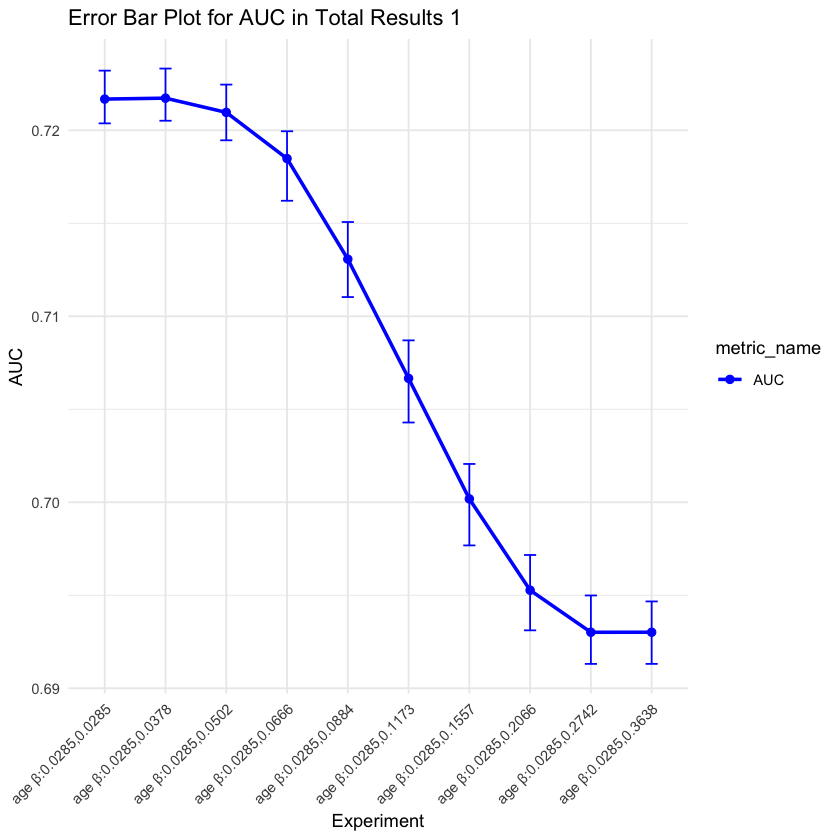

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0285' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0285' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0378' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0378' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0502' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0502' in 'mbcsToSbcs': dot su

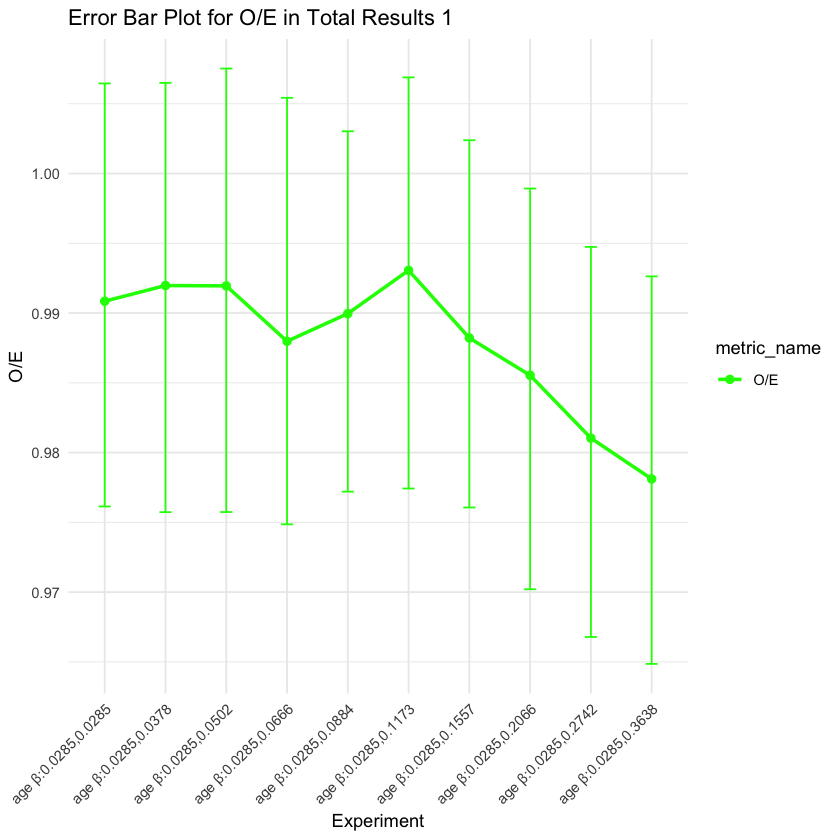

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0285' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0285' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0378' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0378' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0502' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'age β:0.0285,0.0502' in 'mbcsToSbcs': dot su

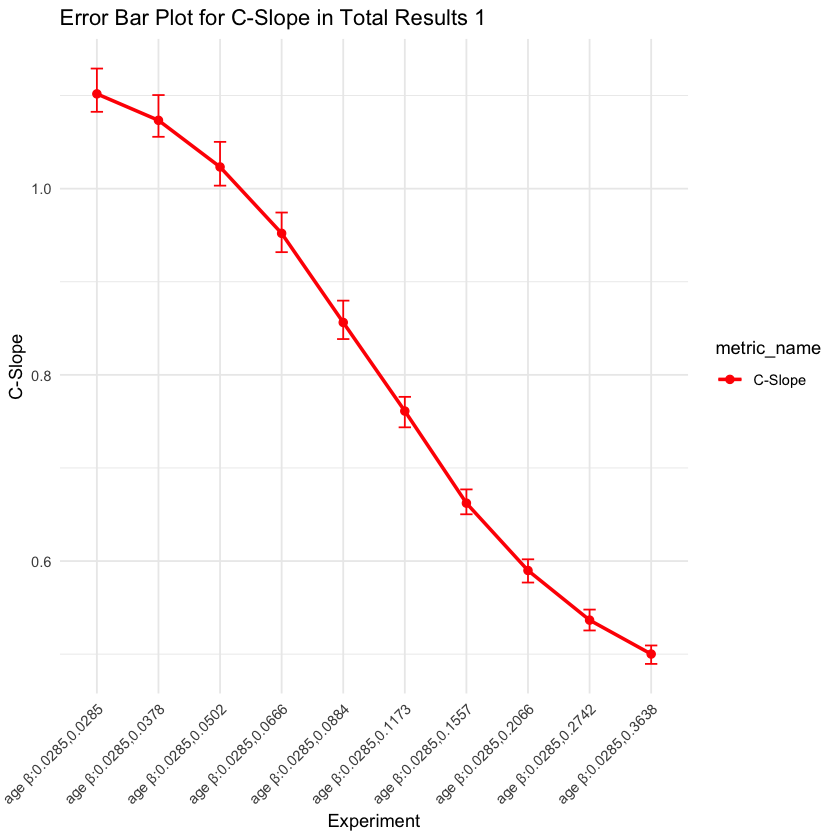

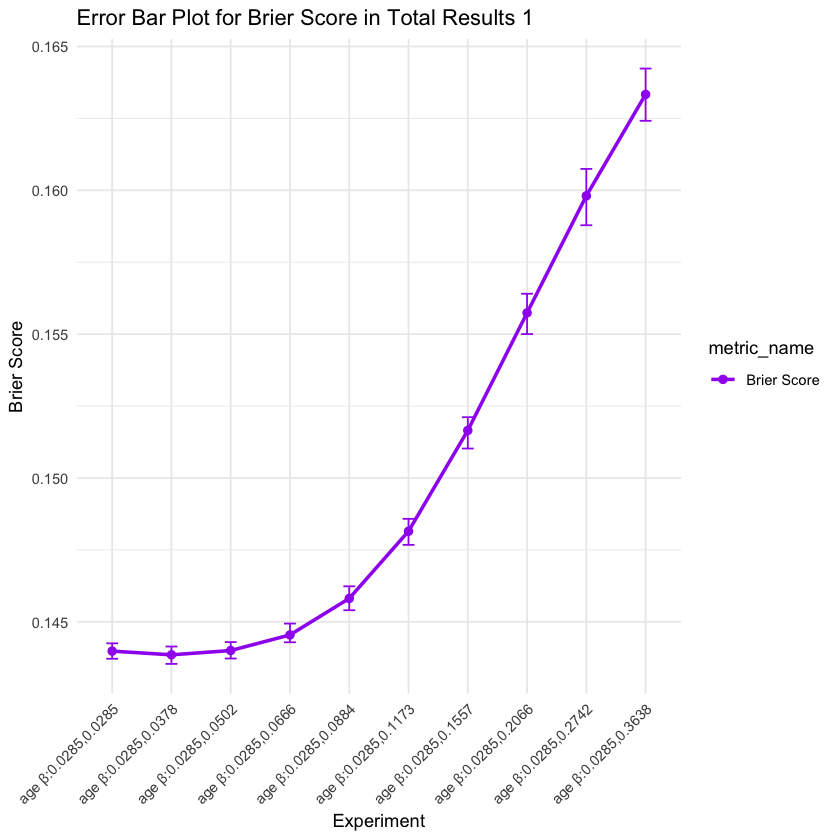

In [6]:
create_error_bar_plots(results_shifted_age_2_ml, "Total Results 1")